In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from encoding_information.information_estimation import *
from encoding_information.image_utils import *
from encoding_information.models.gaussian_process import *


from encoding_information.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

2023-11-14 22:20:42.809665: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Opening BSCCM
Opened BSCCM


## Do the entropy estimators give correct values for gaussian processes

In [2]:
# Generate a ground truth covariance matrix for each channel, and then noiseless samples from it
from encoding_information.models.gaussian_process import StationaryGaussianProcess

num_images = 10000
num_patches = 10000
# num_images = 1000
# num_patches = 1000
edge_crop = 24

patch_size = 15

channel = 'LED119'


images = load_bsccm_images(bsccm, channel=channel, num_images=num_images, edge_crop=edge_crop, median_filter=False)
patches = extract_patches(images, patch_size, num_patches=num_patches)

cov_mat = estimate_full_cov_mat(patches)
gp = StationaryGaussianProcess(patches)
gp.fit(patches)
true_cov_mat_px = gp.get_cov_mat()
true_mean_px = np.mean(images)
samples = gp.generate_samples(num_samples=num_patches, sample_shape=patch_size, ensure_nonnegative=True)

2023-11-14 22:23:37.296600: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


Initial validation NLL: 3090.73


Epoch 1: 100%|███████████████████████| 1/1 [00:05<00:00,  5.85s/it]


Epoch 1: validation NLL: 4.64


Epoch 2: 100%|███████████████████████| 1/1 [00:00<00:00, 16.54it/s]


Epoch 2: validation NLL: 4.47


Epoch 3: 100%|███████████████████████| 1/1 [00:00<00:00, 15.64it/s]


Epoch 3: validation NLL: 4.46


Epoch 4: 100%|███████████████████████| 1/1 [00:00<00:00, 16.29it/s]


Epoch 4: validation NLL: 4.45


Epoch 5: 100%|███████████████████████| 1/1 [00:00<00:00, 14.81it/s]


Epoch 5: validation NLL: 4.45


Epoch 6: 100%|███████████████████████| 1/1 [00:00<00:00, 15.69it/s]


Epoch 6: validation NLL: 4.45


Epoch 7: 100%|███████████████████████| 1/1 [00:00<00:00, 19.23it/s]


Epoch 7: validation NLL: 4.45


Epoch 8: 100%|███████████████████████| 1/1 [00:00<00:00, 18.14it/s]


Epoch 8: validation NLL: 4.45


Epoch 9: 100%|███████████████████████| 1/1 [00:00<00:00, 16.23it/s]


Epoch 9: validation NLL: 4.45


Epoch 10: 100%|██████████████████████| 1/1 [00:00<00:00, 13.31it/s]


Epoch 10: validation NLL: 4.45


Epoch 11: 100%|██████████████████████| 1/1 [00:00<00:00, 16.30it/s]


Epoch 11: validation NLL: 4.45


Epoch 12: 100%|██████████████████████| 1/1 [00:00<00:00, 14.88it/s]


Epoch 12: validation NLL: 4.45


Epoch 13: 100%|██████████████████████| 1/1 [00:00<00:00, 12.82it/s]


Epoch 13: validation NLL: 4.45


Epoch 14: 100%|██████████████████████| 1/1 [00:00<00:00, 15.96it/s]


Epoch 14: validation NLL: 4.45


Epoch 15: 100%|██████████████████████| 1/1 [00:00<00:00, 15.55it/s]


Epoch 15: validation NLL: 4.45


Epoch 16: 100%|██████████████████████| 1/1 [00:00<00:00, 12.95it/s]


Epoch 16: validation NLL: 4.45


Epoch 17: 100%|██████████████████████| 1/1 [00:00<00:00, 14.82it/s]


Epoch 17: validation NLL: 4.45


Epoch 18: 100%|██████████████████████| 1/1 [00:00<00:00, 16.28it/s]

Epoch 18: validation NLL: 4.45

Epoch 19: 100%|██████████████████████| 1/1 [00:00<00:00, 13.40it/s]


Epoch 19: validation NLL: 4.45


Epoch 20: 100%|██████████████████████| 1/1 [00:00<00:00, 18.65it/s]


Epoch 20: validation NLL: 4.45


Epoch 21: 100%|██████████████████████| 1/1 [00:00<00:00, 25.71it/s]


Epoch 21: validation NLL: 4.46


### Verify that entrpoy and mutual information estimates are consistent: they converge to the correct value given enough samples
Of course, this is on data that is sampled form a stationary gaussian process, so its only really showing that the gaussian approximation estimator can estimate gaussian entropy and MI. 


This all uses additive gaussian noise, which has an easy analytic formula for h(y | x)

In [3]:
from encoding_information.models.gaussian_process import gaussian_likelihood, nll_per_pixel_from_cov_mat
from encoding_information.models.pixel_cnn import PixelCNN

# num_samples_to_use = np.array([10, 40, 160,]).astype(int)
num_bootstrap_samples = 80

# num_samples_to_use = np.array([10, 40, 160, 640, 2560, 10240]).astype(int)
num_samples_to_use = np.array([10, 20, 40, 80, 160, 320, 640, 1280, 2560]).astype(int)


gaussian_sigma = 50
confidence_interval = 90


def gaussian_entropy_estimate(data, stationary=False, eigenvalue_floor=1e-1, optimize=True):
    num_train = int(max(2, min(1000, 0.1 * data.shape[0])))
    train_data = data[:num_train]
    test_data = data[num_train:]
    if stationary:
        gp = StationaryGaussianProcess(train_data, eigenvalue_floor=eigenvalue_floor)
        if optimize:
            num_val_samples = max(1, min(1000, 0.1 * train_data.shape[0]))
            gp.fit(train_data, num_val_samples=num_val_samples, patience=50, max_epochs=100, verbose=False)
        nll_per_pixel = gp.compute_negative_log_likelihood(test_data, verbose=False)
        
    else:
        cov_mat = estimate_full_cov_mat(train_data)
        cov_mat = make_positive_definite(cov_mat, eigenvalue_floor=eigenvalue_floor)
        nll_per_pixel = nll_per_pixel_from_cov_mat(cov_mat, train_data.mean(axis=0).reshape(-1), train_data, np.prod(onp.array(test_data.shape)[1:]))
    return nll_per_pixel

def pixelcnn_entropy_estimate(data):
    num_train = int(max(2, min(1000, 0.1 * data.shape[0])))
    num_val_samples = int(max(1, min(1000, 0.1 * num_train)))
    train_data = data[:num_train]
    test_data = data[num_train:]
    model = PixelCNN()
    model.fit(train_data, num_val_samples=num_val_samples, max_epochs=25, verbose=False)
    nll_per_pixel = model.compute_negative_log_likelihood(test_data)
    return nll_per_pixel


h_x_analytic = analytic_multivariate_gaussian_entropy(true_cov_mat_px) 
true_cov_mat_py = true_cov_mat_px + gaussian_sigma**2 * np.eye(patch_size**2)
h_y_analytic = analytic_multivariate_gaussian_entropy(true_cov_mat_py) 
# Constant conditional entropy for Gaussian noise
h_y_given_x_analytic = analytic_multivariate_gaussian_entropy(np.eye(patch_size**2) * gaussian_sigma**2) 
mi_analytic_per_pixel = (h_y_analytic - h_y_given_x_analytic) / np.log(2)

noisy_samples = add_noise(samples, gaussian_sigma=gaussian_sigma, ensure_positive=True)


full_cov_h_y_estimates_mean = []
full_cov_h_y_estimates_conf_int = []
stationary_h_y_estimates_mean = []
stationary_h_y_estimates_conf_int = []
stationary_h_y_estimates_optimized_mean = []
stationary_h_y_estimates_optimized_conf_int = []
pixelcnn_h_y_estimates_mean = []
pixelcnn_h_y_estimates_conf_int = []


h_y_given_x_estimates_mean = []
h_y_given_x_estimates_conf_int = []


ev_floor = 1e-1
for num_to_use in tqdm(num_samples_to_use):
    # check for a cached version of this
    # create cache folder if it doesn't exist
    if not os.path.exists('.cache'):
        os.mkdir('.cache')
    if os.path.exists('.cache/entropy_estimates_{}_cache_{}_samples.npz'.format(channel, num_to_use)):
        print('loading cached version of entropy estimates')
        loaded = onp.load('.cache/entropy_estimates_{}_cache_{}_samples.npz'.format(channel, num_to_use))
        # append to the list of estimates
        full_cov_h_y_estimates_conf_int.append(loaded['full_cov_h_y_estimates_conf_int'])
        full_cov_h_y_estimates_mean.append(loaded['full_cov_h_y_estimates_mean'])
        stationary_h_y_estimates_conf_int.append(loaded['stationary_h_y_estimates_conf_int'])
        stationary_h_y_estimates_mean.append(loaded['stationary_h_y_estimates_mean'])
        stationary_h_y_estimates_optimized_conf_int.append(loaded['stationary_h_y_estimates_optimized_conf_int'])
        stationary_h_y_estimates_optimized_mean.append(loaded['stationary_h_y_estimates_optimized_mean'])
        pixelcnn_h_y_estimates_conf_int.append(loaded['pixelcnn_h_y_estimates_conf_int'])
        pixelcnn_h_y_estimates_mean.append(loaded['pixelcnn_h_y_estimates_mean'])
        h_y_given_x_estimates_conf_int.append(loaded['h_y_given_x_estimates_conf_int'])
        h_y_given_x_estimates_mean.append(loaded['h_y_given_x_estimates_mean'])
    else:

        print(f'Computing with {num_to_use} samples')

        print('full covariance gp')
        mean, conf_int = run_bootstrap(noisy_samples[:num_to_use], num_bootstrap_samples=num_bootstrap_samples, estimation_fn=
                        lambda data: gaussian_entropy_estimate(data, stationary=False, eigenvalue_floor=ev_floor, ), confidence_interval=confidence_interval, verbose=True )
        full_cov_h_y_estimates_mean.append(mean)
        full_cov_h_y_estimates_conf_int.append(conf_int)

        print('stationary gp')
        mean, conf_int = run_bootstrap(noisy_samples[:num_to_use], num_bootstrap_samples=num_bootstrap_samples, estimation_fn=
                        lambda data: gaussian_entropy_estimate(data, stationary=True, eigenvalue_floor=ev_floor, optimize=False), confidence_interval=confidence_interval, verbose=True)
        stationary_h_y_estimates_mean.append(mean)
        stationary_h_y_estimates_conf_int.append(conf_int)

        print('optimized stationary gp')
        mean, conf_int = run_bootstrap(noisy_samples[:num_to_use], num_bootstrap_samples=num_bootstrap_samples, estimation_fn=
                        lambda data: gaussian_entropy_estimate(data, stationary=True, eigenvalue_floor=ev_floor, optimize=True), confidence_interval=confidence_interval, verbose=True )
        stationary_h_y_estimates_optimized_mean.append(mean)
        stationary_h_y_estimates_optimized_conf_int.append(conf_int)

        print('pixelcnn')
        mean, conf_int = run_bootstrap(noisy_samples[:num_to_use], num_bootstrap_samples=num_bootstrap_samples, estimation_fn=
                        lambda data: pixelcnn_entropy_estimate(data), confidence_interval=confidence_interval, verbose=True )
        pixelcnn_h_y_estimates_mean.append(mean)
        pixelcnn_h_y_estimates_conf_int.append(conf_int)


        # estimate conditional entropy
        mean, conf_int = run_bootstrap(samples[:num_to_use], num_bootstrap_samples=num_bootstrap_samples, estimation_fn=
                        lambda data: estimate_conditional_entropy(data), confidence_interval=confidence_interval, verbose=True )
        h_y_given_x_estimates_mean.append(mean)
        h_y_given_x_estimates_conf_int.append(conf_int)


        # save all these results to a numpy file
        onp.savez('.cache/entropy_estimates_{}_cache_{}_samples'.format(channel, num_to_use),
                    full_cov_h_y_estimates_conf_int=onp.array(full_cov_h_y_estimates_conf_int[-1]),
                    full_cov_h_y_estimates_mean=onp.array(full_cov_h_y_estimates_mean[-1]),
                    stationary_h_y_estimates_conf_int=onp.array(stationary_h_y_estimates_conf_int[-1]),
                    stationary_h_y_estimates_mean=onp.array(stationary_h_y_estimates_mean[-1]),
                    stationary_h_y_estimates_optimized_conf_int=onp.array(stationary_h_y_estimates_optimized_conf_int[-1]),
                    stationary_h_y_estimates_optimized_mean=onp.array(stationary_h_y_estimates_optimized_mean[-1]),
                    pixelcnn_h_y_estimates_conf_int=onp.array(pixelcnn_h_y_estimates_conf_int[-1]),
                    pixelcnn_h_y_estimates_mean=onp.array(pixelcnn_h_y_estimates_mean[-1]),
                    h_y_given_x_estimates_conf_int=onp.array(h_y_given_x_estimates_conf_int[-1]),
                    h_y_given_x_estimates_mean=onp.array(h_y_given_x_estimates_mean[-1]),
                    )
                

full_cov_h_y_estimates_conf_int = np.array(full_cov_h_y_estimates_conf_int)
full_cov_h_y_estimates_mean = np.array(full_cov_h_y_estimates_mean)
stationary_h_y_estimates_conf_int = np.array(stationary_h_y_estimates_conf_int)
stationary_h_y_estimates_mean = np.array(stationary_h_y_estimates_mean)
stationary_h_y_estimates_optimized_conf_int = np.array(stationary_h_y_estimates_optimized_conf_int)
stationary_h_y_estimates_optimized_mean = np.array(stationary_h_y_estimates_optimized_mean)

pixelcnn_h_y_estimates_conf_int = np.array(pixelcnn_h_y_estimates_conf_int)
pixelcnn_h_y_estimates_mean = np.array(pixelcnn_h_y_estimates_mean)

h_y_given_x_estimates_conf_int = np.array(h_y_given_x_estimates_conf_int)
h_y_given_x_estimates_mean = np.array(h_y_given_x_estimates_mean)


  0%|                                        | 0/9 [00:00<?, ?it/s]

loading cached version of entropy estimates
loading cached version of entropy estimates
loading cached version of entropy estimates
loading cached version of entropy estimates
loading cached version of entropy estimates
loading cached version of entropy estimates
Computing with 640 samples
full covariance gp



Running bootstraps:   0%|                   | 0/80 [00:00<?, ?it/s]

key [3425954293  950586421] 




Running bootstraps:   1%|▏          | 1/80 [00:02<03:45,  2.85s/it]

key [2159684775  197167493] 




Running bootstraps:   2%|▎          | 2/80 [00:03<01:51,  1.43s/it]

key [ 399206074 2041464381] 




Running bootstraps:   4%|▍          | 3/80 [00:03<01:15,  1.02it/s]

key [ 680804522 3166747399] 




Running bootstraps:   5%|▌          | 4/80 [00:04<00:58,  1.30it/s]

key [566918485 951311726] 




Running bootstraps:   6%|▋          | 5/80 [00:04<00:49,  1.50it/s]

key [1743730356 1304481516] 




Running bootstraps:   8%|▊          | 6/80 [00:05<00:43,  1.71it/s]

key [829385158 776020252] 




Running bootstraps:   9%|▉          | 7/80 [00:05<00:39,  1.87it/s]

key [3809815062 3930469644] 




Running bootstraps:  10%|█          | 8/80 [00:05<00:36,  1.97it/s]

key [940485425 526401839] 




Running bootstraps:  11%|█▏         | 9/80 [00:07<00:53,  1.34it/s]

key [2000313338 3631072973] 




Running bootstraps:  12%|█▎        | 10/80 [00:08<01:04,  1.09it/s]

key [3902364089 1250793505] 




Running bootstraps:  14%|█▍        | 11/80 [00:09<01:07,  1.02it/s]

key [ 728780894 1444608077] 




Running bootstraps:  15%|█▌        | 12/80 [00:10<00:55,  1.22it/s]

key [3607625851 2830671949] 




Running bootstraps:  16%|█▋        | 13/80 [00:10<00:49,  1.36it/s]

key [4169823707 3317795606] 




Running bootstraps:  18%|█▊        | 14/80 [00:11<00:42,  1.54it/s]

key [  51128219 3704453753] 




Running bootstraps:  19%|█▉        | 15/80 [00:11<00:37,  1.72it/s]

key [2578957872  666390795] 




Running bootstraps:  20%|██        | 16/80 [00:11<00:34,  1.87it/s]

key [3535988298 1460863862] 




Running bootstraps:  21%|██▏       | 17/80 [00:12<00:31,  2.00it/s]

key [3377634387 2420619981] 




Running bootstraps:  22%|██▎       | 18/80 [00:12<00:29,  2.10it/s]

key [ 443490748 4191580919] 




Running bootstraps:  24%|██▍       | 19/80 [00:13<00:28,  2.14it/s]

key [ 124159790 4278836043] 




Running bootstraps:  25%|██▌       | 20/80 [00:13<00:27,  2.19it/s]

key [2012240508 2827641492] 




Running bootstraps:  26%|██▋       | 21/80 [00:14<00:26,  2.23it/s]

key [1992906922  349765768] 




Running bootstraps:  28%|██▊       | 22/80 [00:14<00:25,  2.24it/s]

key [ 23455762 400672006] 




Running bootstraps:  29%|██▉       | 23/80 [00:14<00:25,  2.26it/s]

key [1847484171 2920567463] 




Running bootstraps:  30%|███       | 24/80 [00:15<00:24,  2.27it/s]

key [2150721351 1250518629] 




Running bootstraps:  31%|███▏      | 25/80 [00:15<00:23,  2.29it/s]

key [1651009410 4059952990] 




Running bootstraps:  32%|███▎      | 26/80 [00:16<00:23,  2.31it/s]

key [3772379500 3114708706] 




Running bootstraps:  34%|███▍      | 27/80 [00:16<00:23,  2.25it/s]

key [1215801176 1271376525] 




Running bootstraps:  35%|███▌      | 28/80 [00:17<00:35,  1.48it/s]

key [3889872146 1374622663] 




Running bootstraps:  36%|███▋      | 29/80 [00:19<00:45,  1.12it/s]

key [ 568137489 2156633242] 




Running bootstraps:  38%|███▊      | 30/80 [00:20<00:47,  1.06it/s]

key [ 886027495 3519549939] 




Running bootstraps:  39%|███▉      | 31/80 [00:20<00:38,  1.26it/s]

key [3163458913 3615650083] 




Running bootstraps:  40%|████      | 32/80 [00:21<00:34,  1.40it/s]

key [3560068573 1078163324] 




Running bootstraps:  41%|████▏     | 33/80 [00:21<00:29,  1.58it/s]

key [1682317711  334063774] 




Running bootstraps:  42%|████▎     | 34/80 [00:22<00:26,  1.76it/s]

key [3044175611 2141948853] 




Running bootstraps:  44%|████▍     | 35/80 [00:22<00:23,  1.91it/s]

key [335777930 562448064] 




Running bootstraps:  45%|████▌     | 36/80 [00:23<00:21,  2.02it/s]

key [1286375320 4290864420] 




Running bootstraps:  46%|████▋     | 37/80 [00:23<00:20,  2.11it/s]

key [3558037770 1216488109] 




Running bootstraps:  48%|████▊     | 38/80 [00:23<00:19,  2.15it/s]

key [533066635  71395262] 




Running bootstraps:  49%|████▉     | 39/80 [00:24<00:18,  2.20it/s]

key [2763896764 3929523570] 




Running bootstraps:  50%|█████     | 40/80 [00:24<00:17,  2.27it/s]

key [3144878570 2941391332] 




Running bootstraps:  51%|█████▏    | 41/80 [00:25<00:17,  2.29it/s]

key [3882536558 1858013174] 




Running bootstraps:  52%|█████▎    | 42/80 [00:25<00:16,  2.28it/s]

key [3369032813 3618197113] 




Running bootstraps:  54%|█████▍    | 43/80 [00:26<00:16,  2.29it/s]

key [1097862055 2521312191] 




Running bootstraps:  55%|█████▌    | 44/80 [00:26<00:15,  2.30it/s]

key [3545262241 1079456186] 




Running bootstraps:  56%|█████▋    | 45/80 [00:26<00:15,  2.32it/s]

key [3418744176  308333113] 




Running bootstraps:  57%|█████▊    | 46/80 [00:27<00:15,  2.21it/s]

key [ 798234867 1469012971] 




Running bootstraps:  59%|█████▉    | 47/80 [00:28<00:23,  1.38it/s]

key [1493444991  503448804] 




Running bootstraps:  60%|██████    | 48/80 [00:30<00:28,  1.12it/s]

key [2377582375 2294081252] 




Running bootstraps:  61%|██████▏   | 49/80 [00:31<00:31,  1.02s/it]

key [ 594016296 3386181993] 




Running bootstraps:  62%|██████▎   | 50/80 [00:32<00:33,  1.10s/it]

key [3736795996 3723569930] 




Running bootstraps:  64%|██████▍   | 51/80 [00:34<00:34,  1.18s/it]

key [ 697126498 3462193292] 




Running bootstraps:  65%|██████▌   | 52/80 [00:35<00:35,  1.26s/it]

key [1279503016 4183028415] 




Running bootstraps:  66%|██████▋   | 53/80 [00:36<00:35,  1.30s/it]

key [1264142936 1345447937] 




Running bootstraps:  68%|██████▊   | 54/80 [00:37<00:28,  1.10s/it]

key [3705801600 3111043771] 




Running bootstraps:  69%|██████▉   | 55/80 [00:38<00:22,  1.09it/s]

key [3585086154 3674755376] 




Running bootstraps:  70%|███████   | 56/80 [00:38<00:18,  1.27it/s]

key [2230583422  465149805] 




Running bootstraps:  71%|███████▏  | 57/80 [00:38<00:15,  1.47it/s]

key [4217102207 3139972296] 




Running bootstraps:  72%|███████▎  | 58/80 [00:39<00:13,  1.65it/s]

key [1528527731 2219036624] 




Running bootstraps:  74%|███████▍  | 59/80 [00:39<00:11,  1.80it/s]

key [1650692656  892253188] 




Running bootstraps:  75%|███████▌  | 60/80 [00:40<00:10,  1.94it/s]

key [1036692638 3394216668] 




Running bootstraps:  76%|███████▋  | 61/80 [00:40<00:09,  2.09it/s]

key [2347695979  505012621] 




Running bootstraps:  78%|███████▊  | 62/80 [00:41<00:08,  2.19it/s]

key [  29164632 2242826301] 




Running bootstraps:  79%|███████▉  | 63/80 [00:41<00:07,  2.29it/s]

key [3743195907 2334665028] 




Running bootstraps:  80%|████████  | 64/80 [00:41<00:07,  2.28it/s]

key [1346324155  443881508] 




Running bootstraps:  81%|████████▏ | 65/80 [00:42<00:06,  2.28it/s]

key [  9951116 649433195] 




Running bootstraps:  82%|████████▎ | 66/80 [00:42<00:06,  2.27it/s]

key [2449667469 4047690636] 




Running bootstraps:  84%|████████▍ | 67/80 [00:43<00:05,  2.30it/s]

key [ 634181700 1585996372] 




Running bootstraps:  85%|████████▌ | 68/80 [00:43<00:05,  2.30it/s]

key [1449818378 2970246552] 




Running bootstraps:  86%|████████▋ | 69/80 [00:44<00:04,  2.28it/s]

key [1573422898 2337243885] 




Running bootstraps:  88%|████████▊ | 70/80 [00:45<00:06,  1.56it/s]

key [2027679090  670563470] 




Running bootstraps:  89%|████████▉ | 71/80 [00:46<00:07,  1.19it/s]

key [1792447352 2653740001] 




Running bootstraps:  90%|█████████ | 72/80 [00:47<00:07,  1.04it/s]

key [1211705116  323311974] 




Running bootstraps:  91%|█████████▏| 73/80 [00:49<00:07,  1.07s/it]

key [1689614310 2184799481] 




Running bootstraps:  92%|█████████▎| 74/80 [00:49<00:05,  1.12it/s]

key [3532240736  820566699] 




Running bootstraps:  94%|█████████▍| 75/80 [00:50<00:03,  1.28it/s]

key [1097952177  987389062] 




Running bootstraps:  95%|█████████▌| 76/80 [00:50<00:02,  1.48it/s]

key [3966683826 1630620214] 




Running bootstraps:  96%|█████████▋| 77/80 [00:50<00:01,  1.66it/s]

key [2935405818 3788133713] 




Running bootstraps:  98%|█████████▊| 78/80 [00:51<00:01,  1.81it/s]

key [  81256758 2048786943] 




Running bootstraps:  99%|█████████▉| 79/80 [00:51<00:00,  1.96it/s]

key [3291639423  895841458] 




Running bootstraps: 100%|██████████| 80/80 [00:52<00:00,  1.53it/s]


stationary gp



Running bootstraps:   0%|                   | 0/80 [00:00<?, ?it/s]

key [  72133815 2277032111] 




Running bootstraps:   1%|▏          | 1/80 [00:10<13:56, 10.59s/it]

key [3691003399 2648847773] 




Running bootstraps:   2%|▎          | 2/80 [00:15<09:11,  7.07s/it]

key [4045400704 3407617673] 




Running bootstraps:   4%|▍          | 3/80 [00:23<09:51,  7.68s/it]

key [1409172664 3940249825] 




Running bootstraps:   5%|▌          | 4/80 [00:31<10:00,  7.91s/it]

key [496835327 342119897] 




Running bootstraps:   6%|▋          | 5/80 [00:36<08:20,  6.67s/it]

key [3555017138 2896269392] 




Running bootstraps:   8%|▊          | 6/80 [00:46<09:38,  7.81s/it]

key [3724080798 4145992324] 




Running bootstraps:   9%|▉          | 7/80 [00:50<08:10,  6.72s/it]

key [ 39654839 496811329] 




Running bootstraps:  10%|█          | 8/80 [00:59<08:47,  7.32s/it]

key [ 643335289 4085843914] 




Running bootstraps:  11%|█▏         | 9/80 [01:03<07:35,  6.41s/it]

key [1465551679 3379664570] 




Running bootstraps:  12%|█▎        | 10/80 [01:12<08:12,  7.03s/it]

key [2295010161 3508370428] 




Running bootstraps:  14%|█▍        | 11/80 [01:16<07:09,  6.23s/it]

key [1624495354 2365371671] 




Running bootstraps:  15%|█▌        | 12/80 [01:24<07:27,  6.59s/it]

key [3556685790 3902711747] 




Running bootstraps:  16%|█▋        | 13/80 [01:29<06:48,  6.09s/it]

key [2879632080 3187767654] 




Running bootstraps:  18%|█▊        | 14/80 [01:37<07:24,  6.73s/it]

key [ 264610131 1298593577] 




Running bootstraps:  19%|█▉        | 15/80 [01:42<06:50,  6.31s/it]

key [1014129180 1649014967] 




Running bootstraps:  20%|██        | 16/80 [01:54<08:30,  7.98s/it]

key [ 953396955 3837513867] 




Running bootstraps:  21%|██▏       | 17/80 [01:59<07:23,  7.04s/it]

key [2427595246 1103780133] 




Running bootstraps:  22%|██▎       | 18/80 [02:07<07:33,  7.31s/it]

key [2334970409 3471906389] 




Running bootstraps:  24%|██▍       | 19/80 [02:12<06:40,  6.56s/it]

key [4063543605 2818462438] 




Running bootstraps:  25%|██▌       | 20/80 [02:19<06:50,  6.85s/it]

key [3308321131 2813501078] 




Running bootstraps:  26%|██▋       | 21/80 [02:24<06:02,  6.14s/it]

key [3439253699 3747549037] 




Running bootstraps:  28%|██▊       | 22/80 [02:32<06:33,  6.78s/it]

key [ 853025908 3901200666] 




Running bootstraps:  29%|██▉       | 23/80 [02:36<05:46,  6.07s/it]

key [4276867947 2741353889] 




Running bootstraps:  30%|███       | 24/80 [02:45<06:31,  6.99s/it]

key [1682830612 2770189574] 




Running bootstraps:  31%|███▏      | 25/80 [02:50<05:41,  6.20s/it]

key [ 428069350 3215336354] 




Running bootstraps:  32%|███▎      | 26/80 [02:59<06:24,  7.12s/it]

key [469794018 693316452] 




Running bootstraps:  34%|███▍      | 27/80 [03:04<05:37,  6.36s/it]

key [2342070328  466357004] 




Running bootstraps:  35%|███▌      | 28/80 [03:14<06:33,  7.57s/it]

key [4132944686 2389788987] 




Running bootstraps:  36%|███▋      | 29/80 [03:19<05:41,  6.69s/it]

key [1963318484 2934695186] 




Running bootstraps:  38%|███▊      | 30/80 [03:28<06:15,  7.51s/it]

key [1707357409 2431000079] 




Running bootstraps:  39%|███▉      | 31/80 [03:33<05:29,  6.72s/it]

key [3018939728 1632883269] 




Running bootstraps:  40%|████      | 32/80 [03:40<05:29,  6.86s/it]

key [1333574860 3074745843] 




Running bootstraps:  41%|████▏     | 33/80 [03:45<04:49,  6.16s/it]

key [1521546521  723747750] 




Running bootstraps:  42%|████▎     | 34/80 [03:52<04:54,  6.40s/it]

key [ 807106482 2096598759] 




Running bootstraps:  44%|████▍     | 35/80 [03:56<04:21,  5.80s/it]

key [3881014149 1842051400] 




Running bootstraps:  45%|████▌     | 36/80 [04:01<04:03,  5.53s/it]

key [2309290839 2503680237] 




Running bootstraps:  46%|████▋     | 37/80 [04:07<04:03,  5.66s/it]

key [2911232476 3261677693] 




Running bootstraps:  48%|████▊     | 38/80 [04:11<03:36,  5.16s/it]

key [1715123449 1069705241] 




Running bootstraps:  49%|████▉     | 39/80 [04:20<04:19,  6.33s/it]

key [3251188828 2466971622] 




Running bootstraps:  50%|█████     | 40/80 [04:24<03:42,  5.56s/it]

key [ 471594184 3113529652] 




Running bootstraps:  51%|█████▏    | 41/80 [04:31<04:02,  6.22s/it]

key [1069259965 3977052797] 




Running bootstraps:  52%|█████▎    | 42/80 [04:40<04:18,  6.79s/it]

key [1899653621  589943244] 




Running bootstraps:  54%|█████▍    | 43/80 [04:45<03:51,  6.25s/it]

key [2152015822 4234760906] 




Running bootstraps:  55%|█████▌    | 44/80 [04:50<03:31,  5.88s/it]

key [3333069629  183629437] 




Running bootstraps:  56%|█████▋    | 45/80 [04:54<03:15,  5.59s/it]

key [1917062556  658864437] 




Running bootstraps:  57%|█████▊    | 46/80 [04:59<03:02,  5.36s/it]

key [ 14006359 497719032] 




Running bootstraps:  59%|█████▉    | 47/80 [05:04<02:49,  5.13s/it]

key [1279295555  547807865] 




Running bootstraps:  60%|██████    | 48/80 [05:09<02:39,  4.98s/it]

key [1524679844 2080888828] 




Running bootstraps:  61%|██████▏   | 49/80 [05:13<02:32,  4.93s/it]

key [1921599139 4128954425] 




Running bootstraps:  62%|██████▎   | 50/80 [05:18<02:25,  4.87s/it]

key [  99756210 1610915563] 




Running bootstraps:  64%|██████▍   | 51/80 [05:23<02:19,  4.81s/it]

key [1960898174 1225375636] 




Running bootstraps:  65%|██████▌   | 52/80 [05:27<02:13,  4.75s/it]

key [ 426425324 3520091094] 




Running bootstraps:  66%|██████▋   | 53/80 [05:32<02:07,  4.72s/it]

key [3738346950  110391898] 




Running bootstraps:  68%|██████▊   | 54/80 [05:37<02:03,  4.73s/it]

key [3383713308 2641878831] 




Running bootstraps:  69%|██████▉   | 55/80 [05:42<01:58,  4.75s/it]

key [4139203245 1776051664] 




Running bootstraps:  70%|███████   | 56/80 [05:46<01:51,  4.65s/it]

key [764843785 202607130] 




Running bootstraps:  71%|███████▏  | 57/80 [05:50<01:43,  4.49s/it]

key [ 840966417 4069195007] 




Running bootstraps:  72%|███████▎  | 58/80 [05:59<02:06,  5.74s/it]

key [1892483321 3807538065] 




Running bootstraps:  74%|███████▍  | 59/80 [06:04<01:58,  5.64s/it]

key [1780866013 2461267689] 




Running bootstraps:  75%|███████▌  | 60/80 [06:09<01:46,  5.32s/it]

key [ 125404585 1029159166] 




Running bootstraps:  76%|███████▋  | 61/80 [06:13<01:34,  4.99s/it]

key [ 426147614 3051597252] 




Running bootstraps:  78%|███████▊  | 62/80 [06:23<01:56,  6.49s/it]

key [1283990444 3603080477] 




Running bootstraps:  79%|███████▉  | 63/80 [06:28<01:44,  6.18s/it]

key [ 519414756 2466415716] 




Running bootstraps:  80%|████████  | 64/80 [06:32<01:29,  5.56s/it]

key [ 172465116 2882410700] 




Running bootstraps:  81%|████████▏ | 65/80 [06:36<01:16,  5.07s/it]

key [ 826042572 4153173792] 




Running bootstraps:  82%|████████▎ | 66/80 [06:44<01:19,  5.70s/it]

key [2068985278  225464828] 




Running bootstraps:  84%|████████▍ | 67/80 [06:49<01:11,  5.48s/it]

key [3415917761 2369954800] 




Running bootstraps:  85%|████████▌ | 68/80 [06:53<01:01,  5.16s/it]

key [1702599584 2773796973] 




Running bootstraps:  86%|████████▋ | 69/80 [07:00<01:02,  5.68s/it]

key [4094145318 2919401535] 




Running bootstraps:  88%|████████▊ | 70/80 [07:07<01:01,  6.16s/it]

key [3997199327 3992300445] 




Running bootstraps:  89%|████████▉ | 71/80 [07:13<00:53,  5.93s/it]

key [3209125284  846375271] 




Running bootstraps:  90%|█████████ | 72/80 [07:17<00:44,  5.52s/it]

key [4113877181 1833055021] 




Running bootstraps:  91%|█████████▏| 73/80 [07:22<00:36,  5.26s/it]

key [ 845974240 3766888675] 




Running bootstraps:  92%|█████████▎| 74/80 [07:31<00:39,  6.58s/it]

key [689599865 626259293] 




Running bootstraps:  94%|█████████▍| 75/80 [07:39<00:34,  6.81s/it]

key [2730906826 1073021790] 




Running bootstraps:  95%|█████████▌| 76/80 [07:44<00:25,  6.47s/it]

key [ 224989922 1465074830] 




Running bootstraps:  96%|█████████▋| 77/80 [07:57<00:24,  8.33s/it]

key [1058870017 1217671854] 




Running bootstraps:  98%|█████████▊| 78/80 [08:04<00:16,  8.04s/it]

key [4021833579  173176256] 




Running bootstraps:  99%|█████████▉| 79/80 [08:10<00:07,  7.35s/it]

key [ 578736824 1456673616] 




Running bootstraps: 100%|██████████| 80/80 [08:24<00:00,  6.30s/it]


optimized stationary gp



Running bootstraps:   0%|                   | 0/80 [00:00<?, ?it/s]

key [3542163268 2336282523] 




Running bootstraps:   1%|▏          | 1/80 [00:17<22:51, 17.36s/it]

key [ 259049431 1153946178] 




Running bootstraps:   2%|▎          | 2/80 [00:34<22:24, 17.24s/it]

key [1839170712  374188323] 




Running bootstraps:   4%|▍          | 3/80 [00:54<23:31, 18.33s/it]

key [2387205977 3340717127] 




Running bootstraps:   5%|▌          | 4/80 [01:12<23:20, 18.42s/it]

key [3294113947 2327684894] 




Running bootstraps:   6%|▋          | 5/80 [01:26<20:56, 16.76s/it]

key [3608614781 4070804580] 




Running bootstraps:   8%|▊          | 6/80 [01:48<22:39, 18.38s/it]

key [1759615144 1805329357] 




Running bootstraps:   9%|▉          | 7/80 [02:06<22:11, 18.25s/it]

key [4112647887 2786156116] 




Running bootstraps:  10%|█          | 8/80 [02:26<22:34, 18.82s/it]

key [3416893324 2337328487] 




Running bootstraps:  11%|█▏         | 9/80 [02:49<23:55, 20.21s/it]

key [1237078252  220028229] 




Running bootstraps:  12%|█▎        | 10/80 [03:07<23:00, 19.72s/it]

key [901185517 680323931] 




Running bootstraps:  14%|█▍        | 11/80 [03:25<21:52, 19.03s/it]

key [2843471446 1711377252] 




Running bootstraps:  15%|█▌        | 12/80 [03:46<22:23, 19.76s/it]

key [818719504 546316331] 




Running bootstraps:  16%|█▋        | 13/80 [04:08<22:36, 20.25s/it]

key [3460762450 1229207330] 




Running bootstraps:  18%|█▊        | 14/80 [04:30<23:05, 20.99s/it]

key [2633066959  653031458] 




Running bootstraps:  19%|█▉        | 15/80 [04:46<20:50, 19.24s/it]

key [4007473637 1324772096] 




Running bootstraps:  20%|██        | 16/80 [05:05<20:36, 19.32s/it]

key [2450276284 2156413967] 




Running bootstraps:  21%|██▏       | 17/80 [05:26<20:37, 19.65s/it]

key [ 663850063 1887401266] 




Running bootstraps:  22%|██▎       | 18/80 [05:52<22:19, 21.60s/it]

key [365411220 145518129] 




Running bootstraps:  24%|██▍       | 19/80 [06:06<19:44, 19.42s/it]

key [1222407024 1306475034] 




Running bootstraps:  25%|██▌       | 20/80 [06:28<20:18, 20.32s/it]

key [2988349826  320608469] 




Running bootstraps:  26%|██▋       | 21/80 [06:49<20:03, 20.39s/it]

key [ 763532775 1297506448] 




Running bootstraps:  28%|██▊       | 22/80 [07:03<17:48, 18.43s/it]

key [1669536775  171041374] 




Running bootstraps:  29%|██▉       | 23/80 [07:22<17:44, 18.68s/it]

key [1475589772 4040954469] 




Running bootstraps:  30%|███       | 24/80 [07:44<18:14, 19.54s/it]

key [ 571636062 3075179030] 




Running bootstraps:  31%|███▏      | 25/80 [08:04<18:09, 19.82s/it]

key [3566294943 1587047492] 




Running bootstraps:  32%|███▎      | 26/80 [08:23<17:39, 19.62s/it]

key [2204124887 1729833347] 




Running bootstraps:  34%|███▍      | 27/80 [08:40<16:38, 18.84s/it]

key [2941467830 2851980160] 




Running bootstraps:  35%|███▌      | 28/80 [08:55<15:23, 17.75s/it]

key [2638825049 4021610175] 




Running bootstraps:  36%|███▋      | 29/80 [09:16<15:47, 18.58s/it]

key [536739524 510848937] 




Running bootstraps:  38%|███▊      | 30/80 [09:39<16:33, 19.87s/it]

key [3737060254  595157044] 




Running bootstraps:  39%|███▉      | 31/80 [10:00<16:28, 20.18s/it]

key [4146479201  381288663] 




Running bootstraps:  40%|████      | 32/80 [10:15<14:54, 18.63s/it]

key [3109154669 1744880407] 




Running bootstraps:  41%|████▏     | 33/80 [10:33<14:34, 18.61s/it]

key [1508821809 2521063399] 




Running bootstraps:  42%|████▎     | 34/80 [10:54<14:44, 19.22s/it]

key [2875538899 3102395791] 




Running bootstraps:  44%|████▍     | 35/80 [11:14<14:41, 19.60s/it]

key [ 860218465 2379890808] 




Running bootstraps:  45%|████▌     | 36/80 [11:35<14:33, 19.86s/it]

key [3150719471  786266882] 




Running bootstraps:  46%|████▋     | 37/80 [11:52<13:37, 19.00s/it]

key [3577848967 1750852872] 




Running bootstraps:  48%|████▊     | 38/80 [12:12<13:28, 19.24s/it]

key [3084968734 3864793502] 




Running bootstraps:  49%|████▉     | 39/80 [12:35<13:59, 20.47s/it]

key [3370705336 2254449851] 




Running bootstraps:  50%|█████     | 40/80 [12:56<13:41, 20.53s/it]

key [2299034477 4074890839] 




Running bootstraps:  51%|█████▏    | 41/80 [13:16<13:17, 20.45s/it]

key [ 260497893 2063950637] 




Running bootstraps:  52%|█████▎    | 42/80 [13:32<12:06, 19.13s/it]

key [4139085974 1481451254] 




Running bootstraps:  54%|█████▍    | 43/80 [13:51<11:42, 18.99s/it]

key [3384738113 3861387658] 




Running bootstraps:  55%|█████▌    | 44/80 [14:12<11:45, 19.61s/it]

key [3367888706  404701254] 




Running bootstraps:  56%|█████▋    | 45/80 [14:33<11:40, 20.02s/it]

key [1815821661   48836257] 




Running bootstraps:  57%|█████▊    | 46/80 [14:51<11:00, 19.41s/it]

key [1103332573 1195507730] 




Running bootstraps:  59%|█████▉    | 47/80 [15:04<09:39, 17.56s/it]

key [1981863587  518124655] 




Running bootstraps:  60%|██████    | 48/80 [15:24<09:43, 18.23s/it]

key [2849568255 2447297401] 




Running bootstraps:  61%|██████▏   | 49/80 [15:44<09:41, 18.74s/it]

key [1615516804 2609193656] 




Running bootstraps:  62%|██████▎   | 50/80 [16:06<09:51, 19.71s/it]

key [2972109527  927376403] 




Running bootstraps:  64%|██████▍   | 51/80 [16:22<09:03, 18.75s/it]

key [604606912 129435654] 




Running bootstraps:  65%|██████▌   | 52/80 [16:41<08:43, 18.68s/it]

key [4281590842 2823919378] 




Running bootstraps:  66%|██████▋   | 53/80 [17:04<08:59, 19.97s/it]

key [ 875407836 3151211372] 




Running bootstraps:  68%|██████▊   | 54/80 [17:24<08:44, 20.18s/it]

key [ 590012376 2417199056] 




Running bootstraps:  69%|██████▉   | 55/80 [17:45<08:30, 20.41s/it]

key [1683014414 2332836322] 




Running bootstraps:  70%|███████   | 56/80 [18:02<07:42, 19.29s/it]

key [ 355932369 1807010130] 




Running bootstraps:  71%|███████▏  | 57/80 [18:23<07:35, 19.82s/it]

key [2073217051  481591674] 




Running bootstraps:  72%|███████▎  | 58/80 [18:45<07:32, 20.56s/it]

key [ 546830914 3175142631] 




Running bootstraps:  74%|███████▍  | 59/80 [19:09<07:28, 21.37s/it]

key [1557229109 3444277097] 




Running bootstraps:  75%|███████▌  | 60/80 [19:30<07:07, 21.37s/it]

key [  97245302 4097289545] 




Running bootstraps:  76%|███████▋  | 61/80 [19:46<06:17, 19.88s/it]

key [4111079658 2822730354] 




Running bootstraps:  78%|███████▊  | 62/80 [20:06<05:54, 19.68s/it]

key [2174856785 1772443998] 




Running bootstraps:  79%|███████▉  | 63/80 [20:25<05:33, 19.60s/it]

key [3688607418  956934627] 




Running bootstraps:  80%|████████  | 64/80 [20:45<05:14, 19.66s/it]

key [  71551239 2246619171] 




Running bootstraps:  81%|████████▏ | 65/80 [21:04<04:54, 19.61s/it]

key [3079305945 1879342221] 




Running bootstraps:  82%|████████▎ | 66/80 [21:24<04:36, 19.76s/it]

key [2770646659  771746819] 




Running bootstraps:  84%|████████▍ | 67/80 [21:46<04:23, 20.24s/it]

key [1053485108 3649754398] 




Running bootstraps:  85%|████████▌ | 68/80 [22:01<03:44, 18.69s/it]

key [2834118548 3600382870] 




Running bootstraps:  86%|████████▋ | 69/80 [22:20<03:28, 18.94s/it]

key [2561989192 4260430918] 




Running bootstraps:  88%|████████▊ | 70/80 [22:39<03:09, 18.97s/it]

key [2895008637 2677907470] 




Running bootstraps:  89%|████████▉ | 71/80 [23:00<02:56, 19.60s/it]

key [2668987003 3141426486] 




Running bootstraps:  90%|█████████ | 72/80 [23:18<02:31, 18.88s/it]

key [2141693841 3794709695] 




Running bootstraps:  91%|█████████▏| 73/80 [23:39<02:17, 19.58s/it]

key [4109628525 3292835220] 




Running bootstraps:  92%|█████████▎| 74/80 [24:01<02:02, 20.35s/it]

key [3793250338  516235598] 




Running bootstraps:  94%|█████████▍| 75/80 [24:21<01:40, 20.19s/it]

key [ 459641318 3659831859] 




Running bootstraps:  95%|█████████▌| 76/80 [24:38<01:17, 19.25s/it]

key [3167134031 1208166965] 




Running bootstraps:  96%|█████████▋| 77/80 [24:59<00:59, 19.77s/it]

key [ 204493633 4171528651] 




Running bootstraps:  98%|█████████▊| 78/80 [25:20<00:40, 20.12s/it]

key [1532746519 3463374278] 




Running bootstraps:  99%|█████████▉| 79/80 [25:40<00:20, 20.10s/it]

key [3035752013 4101264877] 




Running bootstraps: 100%|██████████| 80/80 [25:57<00:00, 19.47s/it]


pixelcnn



Running bootstraps:   0%|                   | 0/80 [00:00<?, ?it/s]

key [ 754692186 3116051616] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]2023-11-14 22:59:56.785862: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-11-14 22:59:56.785896: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[16,128,15,15]{3,2,1,0}, u8[0]{0}) custom-call(f64[16,64,15,15]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}, f64[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}


Computing loss:   3%|▍              | 1/37 [00:02<01:25,  2.37s/it]

Computing loss:  16%|██▍            | 6/37 [00:02<00:09,  3.24it/s]

Computing loss:  30%|████▏         | 11/37 [00:02<00:03,  6.64it/s]

Computing loss:  46%|██████▍       | 17/37 [00:02<00:01, 11.60it/s]2023-11-14 22:59:59.562484: W external/xla/x

key [1704227854 3051034522] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:39,  1.10s/it]

Computing loss:  19%|██▊            | 7/37 [00:01<00:03,  7.59it/s]

Computing loss:  35%|████▉         | 13/37 [00:01<00:01, 14.71it/s]

Computing loss:  49%|██████▊       | 18/37 [00:01<00:00, 20.42it/s]

Computing loss:  62%|████████▋     | 23/37 [00:02<00:01,  8.56it/s]

Computing loss:  78%|██████████▉   | 29/37 [00:02<00:00, 12.63it/s]

Computing loss: 100%|██████████████| 37/37 [00:02<00:00, 12.86it/s]

Running bootstraps:   2%|▎          | 2/80 [01:29<55:59, 43.07s/it]

key [609107387 194253376] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:47,  1.33s/it]

Computing loss:  16%|██▍            | 6/37 [00:01<00:05,  5.48it/s]

Computing loss:  32%|████▌         | 12/37 [00:01<00:02, 11.84it/s]

Computing loss:  49%|██████▊       | 18/37 [00:01<00:01, 18.45it/s]

Computing loss:  62%|████████▋     | 23/37 [00:02<00:01,  9.65it/s]

Computing loss:  76%|██████████▌   | 28/37 [00:02<00:00, 13.05it/s]

Computing loss: 100%|██████████████| 37/37 [00:02<00:00, 12.59it/s]

Running bootstraps:   4%|▍          | 3/80 [02:01<48:36, 37.87s/it]

key [3023083765 1706810980] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:38,  1.06s/it]

Computing loss:  16%|██▍            | 6/37 [00:01<00:04,  6.74it/s]

Computing loss:  30%|████▏         | 11/37 [00:01<00:02, 12.63it/s]

Computing loss:  41%|█████▋        | 15/37 [00:01<00:01, 17.16it/s]

Computing loss:  54%|███████▌      | 20/37 [00:01<00:00, 23.24it/s]

Computing loss:  68%|█████████▍    | 25/37 [00:02<00:01,  9.28it/s]

Computing loss:  81%|███████████▎  | 30/37 [00:02<00:00, 12.81it/s]

Computing loss: 100%|██████████████| 37/37 [00:02<00:00, 13.03it/s]

Running bootstraps:   5%|▌          | 4/80 [02:33<45:09, 35.65s/it]

key [1853174026 3954417624] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:38,  1.06s/it]

Computing loss:  16%|██▍            | 6/37 [00:01<00:04,  6.74it/s]

Computing loss:  30%|████▏         | 11/37 [00:01<00:02, 12.74it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 18.49it/s]

Computing loss:  57%|███████▉      | 21/37 [00:01<00:00, 23.52it/s]

Computing loss:  68%|█████████▍    | 25/37 [00:02<00:01,  8.88it/s]

Computing loss:  81%|███████████▎  | 30/37 [00:02<00:00, 12.50it/s]

Computing loss: 100%|██████████████| 37/37 [00:02<00:00, 12.96it/s]

Running bootstraps:   6%|▋          | 5/80 [03:05<42:54, 34.33s/it]

key [1640491902 1311788803] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:36,  1.01s/it]

Computing loss:  16%|██▍            | 6/37 [00:01<00:04,  7.00it/s]

Computing loss:  30%|████▏         | 11/37 [00:01<00:01, 13.38it/s]

Computing loss:  46%|██████▍       | 17/37 [00:01<00:00, 20.88it/s]

Computing loss:  59%|████████▎     | 22/37 [00:02<00:01, 10.25it/s]

Computing loss:  76%|██████████▌   | 28/37 [00:02<00:00, 14.82it/s]

Computing loss: 100%|██████████████| 37/37 [00:02<00:00, 14.39it/s]

Running bootstraps:   8%|▊          | 6/80 [03:37<41:28, 33.63s/it]

key [1201524058 3683918146] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:39,  1.09s/it]

Computing loss:  14%|██             | 5/37 [00:01<00:05,  5.43it/s]

Computing loss:  27%|███▊          | 10/37 [00:01<00:02, 11.55it/s]

Computing loss:  41%|█████▋        | 15/37 [00:01<00:01, 17.44it/s]

Computing loss:  54%|███████▌      | 20/37 [00:01<00:00, 23.10it/s]

Computing loss:  68%|█████████▍    | 25/37 [00:02<00:01,  9.53it/s]

Computing loss:  81%|███████████▎  | 30/37 [00:02<00:00, 13.11it/s]

Computing loss: 100%|██████████████| 37/37 [00:02<00:00, 12.93it/s]

Running bootstraps:   9%|▉          | 7/80 [04:09<40:18, 33.13s/it]

key [1411135204  637328683] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:37,  1.03s/it]

Computing loss:  16%|██▍            | 6/37 [00:01<00:04,  6.93it/s]

Computing loss:  30%|████▏         | 11/37 [00:01<00:01, 13.26it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 19.19it/s]

Computing loss:  57%|███████▉      | 21/37 [00:01<00:00, 24.36it/s]

Computing loss:  70%|█████████▊    | 26/37 [00:02<00:01, 10.89it/s]

Computing loss:  86%|████████████  | 32/37 [00:02<00:00, 15.53it/s]

Computing loss: 100%|██████████████| 37/37 [00:02<00:00, 14.21it/s]

Running bootstraps:  10%|█          | 8/80 [04:44<40:13, 33.52s/it]

key [1462335140  887729816] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:39,  1.09s/it]

Computing loss:  16%|██▍            | 6/37 [00:01<00:04,  6.55it/s]

Computing loss:  30%|████▏         | 11/37 [00:01<00:02, 12.66it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 18.62it/s]

Computing loss:  57%|███████▉      | 21/37 [00:01<00:00, 23.98it/s]

Computing loss:  70%|█████████▊    | 26/37 [00:02<00:01,  9.88it/s]

Computing loss: 100%|██████████████| 37/37 [00:02<00:00, 13.35it/s]

Running bootstraps:  11%|█▏         | 9/80 [05:17<39:32, 33.42s/it]

key [ 827712663 3411974784] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:38,  1.06s/it]

Computing loss:  14%|██             | 5/37 [00:01<00:05,  5.56it/s]

Computing loss:  27%|███▊          | 10/37 [00:01<00:02, 11.59it/s]

Computing loss:  38%|█████▎        | 14/37 [00:01<00:01, 16.28it/s]

Computing loss:  51%|███████▏      | 19/37 [00:01<00:00, 22.24it/s]

Computing loss:  62%|████████▋     | 23/37 [00:02<00:01,  8.58it/s]

Computing loss:  76%|██████████▌   | 28/37 [00:02<00:00, 12.10it/s]

Computing loss: 100%|██████████████| 37/37 [00:02<00:00, 12.81it/s]

Running bootstraps:  12%|█▎        | 10/80 [05:52<39:24, 33.78s/it]

key [2832773381   62236863] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:38,  1.06s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:07,  4.37it/s]

Computing loss:  19%|██▊            | 7/37 [00:01<00:03,  8.00it/s]

Computing loss:  27%|███▊          | 10/37 [00:01<00:02, 11.57it/s]

Computing loss:  35%|████▉         | 13/37 [00:01<00:01, 14.99it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 17.96it/s]

Computing loss:  51%|███████▏      | 19/37 [00:01<00:00, 20.53it/s]

Computing loss:  59%|████████▎     | 22/37 [00:02<00:02,  7.34it/s]

Computing loss:  70%|█████████▊    | 26/37 [00:02<00:01, 10.44it/s]

Computing loss:  81%|███████████▎  | 30/37 [00:02<00:00, 13.66it/s]

Computing loss:  89%|████████████▍ | 33/37 [00:03<00:00, 15.87it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 11.74it/s]

Running bootstraps:  14%|█▍        | 11/80 [06:31<40:55, 35.58s/it]

key [3269136050 1217561506] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:37,  1.05s/it]

Computing loss:  14%|██             | 5/37 [00:01<00:05,  5.37it/s]

Computing loss:  22%|███▏           | 8/37 [00:01<00:03,  8.79it/s]

Computing loss:  30%|████▏         | 11/37 [00:01<00:02, 12.12it/s]

Computing loss:  38%|█████▎        | 14/37 [00:01<00:01, 15.32it/s]

Computing loss:  46%|██████▍       | 17/37 [00:01<00:01, 18.39it/s]

Computing loss:  54%|███████▌      | 20/37 [00:01<00:00, 20.84it/s]

Computing loss:  62%|████████▋     | 23/37 [00:02<00:02,  6.89it/s]

Computing loss:  70%|█████████▊    | 26/37 [00:02<00:01,  8.95it/s]

Computing loss:  78%|██████████▉   | 29/37 [00:02<00:00, 11.30it/s]

Computing loss:  86%|████████████  | 32/37 [00:03<00:00, 13.82it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 11.21it/s]

Running bootstraps:  15%|█▌        | 12/80 [07:12<42:02, 37.10s/it]

key [3881593336 1046802199] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:39,  1.10s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:07,  4.13it/s]

Computing loss:  19%|██▊            | 7/37 [00:01<00:03,  7.56it/s]

Computing loss:  27%|███▊          | 10/37 [00:01<00:02, 10.93it/s]

Computing loss:  35%|████▉         | 13/37 [00:01<00:01, 13.88it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 16.19it/s]

Computing loss:  51%|███████▏      | 19/37 [00:01<00:00, 18.11it/s]

Computing loss:  59%|████████▎     | 22/37 [00:02<00:02,  6.52it/s]

Computing loss:  68%|█████████▍    | 25/37 [00:03<00:01,  8.56it/s]

Computing loss:  76%|██████████▌   | 28/37 [00:03<00:00, 10.74it/s]

Computing loss:  84%|███████████▋  | 31/37 [00:03<00:00, 12.99it/s]

Computing loss:  92%|████████████▊ | 34/37 [00:03<00:00, 15.22it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 10.56it/s]

Running bootstraps:  16%|█▋     

key [ 559511958 3794298817] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:38,  1.07s/it]

Computing loss:   8%|█▏             | 3/37 [00:01<00:10,  3.18it/s]

Computing loss:  16%|██▍            | 6/37 [00:01<00:04,  6.78it/s]

Computing loss:  24%|███▋           | 9/37 [00:01<00:02, 10.41it/s]

Computing loss:  32%|████▌         | 12/37 [00:01<00:01, 13.55it/s]

Computing loss:  41%|█████▋        | 15/37 [00:01<00:01, 16.85it/s]

Computing loss:  51%|███████▏      | 19/37 [00:01<00:00, 21.10it/s]

Computing loss:  59%|████████▎     | 22/37 [00:02<00:02,  7.13it/s]

Computing loss:  68%|█████████▍    | 25/37 [00:02<00:01,  9.15it/s]

Computing loss:  76%|██████████▌   | 28/37 [00:03<00:00, 11.57it/s]

Computing loss:  84%|███████████▋  | 31/37 [00:03<00:00, 14.11it/s]

Computing loss:  92%|████████████▊ | 34/37 [00:03<00:00, 16.65it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 11.08it/s]

Running bootstraps:  18%|█▊     

key [2581764910 1540564428] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:40,  1.11s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:07,  4.14it/s]

Computing loss:  22%|███▏           | 8/37 [00:01<00:03,  8.89it/s]

Computing loss:  30%|████▏         | 11/37 [00:01<00:02, 11.93it/s]

Computing loss:  38%|█████▎        | 14/37 [00:01<00:01, 14.78it/s]

Computing loss:  46%|██████▍       | 17/37 [00:01<00:01, 17.40it/s]

Computing loss:  54%|███████▌      | 20/37 [00:01<00:00, 19.69it/s]

Computing loss:  62%|████████▋     | 23/37 [00:03<00:03,  4.60it/s]

Computing loss:  73%|██████████▏   | 27/37 [00:03<00:01,  6.79it/s]

Computing loss:  81%|███████████▎  | 30/37 [00:03<00:00,  8.55it/s]

Computing loss:  89%|████████████▍ | 33/37 [00:03<00:00, 10.58it/s]

Computing loss: 100%|██████████████| 37/37 [00:04<00:00,  9.13it/s]

Running bootstraps:  19%|█▉        | 15/80 [09:13<42:20, 39.09s/it]

key [3855376542 3251311204] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:43,  1.21s/it]

Computing loss:  16%|██▍            | 6/37 [00:01<00:05,  5.98it/s]

Computing loss:  30%|████▏         | 11/37 [00:01<00:02, 11.51it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 17.34it/s]

Computing loss:  59%|████████▎     | 22/37 [00:02<00:01,  8.46it/s]

Computing loss:  68%|█████████▍    | 25/37 [00:02<00:01, 10.14it/s]

Computing loss:  76%|██████████▌   | 28/37 [00:02<00:00, 12.03it/s]

Computing loss:  84%|███████████▋  | 31/37 [00:03<00:00, 14.20it/s]

Computing loss:  92%|████████████▊ | 34/37 [00:03<00:00, 16.26it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 11.28it/s]

Running bootstraps:  20%|██        | 16/80 [09:53<41:43, 39.12s/it]

key [1558016077  403497380] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:00<00:35,  1.02it/s]

Computing loss:  11%|█▌             | 4/37 [00:01<00:07,  4.58it/s]

Computing loss:  19%|██▊            | 7/37 [00:01<00:03,  8.23it/s]

Computing loss:  27%|███▊          | 10/37 [00:01<00:02, 11.80it/s]

Computing loss:  35%|████▉         | 13/37 [00:01<00:01, 15.31it/s]

Computing loss:  46%|██████▍       | 17/37 [00:01<00:00, 20.18it/s]

Computing loss:  54%|███████▌      | 20/37 [00:01<00:00, 22.21it/s]

Computing loss:  62%|████████▋     | 23/37 [00:02<00:01,  7.27it/s]

Computing loss:  70%|█████████▊    | 26/37 [00:02<00:01,  9.35it/s]

Computing loss:  78%|██████████▉   | 29/37 [00:02<00:00, 11.62it/s]

Computing loss:  86%|████████████  | 32/37 [00:03<00:00, 13.99it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 11.53it/s]

Running bootstraps:  21%|██▏       | 17/80 [10:35<42:06, 40.11s/it]

key [ 498784225 2852022236] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:37,  1.04s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:07,  4.39it/s]

Computing loss:  19%|██▊            | 7/37 [00:01<00:03,  8.02it/s]

Computing loss:  30%|████▏         | 11/37 [00:01<00:01, 13.34it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 20.32it/s]

Computing loss:  57%|███████▉      | 21/37 [00:01<00:00, 26.66it/s]

Computing loss:  70%|█████████▊    | 26/37 [00:02<00:01,  9.92it/s]

Computing loss:  78%|██████████▉   | 29/37 [00:02<00:00, 11.49it/s]

Computing loss:  86%|████████████  | 32/37 [00:02<00:00, 13.37it/s]

Computing loss: 100%|██████████████| 37/37 [00:02<00:00, 12.41it/s]

Running bootstraps:  22%|██▎       | 18/80 [11:17<41:51, 40.51s/it]

key [3045159292 2939060731] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:38,  1.07s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:07,  4.36it/s]

Computing loss:  24%|███▋           | 9/37 [00:01<00:02, 10.31it/s]

Computing loss:  35%|████▉         | 13/37 [00:01<00:01, 14.89it/s]

Computing loss:  46%|██████▍       | 17/37 [00:01<00:01, 18.67it/s]

Computing loss:  57%|███████▉      | 21/37 [00:01<00:00, 20.93it/s]

Computing loss:  65%|█████████     | 24/37 [00:02<00:01,  7.66it/s]

Computing loss:  73%|██████████▏   | 27/37 [00:02<00:01,  9.55it/s]

Computing loss:  81%|███████████▎  | 30/37 [00:02<00:00, 11.73it/s]

Computing loss:  89%|████████████▍ | 33/37 [00:03<00:00, 14.08it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 11.45it/s]

Running bootstraps:  24%|██▍       | 19/80 [11:58<41:23, 40.71s/it]

key [1319603282 1910146554] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:38,  1.06s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:07,  4.35it/s]

Computing loss:  19%|██▊            | 7/37 [00:01<00:03,  7.88it/s]

Computing loss:  27%|███▊          | 10/37 [00:01<00:02, 11.29it/s]

Computing loss:  35%|████▉         | 13/37 [00:01<00:01, 14.15it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 16.61it/s]

Computing loss:  51%|███████▏      | 19/37 [00:01<00:00, 18.87it/s]

Computing loss:  59%|████████▎     | 22/37 [00:02<00:02,  7.02it/s]

Computing loss:  68%|█████████▍    | 25/37 [00:02<00:01,  9.13it/s]

Computing loss:  76%|██████████▌   | 28/37 [00:02<00:00, 11.49it/s]

Computing loss:  84%|███████████▋  | 31/37 [00:03<00:00, 13.82it/s]

Computing loss:  92%|████████████▊ | 34/37 [00:03<00:00, 16.03it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 11.12it/s]

Running bootstraps:  25%|██▌    

key [3147090203 2759055390] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:37,  1.04s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:07,  4.39it/s]

Computing loss:  19%|██▊            | 7/37 [00:01<00:03,  7.90it/s]

Computing loss:  27%|███▊          | 10/37 [00:01<00:02, 11.33it/s]

Computing loss:  35%|████▉         | 13/37 [00:01<00:01, 14.53it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 17.09it/s]

Computing loss:  51%|███████▏      | 19/37 [00:01<00:00, 19.76it/s]

Computing loss:  59%|████████▎     | 22/37 [00:02<00:02,  6.73it/s]

Computing loss:  68%|█████████▍    | 25/37 [00:02<00:01,  8.80it/s]

Computing loss:  76%|██████████▌   | 28/37 [00:03<00:00, 11.10it/s]

Computing loss:  84%|███████████▋  | 31/37 [00:03<00:00, 13.54it/s]

Computing loss:  92%|████████████▊ | 34/37 [00:03<00:00, 16.04it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 11.04it/s]

Running bootstraps:  26%|██▋    

key [2482915201  609887364] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:37,  1.04s/it]

Computing loss:  14%|██             | 5/37 [00:01<00:05,  5.53it/s]

Computing loss:  24%|███▋           | 9/37 [00:01<00:02, 10.08it/s]

Computing loss:  32%|████▌         | 12/37 [00:01<00:01, 13.10it/s]

Computing loss:  41%|█████▋        | 15/37 [00:01<00:01, 15.94it/s]

Computing loss:  49%|██████▊       | 18/37 [00:01<00:01, 18.36it/s]

Computing loss:  57%|███████▉      | 21/37 [00:01<00:00, 19.68it/s]

Computing loss:  65%|█████████     | 24/37 [00:02<00:01,  7.14it/s]

Computing loss:  73%|██████████▏   | 27/37 [00:02<00:01,  9.24it/s]

Computing loss:  81%|███████████▎  | 30/37 [00:02<00:00, 11.49it/s]

Computing loss:  89%|████████████▍ | 33/37 [00:03<00:00, 13.72it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 11.33it/s]

Running bootstraps:  28%|██▊       | 22/80 [14:01<39:29, 40.85s/it]

key [1981881276 1816885878] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:39,  1.10s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:07,  4.19it/s]

Computing loss:  19%|██▊            | 7/37 [00:01<00:03,  7.56it/s]

Computing loss:  27%|███▊          | 10/37 [00:01<00:02, 10.94it/s]

Computing loss:  35%|████▉         | 13/37 [00:01<00:01, 13.97it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 16.89it/s]

Computing loss:  51%|███████▏      | 19/37 [00:01<00:00, 18.94it/s]

Computing loss:  59%|████████▎     | 22/37 [00:02<00:02,  6.27it/s]

Computing loss:  68%|█████████▍    | 25/37 [00:03<00:01,  8.22it/s]

Computing loss:  76%|██████████▌   | 28/37 [00:03<00:00, 10.45it/s]

Computing loss:  84%|███████████▋  | 31/37 [00:03<00:00, 12.78it/s]

Computing loss:  92%|████████████▊ | 34/37 [00:03<00:00, 14.51it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 10.40it/s]

Running bootstraps:  29%|██▉    

key [1147822014 3708718221] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:40,  1.13s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:08,  4.06it/s]

Computing loss:  19%|██▊            | 7/37 [00:01<00:04,  7.48it/s]

Computing loss:  27%|███▊          | 10/37 [00:01<00:02, 10.83it/s]

Computing loss:  35%|████▉         | 13/37 [00:01<00:01, 13.54it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 16.16it/s]

Computing loss:  51%|███████▏      | 19/37 [00:01<00:00, 18.18it/s]

Computing loss:  59%|████████▎     | 22/37 [00:02<00:02,  6.27it/s]

Computing loss:  68%|█████████▍    | 25/37 [00:03<00:01,  8.30it/s]

Computing loss:  76%|██████████▌   | 28/37 [00:03<00:00, 10.54it/s]

Computing loss:  84%|███████████▋  | 31/37 [00:03<00:00, 13.00it/s]

Computing loss:  92%|████████████▊ | 34/37 [00:03<00:00, 15.50it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 10.47it/s]

Running bootstraps:  30%|███    

key [2320431572  962295652] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:39,  1.09s/it]

Computing loss:  14%|██             | 5/37 [00:01<00:06,  5.20it/s]

Computing loss:  22%|███▏           | 8/37 [00:01<00:03,  8.32it/s]

Computing loss:  30%|████▏         | 11/37 [00:01<00:02, 11.38it/s]

Computing loss:  38%|█████▎        | 14/37 [00:01<00:01, 14.59it/s]

Computing loss:  46%|██████▍       | 17/37 [00:01<00:01, 17.35it/s]

Computing loss:  54%|███████▌      | 20/37 [00:01<00:00, 19.93it/s]

Computing loss:  62%|████████▋     | 23/37 [00:02<00:02,  6.55it/s]

Computing loss:  70%|█████████▊    | 26/37 [00:03<00:01,  8.63it/s]

Computing loss:  78%|██████████▉   | 29/37 [00:03<00:00, 11.03it/s]

Computing loss:  89%|████████████▍ | 33/37 [00:03<00:00, 14.34it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 10.85it/s]

Running bootstraps:  31%|███▏      | 25/80 [16:15<40:10, 43.82s/it]

key [ 819676033 2866787588] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:40,  1.14s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:08,  4.09it/s]

Computing loss:  19%|██▊            | 7/37 [00:01<00:03,  7.50it/s]

Computing loss:  27%|███▊          | 10/37 [00:01<00:02, 10.72it/s]

Computing loss:  35%|████▉         | 13/37 [00:01<00:01, 14.02it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 16.15it/s]

Computing loss:  51%|███████▏      | 19/37 [00:01<00:01, 17.99it/s]

Computing loss:  59%|████████▎     | 22/37 [00:03<00:02,  6.14it/s]

Computing loss:  68%|█████████▍    | 25/37 [00:03<00:01,  8.21it/s]

Computing loss:  81%|███████████▎  | 30/37 [00:03<00:00, 12.45it/s]

Computing loss:  92%|████████████▊ | 34/37 [00:03<00:00, 15.62it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 10.66it/s]

Running bootstraps:  32%|███▎      | 26/80 [16:57<38:52, 43.20s/it]

key [1295974729  791943814] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:37,  1.05s/it]

Computing loss:  16%|██▍            | 6/37 [00:01<00:04,  6.78it/s]

Computing loss:  30%|████▏         | 11/37 [00:01<00:01, 13.04it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 18.98it/s]

Computing loss:  57%|███████▉      | 21/37 [00:01<00:00, 24.30it/s]

Computing loss:  70%|█████████▊    | 26/37 [00:02<00:01, 10.01it/s]

Computing loss:  78%|██████████▉   | 29/37 [00:02<00:00, 11.45it/s]

Computing loss:  86%|████████████  | 32/37 [00:02<00:00, 13.51it/s]

Computing loss: 100%|██████████████| 37/37 [00:02<00:00, 12.58it/s]

Running bootstraps:  34%|███▍      | 27/80 [17:35<36:45, 41.61s/it]

key [510117990 116984805] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:37,  1.05s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:07,  4.34it/s]

Computing loss:  19%|██▊            | 7/37 [00:01<00:03,  8.01it/s]

Computing loss:  27%|███▊          | 10/37 [00:01<00:02, 11.67it/s]

Computing loss:  35%|████▉         | 13/37 [00:01<00:01, 14.92it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 17.75it/s]

Computing loss:  51%|███████▏      | 19/37 [00:01<00:00, 19.64it/s]

Computing loss:  59%|████████▎     | 22/37 [00:02<00:02,  6.67it/s]

Computing loss:  68%|█████████▍    | 25/37 [00:02<00:01,  8.60it/s]

Computing loss:  76%|██████████▌   | 28/37 [00:03<00:00, 10.76it/s]

Computing loss:  84%|███████████▋  | 31/37 [00:03<00:00, 13.16it/s]

Computing loss:  92%|████████████▊ | 34/37 [00:03<00:00, 15.52it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 10.95it/s]

Running bootstraps:  35%|███▌   

key [219138803 386264683] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:44,  1.24s/it]

Computing loss:  16%|██▍            | 6/37 [00:01<00:05,  5.83it/s]

Computing loss:  30%|████▏         | 11/37 [00:01<00:02, 11.15it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 16.81it/s]

Computing loss:  57%|███████▉      | 21/37 [00:01<00:00, 22.35it/s]

Computing loss:  70%|█████████▊    | 26/37 [00:02<00:01,  8.67it/s]

Computing loss:  84%|███████████▋  | 31/37 [00:03<00:00, 11.97it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 11.79it/s]

Running bootstraps:  36%|███▋      | 29/80 [18:54<34:27, 40.54s/it]

key [2282327580  485077387] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:39,  1.10s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:07,  4.22it/s]

Computing loss:  19%|██▊            | 7/37 [00:01<00:03,  7.71it/s]

Computing loss:  27%|███▊          | 10/37 [00:01<00:02, 11.14it/s]

Computing loss:  41%|█████▋        | 15/37 [00:01<00:01, 17.52it/s]

Computing loss:  51%|███████▏      | 19/37 [00:01<00:00, 20.80it/s]

Computing loss:  59%|████████▎     | 22/37 [00:02<00:01,  7.69it/s]

Computing loss:  68%|█████████▍    | 25/37 [00:02<00:01,  9.60it/s]

Computing loss:  76%|██████████▌   | 28/37 [00:02<00:00, 11.67it/s]

Computing loss:  84%|███████████▋  | 31/37 [00:03<00:00, 13.65it/s]

Computing loss:  92%|████████████▊ | 34/37 [00:03<00:00, 15.87it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 11.18it/s]

Running bootstraps:  38%|███▊      | 30/80 [19:37<34:14, 41.09s/it]

key [ 523386605 3249287485] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:40,  1.12s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:08,  4.12it/s]

Computing loss:  19%|██▊            | 7/37 [00:01<00:03,  7.53it/s]

Computing loss:  27%|███▊          | 10/37 [00:01<00:02, 10.91it/s]

Computing loss:  35%|████▉         | 13/37 [00:01<00:01, 14.17it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 16.92it/s]

Computing loss:  51%|███████▏      | 19/37 [00:01<00:00, 18.70it/s]

Computing loss:  59%|████████▎     | 22/37 [00:02<00:02,  6.30it/s]

Computing loss:  68%|█████████▍    | 25/37 [00:03<00:01,  8.29it/s]

Computing loss:  76%|██████████▌   | 28/37 [00:03<00:00, 10.46it/s]

Computing loss:  84%|███████████▋  | 31/37 [00:03<00:00, 13.00it/s]

Computing loss:  92%|████████████▊ | 34/37 [00:03<00:00, 15.62it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 10.51it/s]

Running bootstraps:  39%|███▉   

key [4137519828 1920335416] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:38,  1.07s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:07,  4.24it/s]

Computing loss:  19%|██▊            | 7/37 [00:01<00:03,  7.70it/s]

Computing loss:  27%|███▊          | 10/37 [00:01<00:02, 11.22it/s]

Computing loss:  35%|████▉         | 13/37 [00:01<00:01, 14.11it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 16.67it/s]

Computing loss:  51%|███████▏      | 19/37 [00:01<00:00, 18.51it/s]

Computing loss:  59%|████████▎     | 22/37 [00:02<00:02,  6.53it/s]

Computing loss:  68%|█████████▍    | 25/37 [00:02<00:01,  8.49it/s]

Computing loss:  76%|██████████▌   | 28/37 [00:03<00:00, 10.91it/s]

Computing loss:  84%|███████████▋  | 31/37 [00:03<00:00, 13.43it/s]

Computing loss:  92%|████████████▊ | 34/37 [00:03<00:00, 15.95it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 10.81it/s]

Running bootstraps:  40%|████   

key [2511230345  784331209] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:40,  1.11s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:07,  4.14it/s]

Computing loss:  19%|██▊            | 7/37 [00:01<00:03,  7.52it/s]

Computing loss:  27%|███▊          | 10/37 [00:01<00:02, 10.94it/s]

Computing loss:  35%|████▉         | 13/37 [00:01<00:01, 14.21it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 16.90it/s]

Computing loss:  51%|███████▏      | 19/37 [00:01<00:00, 19.19it/s]

Computing loss:  59%|████████▎     | 22/37 [00:02<00:02,  6.49it/s]

Computing loss:  70%|█████████▊    | 26/37 [00:03<00:01,  9.34it/s]

Computing loss:  78%|██████████▉   | 29/37 [00:03<00:00, 11.67it/s]

Computing loss:  86%|████████████  | 32/37 [00:03<00:00, 13.97it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 10.80it/s]

Running bootstraps:  41%|████▏     | 33/80 [21:36<31:28, 40.17s/it]

key [1950485811 2932017121] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:38,  1.07s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:07,  4.30it/s]

Computing loss:  22%|███▏           | 8/37 [00:01<00:03,  8.95it/s]

Computing loss:  30%|████▏         | 11/37 [00:01<00:02, 12.31it/s]

Computing loss:  38%|█████▎        | 14/37 [00:01<00:01, 15.45it/s]

Computing loss:  46%|██████▍       | 17/37 [00:01<00:01, 18.17it/s]

Computing loss:  54%|███████▌      | 20/37 [00:01<00:00, 20.24it/s]

Computing loss:  62%|████████▋     | 23/37 [00:02<00:01,  7.49it/s]

Computing loss:  70%|█████████▊    | 26/37 [00:02<00:01,  9.67it/s]

Computing loss:  78%|██████████▉   | 29/37 [00:02<00:00, 11.86it/s]

Computing loss:  86%|████████████  | 32/37 [00:03<00:00, 14.24it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 11.46it/s]

Running bootstraps:  42%|████▎     | 34/80 [22:19<31:36, 41.22s/it]

key [3700338629 1164906964] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:39,  1.10s/it]

Computing loss:  16%|██▍            | 6/37 [00:01<00:04,  6.52it/s]

Computing loss:  32%|████▌         | 12/37 [00:01<00:01, 13.71it/s]

Computing loss:  46%|██████▍       | 17/37 [00:01<00:01, 19.47it/s]

Computing loss:  59%|████████▎     | 22/37 [00:02<00:01,  8.92it/s]

Computing loss:  76%|██████████▌   | 28/37 [00:02<00:00, 13.10it/s]

Computing loss:  86%|████████████  | 32/37 [00:02<00:00, 15.45it/s]

Computing loss: 100%|██████████████| 37/37 [00:02<00:00, 12.62it/s]

Running bootstraps:  44%|████▍     | 35/80 [22:58<30:18, 40.42s/it]

key [3534779392 3549648463] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:38,  1.06s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:07,  4.37it/s]

Computing loss:  19%|██▊            | 7/37 [00:01<00:03,  7.99it/s]

Computing loss:  27%|███▊          | 10/37 [00:01<00:02, 11.72it/s]

Computing loss:  35%|████▉         | 13/37 [00:01<00:01, 14.96it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 17.91it/s]

Computing loss:  54%|███████▌      | 20/37 [00:01<00:00, 22.41it/s]

Computing loss:  62%|████████▋     | 23/37 [00:02<00:01,  7.15it/s]

Computing loss:  70%|█████████▊    | 26/37 [00:02<00:01,  9.19it/s]

Computing loss:  78%|██████████▉   | 29/37 [00:03<00:00, 11.44it/s]

Computing loss:  86%|████████████  | 32/37 [00:03<00:00, 13.77it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 11.17it/s]

Running bootstraps:  45%|████▌     | 36/80 [23:39<29:50, 40.69s/it]

key [4070584216  357180070] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:39,  1.09s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:07,  4.13it/s]

Computing loss:  19%|██▊            | 7/37 [00:01<00:04,  7.47it/s]

Computing loss:  27%|███▊          | 10/37 [00:01<00:02, 10.85it/s]

Computing loss:  35%|████▉         | 13/37 [00:01<00:01, 14.14it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 17.03it/s]

Computing loss:  51%|███████▏      | 19/37 [00:01<00:00, 19.11it/s]

Computing loss:  59%|████████▎     | 22/37 [00:02<00:02,  6.43it/s]

Computing loss:  70%|█████████▊    | 26/37 [00:03<00:01,  9.30it/s]

Computing loss:  81%|███████████▎  | 30/37 [00:03<00:00, 12.24it/s]

Computing loss:  89%|████████████▍ | 33/37 [00:03<00:00, 14.49it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 10.80it/s]

Running bootstraps:  46%|████▋     | 37/80 [24:22<29:30, 41.18s/it]

key [3121247436 1678927529] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:39,  1.09s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:08,  4.10it/s]

Computing loss:  19%|██▊            | 7/37 [00:01<00:04,  7.25it/s]

Computing loss:  27%|███▊          | 10/37 [00:01<00:02, 10.17it/s]

Computing loss:  35%|████▉         | 13/37 [00:01<00:01, 12.97it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 14.79it/s]

Computing loss:  51%|███████▏      | 19/37 [00:01<00:01, 16.57it/s]

Computing loss:  59%|████████▎     | 22/37 [00:03<00:02,  6.27it/s]

Computing loss:  68%|█████████▍    | 25/37 [00:03<00:01,  8.17it/s]

Computing loss:  76%|██████████▌   | 28/37 [00:03<00:00, 10.27it/s]

Computing loss:  84%|███████████▋  | 31/37 [00:03<00:00, 12.43it/s]

Computing loss:  92%|████████████▊ | 34/37 [00:03<00:00, 14.70it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 10.13it/s]

Running bootstraps:  48%|████▊  

key [341801135 356360072] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:37,  1.05s/it]

Computing loss:   8%|█▏             | 3/37 [00:01<00:10,  3.23it/s]

Computing loss:  19%|██▊            | 7/37 [00:01<00:03,  8.34it/s]

Computing loss:  27%|███▊          | 10/37 [00:01<00:02, 11.66it/s]

Computing loss:  35%|████▉         | 13/37 [00:01<00:01, 14.67it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 16.58it/s]

Computing loss:  51%|███████▏      | 19/37 [00:01<00:00, 18.33it/s]

Computing loss:  59%|████████▎     | 22/37 [00:02<00:02,  7.02it/s]

Computing loss:  65%|█████████     | 24/37 [00:02<00:01,  8.24it/s]

Computing loss:  70%|█████████▊    | 26/37 [00:02<00:01,  9.46it/s]

Computing loss:  78%|██████████▉   | 29/37 [00:03<00:00, 11.81it/s]

Computing loss:  86%|████████████  | 32/37 [00:03<00:00, 14.07it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 10.67it/s]

Running bootstraps:  49%|████▉  

key [3611637324 1824408087] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:39,  1.11s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:08,  4.10it/s]

Computing loss:  16%|██▍            | 6/37 [00:01<00:04,  6.22it/s]

Computing loss:  24%|███▋           | 9/37 [00:01<00:02,  9.58it/s]

Computing loss:  32%|████▌         | 12/37 [00:01<00:02, 12.27it/s]

Computing loss:  41%|█████▋        | 15/37 [00:01<00:01, 14.21it/s]

Computing loss:  49%|██████▊       | 18/37 [00:01<00:01, 16.07it/s]

Computing loss:  57%|███████▉      | 21/37 [00:02<00:00, 18.08it/s]

Computing loss:  65%|█████████     | 24/37 [00:03<00:01,  6.96it/s]

Computing loss:  73%|██████████▏   | 27/37 [00:03<00:01,  8.85it/s]

Computing loss:  81%|███████████▎  | 30/37 [00:03<00:00, 10.82it/s]

Computing loss:  89%|████████████▍ | 33/37 [00:03<00:00, 12.60it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 10.20it/s]

Running bootstraps:  50%|█████  

key [1999522691 3450734619] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:38,  1.07s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:07,  4.29it/s]

Computing loss:  19%|██▊            | 7/37 [00:01<00:03,  7.79it/s]

Computing loss:  27%|███▊          | 10/37 [00:01<00:02, 11.20it/s]

Computing loss:  35%|████▉         | 13/37 [00:01<00:01, 14.38it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 16.84it/s]

Computing loss:  51%|███████▏      | 19/37 [00:01<00:00, 18.91it/s]

Computing loss:  59%|████████▎     | 22/37 [00:02<00:02,  6.74it/s]

Computing loss:  68%|█████████▍    | 25/37 [00:02<00:01,  8.81it/s]

Computing loss:  76%|██████████▌   | 28/37 [00:03<00:00, 11.11it/s]

Computing loss:  84%|███████████▋  | 31/37 [00:03<00:00, 13.48it/s]

Computing loss:  92%|████████████▊ | 34/37 [00:03<00:00, 15.89it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 10.81it/s]

Running bootstraps:  51%|█████▏ 

key [3637562867 2200486316] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:37,  1.03s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:07,  4.39it/s]

Computing loss:  22%|███▏           | 8/37 [00:01<00:03,  9.30it/s]

Computing loss:  32%|████▌         | 12/37 [00:01<00:01, 13.83it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 17.79it/s]

Computing loss:  51%|███████▏      | 19/37 [00:01<00:00, 19.64it/s]

Computing loss:  59%|████████▎     | 22/37 [00:02<00:02,  7.21it/s]

Computing loss:  68%|█████████▍    | 25/37 [00:02<00:01,  9.23it/s]

Computing loss:  76%|██████████▌   | 28/37 [00:02<00:00, 11.40it/s]

Computing loss:  84%|███████████▋  | 31/37 [00:03<00:00, 13.50it/s]

Computing loss:  92%|████████████▊ | 34/37 [00:03<00:00, 16.05it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 11.38it/s]

Running bootstraps:  52%|█████▎    | 42/80 [27:52<26:13, 41.41s/it]

key [1170890930 1489150689] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:44,  1.25s/it]

Computing loss:  16%|██▍            | 6/37 [00:01<00:05,  5.74it/s]

Computing loss:  27%|███▊          | 10/37 [00:01<00:02, 10.02it/s]

Computing loss:  41%|█████▋        | 15/37 [00:01<00:01, 15.77it/s]

Computing loss:  54%|███████▌      | 20/37 [00:01<00:00, 20.63it/s]

Computing loss:  65%|█████████     | 24/37 [00:02<00:01,  7.77it/s]

Computing loss:  78%|██████████▉   | 29/37 [00:03<00:00, 11.03it/s]

Computing loss:  89%|████████████▍ | 33/37 [00:03<00:00, 13.60it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 11.07it/s]

Running bootstraps:  54%|█████▍    | 43/80 [28:36<26:07, 42.36s/it]

key [ 347850865 2758177622] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:37,  1.05s/it]

Computing loss:  14%|██             | 5/37 [00:01<00:05,  5.61it/s]

Computing loss:  27%|███▊          | 10/37 [00:01<00:02, 11.89it/s]

Computing loss:  41%|█████▋        | 15/37 [00:01<00:01, 18.28it/s]

Computing loss:  54%|███████▌      | 20/37 [00:01<00:00, 23.63it/s]

Computing loss:  68%|█████████▍    | 25/37 [00:02<00:01,  9.18it/s]

Computing loss:  76%|██████████▌   | 28/37 [00:02<00:00, 10.84it/s]

Computing loss:  84%|███████████▋  | 31/37 [00:02<00:00, 12.80it/s]

Computing loss: 100%|██████████████| 37/37 [00:02<00:00, 12.40it/s]

Running bootstraps:  55%|█████▌    | 44/80 [29:26<26:44, 44.58s/it]

key [3510753084 3144617753] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:41,  1.16s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:08,  4.02it/s]

Computing loss:  19%|██▊            | 7/37 [00:01<00:04,  7.25it/s]

Computing loss:  27%|███▊          | 10/37 [00:01<00:02, 10.50it/s]

Computing loss:  35%|████▉         | 13/37 [00:01<00:01, 13.36it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 15.59it/s]

Computing loss:  51%|███████▏      | 19/37 [00:01<00:01, 17.86it/s]

Computing loss:  59%|████████▎     | 22/37 [00:03<00:02,  6.12it/s]

Computing loss:  68%|█████████▍    | 25/37 [00:03<00:01,  8.06it/s]

Computing loss:  76%|██████████▌   | 28/37 [00:03<00:00,  9.96it/s]

Computing loss:  84%|███████████▋  | 31/37 [00:03<00:00, 12.30it/s]

Computing loss:  92%|████████████▊ | 34/37 [00:03<00:00, 14.52it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 10.05it/s]

Running bootstraps:  56%|█████▋ 

key [3410188240 3166429114] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:43,  1.20s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:08,  3.86it/s]

Computing loss:  19%|██▊            | 7/37 [00:01<00:04,  7.09it/s]

Computing loss:  27%|███▊          | 10/37 [00:01<00:02, 10.22it/s]

Computing loss:  35%|████▉         | 13/37 [00:01<00:01, 13.35it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 16.05it/s]

Computing loss:  51%|███████▏      | 19/37 [00:01<00:00, 18.09it/s]

Computing loss:  59%|████████▎     | 22/37 [00:03<00:02,  6.19it/s]

Computing loss:  68%|█████████▍    | 25/37 [00:03<00:01,  8.00it/s]

Computing loss:  76%|██████████▌   | 28/37 [00:03<00:00,  9.94it/s]

Computing loss:  84%|███████████▋  | 31/37 [00:03<00:00, 12.15it/s]

Computing loss:  92%|████████████▊ | 34/37 [00:03<00:00, 14.34it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00,  9.98it/s]

Running bootstraps:  57%|█████▊ 

key [3227604661  126381024] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:40,  1.12s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:07,  4.16it/s]

Computing loss:  19%|██▊            | 7/37 [00:01<00:03,  7.67it/s]

Computing loss:  30%|████▏         | 11/37 [00:01<00:02, 12.08it/s]

Computing loss:  38%|█████▎        | 14/37 [00:01<00:01, 14.75it/s]

Computing loss:  46%|██████▍       | 17/37 [00:01<00:01, 16.78it/s]

Computing loss:  54%|███████▌      | 20/37 [00:01<00:00, 18.45it/s]

Computing loss:  62%|████████▋     | 23/37 [00:02<00:02,  6.54it/s]

Computing loss:  70%|█████████▊    | 26/37 [00:03<00:01,  8.59it/s]

Computing loss:  78%|██████████▉   | 29/37 [00:03<00:00, 10.86it/s]

Computing loss:  86%|████████████  | 32/37 [00:03<00:00, 13.08it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 10.66it/s]

Running bootstraps:  59%|█████▉    | 47/80 [31:38<24:26, 44.43s/it]

key [3990641073 2952366780] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:39,  1.10s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:07,  4.20it/s]

Computing loss:  19%|██▊            | 7/37 [00:01<00:03,  7.63it/s]

Computing loss:  27%|███▊          | 10/37 [00:01<00:02, 11.11it/s]

Computing loss:  35%|████▉         | 13/37 [00:01<00:01, 14.05it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 16.92it/s]

Computing loss:  51%|███████▏      | 19/37 [00:01<00:00, 19.09it/s]

Computing loss:  59%|████████▎     | 22/37 [00:03<00:03,  3.77it/s]

Computing loss:  68%|█████████▍    | 25/37 [00:04<00:02,  5.18it/s]

Computing loss:  76%|██████████▌   | 28/37 [00:04<00:01,  6.96it/s]

Computing loss:  84%|███████████▋  | 31/37 [00:04<00:00,  9.01it/s]

Computing loss:  92%|████████████▊ | 34/37 [00:04<00:00, 11.32it/s]

Computing loss: 100%|██████████████| 37/37 [00:04<00:00,  8.30it/s]

Running bootstraps:  60%|██████ 

key [2983906681  555540790] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:40,  1.11s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:07,  4.14it/s]

Computing loss:  19%|██▊            | 7/37 [00:01<00:03,  7.62it/s]

Computing loss:  27%|███▊          | 10/37 [00:01<00:02, 11.14it/s]

Computing loss:  35%|████▉         | 13/37 [00:01<00:01, 13.95it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 16.62it/s]

Computing loss:  51%|███████▏      | 19/37 [00:01<00:00, 19.18it/s]

Computing loss:  59%|████████▎     | 22/37 [00:02<00:02,  6.52it/s]

Computing loss:  68%|█████████▍    | 25/37 [00:03<00:01,  8.33it/s]

Computing loss:  76%|██████████▌   | 28/37 [00:03<00:00, 10.55it/s]

Computing loss:  84%|███████████▋  | 31/37 [00:03<00:00, 12.86it/s]

Computing loss:  92%|████████████▊ | 34/37 [00:03<00:00, 14.96it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 10.53it/s]

Running bootstraps:  61%|██████▏

key [ 787715419 2532041547] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:40,  1.12s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:08,  4.05it/s]

Computing loss:  16%|██▍            | 6/37 [00:01<00:05,  6.16it/s]

Computing loss:  22%|███▏           | 8/37 [00:01<00:03,  8.32it/s]

Computing loss:  30%|████▏         | 11/37 [00:01<00:02, 11.89it/s]

Computing loss:  38%|█████▎        | 14/37 [00:01<00:01, 14.95it/s]

Computing loss:  46%|██████▍       | 17/37 [00:01<00:01, 17.08it/s]

Computing loss:  54%|███████▌      | 20/37 [00:01<00:00, 19.47it/s]

Computing loss:  62%|████████▋     | 23/37 [00:03<00:02,  6.39it/s]

Computing loss:  70%|█████████▊    | 26/37 [00:03<00:01,  8.40it/s]

Computing loss:  78%|██████████▉   | 29/37 [00:03<00:00, 10.67it/s]

Computing loss:  86%|████████████  | 32/37 [00:03<00:00, 13.05it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 10.29it/s]

Running bootstraps:  62%|██████▎

key [ 207894301 1660714240] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:40,  1.14s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:08,  4.07it/s]

Computing loss:  19%|██▊            | 7/37 [00:01<00:04,  7.27it/s]

Computing loss:  27%|███▊          | 10/37 [00:01<00:02, 10.62it/s]

Computing loss:  35%|████▉         | 13/37 [00:01<00:01, 13.44it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 15.55it/s]

Computing loss:  51%|███████▏      | 19/37 [00:01<00:01, 17.90it/s]

Computing loss:  59%|████████▎     | 22/37 [00:02<00:02,  6.31it/s]

Computing loss:  70%|█████████▊    | 26/37 [00:03<00:01,  9.05it/s]

Computing loss:  78%|██████████▉   | 29/37 [00:03<00:00, 11.23it/s]

Computing loss:  86%|████████████  | 32/37 [00:03<00:00, 13.55it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 10.47it/s]

Running bootstraps:  64%|██████▍   | 51/80 [34:30<21:19, 44.10s/it]

key [3876554126 4064188261] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:38,  1.08s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:07,  4.22it/s]

Computing loss:  19%|██▊            | 7/37 [00:01<00:03,  7.64it/s]

Computing loss:  27%|███▊          | 10/37 [00:01<00:02, 11.16it/s]

Computing loss:  35%|████▉         | 13/37 [00:01<00:01, 14.17it/s]

Computing loss:  46%|██████▍       | 17/37 [00:01<00:01, 19.09it/s]

Computing loss:  57%|███████▉      | 21/37 [00:01<00:00, 23.48it/s]

Computing loss:  68%|█████████▍    | 25/37 [00:02<00:01,  8.57it/s]

Computing loss:  81%|███████████▎  | 30/37 [00:02<00:00, 12.41it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 12.11it/s]

Running bootstraps:  65%|██████▌   | 52/80 [35:12<20:20, 43.60s/it]

key [ 244054617 3347944197] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:44,  1.23s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:08,  3.82it/s]

Computing loss:  19%|██▊            | 7/37 [00:01<00:04,  6.98it/s]

Computing loss:  27%|███▊          | 10/37 [00:01<00:02,  9.96it/s]

Computing loss:  35%|████▉         | 13/37 [00:01<00:01, 12.96it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 15.42it/s]

Computing loss:  51%|███████▏      | 19/37 [00:01<00:01, 17.57it/s]

Computing loss:  59%|████████▎     | 22/37 [00:03<00:02,  5.89it/s]

Computing loss:  68%|█████████▍    | 25/37 [00:03<00:01,  7.72it/s]

Computing loss:  76%|██████████▌   | 28/37 [00:03<00:00,  9.90it/s]

Computing loss:  84%|███████████▋  | 31/37 [00:03<00:00, 12.13it/s]

Computing loss:  92%|████████████▊ | 34/37 [00:03<00:00, 14.24it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00,  9.73it/s]

Running bootstraps:  66%|██████▋

key [2877428532 1742424288] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:41,  1.15s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:08,  4.05it/s]

Computing loss:  19%|██▊            | 7/37 [00:01<00:04,  7.49it/s]

Computing loss:  27%|███▊          | 10/37 [00:01<00:02, 10.85it/s]

Computing loss:  35%|████▉         | 13/37 [00:01<00:01, 13.60it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 16.29it/s]

Computing loss:  51%|███████▏      | 19/37 [00:01<00:00, 18.55it/s]

Computing loss:  59%|████████▎     | 22/37 [00:02<00:02,  6.27it/s]

Computing loss:  65%|█████████     | 24/37 [00:03<00:01,  7.46it/s]

Computing loss:  73%|██████████▏   | 27/37 [00:03<00:01,  9.77it/s]

Computing loss:  81%|███████████▎  | 30/37 [00:03<00:00, 12.30it/s]

Computing loss:  89%|████████████▍ | 33/37 [00:03<00:00, 14.88it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 10.31it/s]

Running bootstraps:  68%|██████▊

key [4046731836 1203800198] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:41,  1.14s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:08,  4.03it/s]

Computing loss:  19%|██▊            | 7/37 [00:01<00:04,  7.42it/s]

Computing loss:  27%|███▊          | 10/37 [00:01<00:02, 10.98it/s]

Computing loss:  35%|████▉         | 13/37 [00:01<00:01, 13.95it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 15.99it/s]

Computing loss:  51%|███████▏      | 19/37 [00:01<00:00, 18.15it/s]

Computing loss:  59%|████████▎     | 22/37 [00:02<00:02,  6.31it/s]

Computing loss:  68%|█████████▍    | 25/37 [00:03<00:01,  8.15it/s]

Computing loss:  76%|██████████▌   | 28/37 [00:03<00:00, 10.42it/s]

Computing loss:  84%|███████████▋  | 31/37 [00:03<00:00, 12.81it/s]

Computing loss:  92%|████████████▊ | 34/37 [00:03<00:00, 15.16it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 10.38it/s]

Running bootstraps:  69%|██████▉

key [3274412439 1855621549] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:40,  1.12s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:08,  4.11it/s]

Computing loss:  19%|██▊            | 7/37 [00:01<00:03,  7.52it/s]

Computing loss:  27%|███▊          | 10/37 [00:01<00:02, 10.88it/s]

Computing loss:  35%|████▉         | 13/37 [00:01<00:01, 13.79it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 16.39it/s]

Computing loss:  51%|███████▏      | 19/37 [00:01<00:00, 18.34it/s]

Computing loss:  59%|████████▎     | 22/37 [00:02<00:02,  6.16it/s]

Computing loss:  68%|█████████▍    | 25/37 [00:03<00:01,  8.11it/s]

Computing loss:  76%|██████████▌   | 28/37 [00:03<00:00, 10.23it/s]

Computing loss:  84%|███████████▋  | 31/37 [00:03<00:00, 12.47it/s]

Computing loss:  92%|████████████▊ | 34/37 [00:03<00:00, 14.60it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 10.24it/s]

Running bootstraps:  70%|███████

key [2953045181  129757719] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:39,  1.08s/it]

Computing loss:  16%|██▍            | 6/37 [00:01<00:04,  6.60it/s]

Computing loss:  30%|████▏         | 11/37 [00:01<00:02, 12.70it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 18.59it/s]

Computing loss:  57%|███████▉      | 21/37 [00:01<00:00, 23.18it/s]

Computing loss:  68%|█████████▍    | 25/37 [00:02<00:01,  8.71it/s]

Computing loss:  81%|███████████▎  | 30/37 [00:02<00:00, 12.09it/s]

Computing loss: 100%|██████████████| 37/37 [00:02<00:00, 12.72it/s]

Running bootstraps:  71%|███████▏  | 57/80 [38:49<16:21, 42.68s/it]

key [4141572782 3571888583] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:37,  1.05s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:07,  4.36it/s]

Computing loss:  19%|██▊            | 7/37 [00:01<00:03,  7.90it/s]

Computing loss:  27%|███▊          | 10/37 [00:01<00:02, 11.43it/s]

Computing loss:  35%|████▉         | 13/37 [00:01<00:01, 14.22it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 16.83it/s]

Computing loss:  51%|███████▏      | 19/37 [00:01<00:00, 18.88it/s]

Computing loss:  59%|████████▎     | 22/37 [00:02<00:02,  6.87it/s]

Computing loss:  68%|█████████▍    | 25/37 [00:02<00:01,  9.05it/s]

Computing loss:  76%|██████████▌   | 28/37 [00:02<00:00, 11.41it/s]

Computing loss:  84%|███████████▋  | 31/37 [00:03<00:00, 13.78it/s]

Computing loss:  92%|████████████▊ | 34/37 [00:03<00:00, 16.03it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 11.07it/s]

Running bootstraps:  72%|███████

key [784656530 505429570] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:41,  1.16s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:08,  3.98it/s]

Computing loss:  19%|██▊            | 7/37 [00:01<00:04,  7.26it/s]

Computing loss:  27%|███▊          | 10/37 [00:01<00:02, 10.60it/s]

Computing loss:  35%|████▉         | 13/37 [00:01<00:01, 13.49it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 15.59it/s]

Computing loss:  51%|███████▏      | 19/37 [00:01<00:00, 18.07it/s]

Computing loss:  59%|████████▎     | 22/37 [00:03<00:02,  6.07it/s]

Computing loss:  68%|█████████▍    | 25/37 [00:03<00:01,  7.98it/s]

Computing loss:  76%|██████████▌   | 28/37 [00:03<00:00, 10.21it/s]

Computing loss:  84%|███████████▋  | 31/37 [00:03<00:00, 12.56it/s]

Computing loss:  92%|████████████▊ | 34/37 [00:03<00:00, 14.73it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 10.09it/s]

Running bootstraps:  74%|███████

key [  15435316 2252309307] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:38,  1.07s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:07,  4.27it/s]

Computing loss:  19%|██▊            | 7/37 [00:01<00:03,  7.75it/s]

Computing loss:  27%|███▊          | 10/37 [00:01<00:02, 11.16it/s]

Computing loss:  35%|████▉         | 13/37 [00:01<00:01, 14.27it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 16.95it/s]

Computing loss:  51%|███████▏      | 19/37 [00:01<00:00, 18.29it/s]

Computing loss:  59%|████████▎     | 22/37 [00:02<00:02,  6.41it/s]

Computing loss:  68%|█████████▍    | 25/37 [00:03<00:01,  8.32it/s]

Computing loss:  76%|██████████▌   | 28/37 [00:03<00:00, 10.37it/s]

Computing loss:  84%|███████████▋  | 31/37 [00:03<00:00, 12.67it/s]

Computing loss:  92%|████████████▊ | 34/37 [00:03<00:00, 14.84it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 10.55it/s]

Running bootstraps:  75%|███████

key [ 703381962 3451249872] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:38,  1.08s/it]

Computing loss:  16%|██▍            | 6/37 [00:01<00:04,  6.54it/s]

Computing loss:  30%|████▏         | 11/37 [00:01<00:02, 12.58it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 18.67it/s]

Computing loss:  57%|███████▉      | 21/37 [00:01<00:00, 24.35it/s]

Computing loss:  70%|█████████▊    | 26/37 [00:02<00:01, 10.72it/s]

Computing loss:  84%|███████████▋  | 31/37 [00:02<00:00, 14.57it/s]

Computing loss: 100%|██████████████| 37/37 [00:02<00:00, 13.83it/s]

Running bootstraps:  76%|███████▋  | 61/80 [41:38<13:29, 42.59s/it]

key [  20263732 3503966686] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:38,  1.06s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:07,  4.35it/s]

Computing loss:  19%|██▊            | 7/37 [00:01<00:03,  7.88it/s]

Computing loss:  27%|███▊          | 10/37 [00:01<00:02, 11.38it/s]

Computing loss:  35%|████▉         | 13/37 [00:01<00:01, 13.72it/s]

Computing loss:  46%|██████▍       | 17/37 [00:01<00:01, 18.59it/s]

Computing loss:  54%|███████▌      | 20/37 [00:01<00:00, 20.26it/s]

Computing loss:  62%|████████▋     | 23/37 [00:02<00:02,  6.80it/s]

Computing loss:  70%|█████████▊    | 26/37 [00:03<00:01,  8.61it/s]

Computing loss:  78%|██████████▉   | 29/37 [00:03<00:00, 10.83it/s]

Computing loss:  86%|████████████  | 32/37 [00:03<00:00, 13.24it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 10.82it/s]

Running bootstraps:  78%|███████▊  | 62/80 [42:23<12:57, 43.18s/it]

key [3092212576 2382532865] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:40,  1.11s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:08,  4.11it/s]

Computing loss:  19%|██▊            | 7/37 [00:01<00:04,  7.39it/s]

Computing loss:  27%|███▊          | 10/37 [00:01<00:02, 10.50it/s]

Computing loss:  35%|████▉         | 13/37 [00:01<00:01, 13.46it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 15.97it/s]

Computing loss:  51%|███████▏      | 19/37 [00:01<00:00, 18.05it/s]

Computing loss:  59%|████████▎     | 22/37 [00:02<00:02,  6.80it/s]

Computing loss:  68%|█████████▍    | 25/37 [00:03<00:01,  8.76it/s]

Computing loss:  76%|██████████▌   | 28/37 [00:03<00:00, 10.91it/s]

Computing loss:  84%|███████████▋  | 31/37 [00:03<00:00, 13.37it/s]

Computing loss:  92%|████████████▊ | 34/37 [00:03<00:00, 15.77it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 10.67it/s]

Running bootstraps:  79%|███████

key [2875421625 3139483733] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:39,  1.09s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:07,  4.27it/s]

Computing loss:  19%|██▊            | 7/37 [00:01<00:03,  7.84it/s]

Computing loss:  27%|███▊          | 10/37 [00:01<00:02, 10.93it/s]

Computing loss:  35%|████▉         | 13/37 [00:01<00:01, 13.83it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 15.90it/s]

Computing loss:  51%|███████▏      | 19/37 [00:01<00:01, 17.87it/s]

Computing loss:  59%|████████▎     | 22/37 [00:02<00:02,  6.22it/s]

Computing loss:  68%|█████████▍    | 25/37 [00:03<00:01,  8.16it/s]

Computing loss:  76%|██████████▌   | 28/37 [00:03<00:00, 10.37it/s]

Computing loss:  84%|███████████▋  | 31/37 [00:03<00:00, 12.60it/s]

Computing loss:  92%|████████████▊ | 34/37 [00:03<00:00, 14.57it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 10.37it/s]

Running bootstraps:  80%|███████

key [2855720697 1633159277] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:37,  1.04s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:07,  4.32it/s]

Computing loss:  19%|██▊            | 7/37 [00:01<00:03,  7.77it/s]

Computing loss:  27%|███▊          | 10/37 [00:01<00:02, 11.21it/s]

Computing loss:  35%|████▉         | 13/37 [00:01<00:01, 14.51it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 17.22it/s]

Computing loss:  51%|███████▏      | 19/37 [00:01<00:00, 19.46it/s]

Computing loss:  59%|████████▎     | 22/37 [00:02<00:02,  6.49it/s]

Computing loss:  68%|█████████▍    | 25/37 [00:02<00:01,  8.51it/s]

Computing loss:  76%|██████████▌   | 28/37 [00:03<00:00, 10.66it/s]

Computing loss:  86%|████████████  | 32/37 [00:03<00:00, 14.58it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 11.03it/s]

Running bootstraps:  81%|████████▏ | 65/80 [44:27<10:29, 41.97s/it]

key [4024105489 2243880868] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:43,  1.21s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:08,  3.84it/s]

Computing loss:  19%|██▊            | 7/37 [00:01<00:04,  6.97it/s]

Computing loss:  27%|███▊          | 10/37 [00:01<00:02, 10.01it/s]

Computing loss:  35%|████▉         | 13/37 [00:01<00:01, 13.13it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 15.95it/s]

Computing loss:  51%|███████▏      | 19/37 [00:01<00:01, 17.41it/s]

Computing loss:  59%|████████▎     | 22/37 [00:03<00:02,  6.02it/s]

Computing loss:  68%|█████████▍    | 25/37 [00:03<00:01,  7.86it/s]

Computing loss:  76%|██████████▌   | 28/37 [00:03<00:00,  9.98it/s]

Computing loss:  84%|███████████▋  | 31/37 [00:03<00:00, 12.27it/s]

Computing loss:  92%|████████████▊ | 34/37 [00:03<00:00, 14.67it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00,  9.90it/s]

Running bootstraps:  82%|███████

key [2851636637  971499621] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:41,  1.15s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:08,  4.02it/s]

Computing loss:  19%|██▊            | 7/37 [00:01<00:04,  7.29it/s]

Computing loss:  27%|███▊          | 10/37 [00:01<00:02, 10.41it/s]

Computing loss:  35%|████▉         | 13/37 [00:01<00:01, 13.19it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 16.40it/s]

Computing loss:  51%|███████▏      | 19/37 [00:01<00:00, 18.64it/s]

Computing loss:  59%|████████▎     | 22/37 [00:03<00:02,  6.14it/s]

Computing loss:  70%|█████████▊    | 26/37 [00:03<00:01,  8.97it/s]

Computing loss:  78%|██████████▉   | 29/37 [00:03<00:00, 11.19it/s]

Computing loss:  86%|████████████  | 32/37 [00:03<00:00, 13.33it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 10.37it/s]

Running bootstraps:  84%|████████▍ | 67/80 [45:54<09:19, 43.06s/it]

key [3389154006 1766070535] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:39,  1.08s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:07,  4.22it/s]

Computing loss:  19%|██▊            | 7/37 [00:01<00:03,  7.62it/s]

Computing loss:  27%|███▊          | 10/37 [00:01<00:02, 10.86it/s]

Computing loss:  35%|████▉         | 13/37 [00:01<00:01, 13.89it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 16.47it/s]

Computing loss:  51%|███████▏      | 19/37 [00:01<00:00, 18.67it/s]

Computing loss:  59%|████████▎     | 22/37 [00:02<00:02,  6.43it/s]

Computing loss:  68%|█████████▍    | 25/37 [00:03<00:01,  8.40it/s]

Computing loss:  76%|██████████▌   | 28/37 [00:03<00:00, 10.69it/s]

Computing loss:  84%|███████████▋  | 31/37 [00:03<00:00, 13.12it/s]

Computing loss:  92%|████████████▊ | 34/37 [00:03<00:00, 15.55it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 10.63it/s]

Running bootstraps:  85%|███████

key [ 242999181 3149905559] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:37,  1.04s/it]

Computing loss:  14%|██             | 5/37 [00:01<00:05,  5.56it/s]

Computing loss:  24%|███▋           | 9/37 [00:01<00:02, 10.21it/s]

Computing loss:  35%|████▉         | 13/37 [00:01<00:01, 14.63it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 16.91it/s]

Computing loss:  51%|███████▏      | 19/37 [00:01<00:00, 18.83it/s]

Computing loss:  59%|████████▎     | 22/37 [00:02<00:02,  7.10it/s]

Computing loss:  68%|█████████▍    | 25/37 [00:02<00:01,  9.12it/s]

Computing loss:  76%|██████████▌   | 28/37 [00:02<00:00, 11.35it/s]

Computing loss:  84%|███████████▋  | 31/37 [00:02<00:00, 13.71it/s]

Computing loss:  92%|████████████▊ | 34/37 [00:03<00:00, 15.85it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 11.42it/s]

Running bootstraps:  86%|████████▋ | 69/80 [47:22<07:59, 43.58s/it]

key [2755931378 3804571640] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:39,  1.09s/it]

Computing loss:  14%|██             | 5/37 [00:01<00:05,  5.39it/s]

Computing loss:  24%|███▋           | 9/37 [00:01<00:02, 10.03it/s]

Computing loss:  35%|████▉         | 13/37 [00:01<00:01, 14.25it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 16.77it/s]

Computing loss:  51%|███████▏      | 19/37 [00:01<00:00, 19.11it/s]

Computing loss:  59%|████████▎     | 22/37 [00:02<00:02,  7.44it/s]

Computing loss:  68%|█████████▍    | 25/37 [00:02<00:01,  9.59it/s]

Computing loss:  76%|██████████▌   | 28/37 [00:02<00:00, 11.88it/s]

Computing loss:  84%|███████████▋  | 31/37 [00:02<00:00, 14.17it/s]

Computing loss:  92%|████████████▊ | 34/37 [00:03<00:00, 16.28it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 11.55it/s]

Running bootstraps:  88%|████████▊ | 70/80 [48:02<07:06, 42.63s/it]

key [2789247542  839038268] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:40,  1.11s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:08,  4.03it/s]

Computing loss:  19%|██▊            | 7/37 [00:01<00:04,  7.34it/s]

Computing loss:  27%|███▊          | 10/37 [00:01<00:02, 10.67it/s]

Computing loss:  35%|████▉         | 13/37 [00:01<00:01, 13.91it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 16.73it/s]

Computing loss:  51%|███████▏      | 19/37 [00:01<00:00, 18.60it/s]

Computing loss:  59%|████████▎     | 22/37 [00:02<00:02,  6.21it/s]

Computing loss:  68%|█████████▍    | 25/37 [00:03<00:01,  8.15it/s]

Computing loss:  76%|██████████▌   | 28/37 [00:03<00:00, 10.29it/s]

Computing loss:  84%|███████████▋  | 31/37 [00:03<00:00, 12.67it/s]

Computing loss:  92%|████████████▊ | 34/37 [00:03<00:00, 15.01it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 10.34it/s]

Running bootstraps:  89%|███████

key [4097529439 3533753924] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:39,  1.09s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:07,  4.13it/s]

Computing loss:  19%|██▊            | 7/37 [00:01<00:04,  7.43it/s]

Computing loss:  27%|███▊          | 10/37 [00:01<00:02, 10.49it/s]

Computing loss:  35%|████▉         | 13/37 [00:01<00:01, 13.48it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 16.14it/s]

Computing loss:  51%|███████▏      | 19/37 [00:01<00:00, 18.52it/s]

Computing loss:  59%|████████▎     | 22/37 [00:02<00:02,  6.53it/s]

Computing loss:  68%|█████████▍    | 25/37 [00:03<00:01,  8.56it/s]

Computing loss:  76%|██████████▌   | 28/37 [00:03<00:00, 10.83it/s]

Computing loss:  84%|███████████▋  | 31/37 [00:03<00:00, 13.21it/s]

Computing loss:  92%|████████████▊ | 34/37 [00:03<00:00, 15.37it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 10.56it/s]

Running bootstraps:  90%|███████

key [2221096718 4240970505] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:42,  1.17s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:08,  3.93it/s]

Computing loss:  19%|██▊            | 7/37 [00:01<00:04,  7.14it/s]

Computing loss:  27%|███▊          | 10/37 [00:01<00:02, 10.39it/s]

Computing loss:  35%|████▉         | 13/37 [00:01<00:01, 13.47it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 16.04it/s]

Computing loss:  51%|███████▏      | 19/37 [00:01<00:01, 17.95it/s]

Computing loss:  59%|████████▎     | 22/37 [00:03<00:02,  5.97it/s]

Computing loss:  68%|█████████▍    | 25/37 [00:03<00:01,  7.93it/s]

Computing loss:  76%|██████████▌   | 28/37 [00:03<00:00, 10.15it/s]

Computing loss:  84%|███████████▋  | 31/37 [00:03<00:00, 12.55it/s]

Computing loss:  92%|████████████▊ | 34/37 [00:03<00:00, 14.91it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 10.06it/s]

Running bootstraps:  91%|███████

key [3659132812  214589987] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:39,  1.11s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:08,  4.12it/s]

Computing loss:  19%|██▊            | 7/37 [00:01<00:03,  7.54it/s]

Computing loss:  27%|███▊          | 10/37 [00:01<00:02, 10.84it/s]

Computing loss:  35%|████▉         | 13/37 [00:01<00:01, 13.59it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 16.40it/s]

Computing loss:  51%|███████▏      | 19/37 [00:01<00:00, 18.72it/s]

Computing loss:  59%|████████▎     | 22/37 [00:02<00:02,  6.38it/s]

Computing loss:  68%|█████████▍    | 25/37 [00:03<00:01,  8.39it/s]

Computing loss:  76%|██████████▌   | 28/37 [00:03<00:00, 10.55it/s]

Computing loss:  84%|███████████▋  | 31/37 [00:03<00:00, 12.78it/s]

Computing loss:  92%|████████████▊ | 34/37 [00:03<00:00, 14.90it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 10.47it/s]

Running bootstraps:  92%|███████

key [ 530659276 1416980125] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:40,  1.13s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:07,  4.16it/s]

Computing loss:  22%|███▏           | 8/37 [00:01<00:03,  8.83it/s]

Computing loss:  32%|████▌         | 12/37 [00:01<00:01, 13.36it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 16.49it/s]

Computing loss:  51%|███████▏      | 19/37 [00:01<00:00, 18.43it/s]

Computing loss:  59%|████████▎     | 22/37 [00:02<00:02,  6.72it/s]

Computing loss:  68%|█████████▍    | 25/37 [00:02<00:01,  8.66it/s]

Computing loss:  76%|██████████▌   | 28/37 [00:03<00:00, 10.78it/s]

Computing loss:  84%|███████████▋  | 31/37 [00:03<00:00, 12.88it/s]

Computing loss:  92%|████████████▊ | 34/37 [00:03<00:00, 15.13it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 10.71it/s]

Running bootstraps:  94%|█████████▍| 75/80 [51:28<03:29, 41.84s/it]

key [2318114207 3486765921] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:39,  1.08s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:07,  4.16it/s]

Computing loss:  19%|██▊            | 7/37 [00:01<00:03,  7.53it/s]

Computing loss:  27%|███▊          | 10/37 [00:01<00:02, 10.78it/s]

Computing loss:  35%|████▉         | 13/37 [00:01<00:01, 13.54it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 16.05it/s]

Computing loss:  51%|███████▏      | 19/37 [00:01<00:01, 17.86it/s]

Computing loss:  59%|████████▎     | 22/37 [00:02<00:02,  6.47it/s]

Computing loss:  65%|█████████     | 24/37 [00:03<00:01,  7.69it/s]

Computing loss:  73%|██████████▏   | 27/37 [00:03<00:00, 10.09it/s]

Computing loss:  81%|███████████▎  | 30/37 [00:03<00:00, 12.63it/s]

Computing loss:  89%|████████████▍ | 33/37 [00:03<00:00, 15.13it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 10.54it/s]

Running bootstraps:  95%|███████

key [  28450618 2250375984] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:38,  1.08s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:07,  4.16it/s]

Computing loss:  19%|██▊            | 7/37 [00:01<00:03,  7.62it/s]

Computing loss:  27%|███▊          | 10/37 [00:01<00:02, 11.06it/s]

Computing loss:  35%|████▉         | 13/37 [00:01<00:01, 14.07it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 16.51it/s]

Computing loss:  51%|███████▏      | 19/37 [00:01<00:00, 18.54it/s]

Computing loss:  59%|████████▎     | 22/37 [00:02<00:02,  7.13it/s]

Computing loss:  68%|█████████▍    | 25/37 [00:02<00:01,  9.17it/s]

Computing loss:  76%|██████████▌   | 28/37 [00:03<00:00, 11.37it/s]

Computing loss:  84%|███████████▋  | 31/37 [00:03<00:00, 13.72it/s]

Computing loss:  92%|████████████▊ | 34/37 [00:03<00:00, 16.07it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 10.98it/s]

Running bootstraps:  96%|███████

key [3380299347  969408236] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:40,  1.11s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:08,  4.03it/s]

Computing loss:  16%|██▍            | 6/37 [00:01<00:05,  6.15it/s]

Computing loss:  24%|███▋           | 9/37 [00:01<00:02,  9.68it/s]

Computing loss:  32%|████▌         | 12/37 [00:01<00:01, 12.99it/s]

Computing loss:  41%|█████▋        | 15/37 [00:01<00:01, 16.22it/s]

Computing loss:  49%|██████▊       | 18/37 [00:01<00:01, 17.82it/s]

Computing loss:  57%|███████▉      | 21/37 [00:01<00:00, 19.79it/s]

Computing loss:  65%|█████████     | 24/37 [00:03<00:01,  6.54it/s]

Computing loss:  73%|██████████▏   | 27/37 [00:03<00:01,  8.54it/s]

Computing loss:  81%|███████████▎  | 30/37 [00:03<00:00, 10.87it/s]

Computing loss:  89%|████████████▍ | 33/37 [00:03<00:00, 13.20it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 10.40it/s]

Running bootstraps:  98%|███████

key [ 503416332 1272335963] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:44,  1.23s/it]

Computing loss:  11%|█▌             | 4/37 [00:01<00:08,  3.76it/s]

Computing loss:  19%|██▊            | 7/37 [00:01<00:04,  6.86it/s]

Computing loss:  27%|███▊          | 10/37 [00:01<00:02,  9.84it/s]

Computing loss:  35%|████▉         | 13/37 [00:01<00:01, 12.39it/s]

Computing loss:  43%|██████        | 16/37 [00:01<00:01, 15.11it/s]

Computing loss:  51%|███████▏      | 19/37 [00:02<00:01, 17.03it/s]

Computing loss:  59%|████████▎     | 22/37 [00:03<00:02,  5.65it/s]

Computing loss:  68%|█████████▍    | 25/37 [00:03<00:01,  7.49it/s]

Computing loss:  81%|███████████▎  | 30/37 [00:03<00:00, 11.54it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00,  9.94it/s]

Running bootstraps:  99%|█████████▉| 79/80 [54:33<00:45, 45.27s/it]

key [1995011271 3938513626] 





Computing loss:   0%|                       | 0/37 [00:00<?, ?it/s]

Computing loss:   3%|▍              | 1/37 [00:01<00:41,  1.16s/it]

Computing loss:   8%|█▏             | 3/37 [00:01<00:11,  2.95it/s]

Computing loss:  16%|██▍            | 6/37 [00:01<00:04,  6.42it/s]

Computing loss:  22%|███▏           | 8/37 [00:01<00:03,  8.43it/s]

Computing loss:  30%|████▏         | 11/37 [00:01<00:02, 11.59it/s]

Computing loss:  38%|█████▎        | 14/37 [00:01<00:01, 14.69it/s]

Computing loss:  46%|██████▍       | 17/37 [00:01<00:01, 17.62it/s]

Computing loss:  54%|███████▌      | 20/37 [00:01<00:00, 19.71it/s]

Computing loss:  62%|████████▋     | 23/37 [00:03<00:02,  6.32it/s]

Computing loss:  70%|█████████▊    | 26/37 [00:03<00:01,  8.24it/s]

Computing loss:  78%|██████████▉   | 29/37 [00:03<00:00, 10.06it/s]

Computing loss:  86%|████████████  | 32/37 [00:03<00:00, 12.11it/s]

Computing loss: 100%|██████████████| 37/37 [00:03<00:00, 10.01it/s]

Running bootstraps: 100%|███████

key [3249956231 1795608147] 

key [1260637993  592770558] 




Running bootstraps:  16%|█▋        | 13/80 [00:00<00:01, 52.62it/s]

key [410651821 148332351] 

key [ 744817454 2579339215] 

key [4115404133 1219755411] 

key [594559740  64438673] 

key [1991390839  717726692] 

key [1588284201 3769866054] 

key [1032256969 3832955693] 

key [4245656907  356124604] 

key [2422878693 2585625731] 

key [4130564012 2685545093] 

key [271568415 174383529] 

key [2471627440 1470470809] 

key [ 712952144 4086664233] 

key [3507759226 3821522633] 

key [1494946378 1363084356] 

key [3716802012 4149960758] 

key [4188081951 2776629263] 

key [1948341518  244517120] 

key [2147487813 1497066136] 

key [  81609810 4232911027] 

key [2157002361  620816360] 

key [3621750831  746808952] 




Running bootstraps:  41%|████▏     | 33/80 [00:00<00:00, 73.16it/s]

key [ 173926982 3311087338] 

key [1727622878 1637872419] 

key [2056259224 3896801692] 

key [2855362713  378727655] 

key [1876215570 4254884735] 

key [1623109034   78139620] 

key [1901703948 3738975505] 

key [3361094637 4266873048] 

key [4167066317 1556773250] 

key [ 963900182 4125052974] 

key [3476660387 2800519030] 

key [2575850583 1155989042] 

key [714706108 714273578] 

key [3341511538  645756585] 

key [2618290226 3661767306] 

key [1058979967  720348361] 

key [3516510875 2804246091] 

key [2279931076 2410953512] 

key [ 13396406 472011483] 




Running bootstraps:  68%|██████▊   | 54/80 [00:00<00:00, 87.19it/s]

key [842612979 392779445] 

key [4188517847 3640573081] 

key [3686152748 2725418612] 

key [3170360670  856039059] 

key [ 678230669 1744524826] 

key [1573356085 3737005954] 

key [2096954987  651472890] 

key [3101444924 1935942039] 

key [4150799418 4241077118] 

key [3848743134   23875621] 

key [4179016479 2824774216] 

key [4213380654 1492936743] 

key [3989464062 3327738073] 

key [2609798238 3896539331] 

key [ 934828717 2181616690] 

key [3244355207 1943799152] 

key [ 385684281 1301807050] 

key [3993793600   82858866] 

key [ 983265298 2731859620] 

key [ 386644675 3012934089] 

key [3291267064  958806454] 




 78%|██████████████████████▌      | 7/9 [1:30:34<25:52, 776.29s/it]

key [4122171678 3351783300] 

key [4259785688 1832695131] 

key [1171561108  781504369] 

key [93495991 89674846] 

key [ 988195403 3788365319] 

key [1233038682 1506587735] 

key [2272822670  354863107] 

key [2898080345 3538770238] 

key [2300425870 1599929571] 

key [3480952654  908255510] 

key [2069947067 3247456986] 

key [3366504074  939891496] 

key [3155165120 1940385929] 

key [4191000562 2855812811] 

key [1487806546 1061067441] 

key [3978929678 1235068183] 

Computing with 1280 samples
full covariance gp



Running bootstraps:   0%|                   | 0/80 [00:00<?, ?it/s]

key [2722144958 1187514799] 




Running bootstraps:   1%|▏          | 1/80 [00:04<05:16,  4.01s/it]

key [2823215414 2242631276] 




Running bootstraps:   2%|▎          | 2/80 [00:05<03:34,  2.74s/it]

key [2844355921 2939910798] 




Running bootstraps:   4%|▍          | 3/80 [00:07<03:04,  2.40s/it]

key [ 695555888 2000287893] 




Running bootstraps:   5%|▌          | 4/80 [00:09<02:48,  2.22s/it]

key [3666387279 1087593987] 




Running bootstraps:   6%|▋          | 5/80 [00:11<02:36,  2.08s/it]

key [ 983221931 3417317867] 




Running bootstraps:   8%|▊          | 6/80 [00:13<02:30,  2.04s/it]

key [1529987130 2711116209] 




Running bootstraps:   9%|▉          | 7/80 [00:15<02:22,  1.95s/it]

key [3654979859 1885972382] 




Running bootstraps:  10%|█          | 8/80 [00:17<02:20,  1.95s/it]

key [980501195 957014519] 




Running bootstraps:  11%|█▏         | 9/80 [00:19<02:20,  1.97s/it]

key [2362858692 1887965404] 




Running bootstraps:  12%|█▎        | 10/80 [00:21<02:15,  1.94s/it]

key [4270834469 1402248957] 




Running bootstraps:  14%|█▍        | 11/80 [00:22<02:10,  1.89s/it]

key [3942122372   13506785] 




Running bootstraps:  15%|█▌        | 12/80 [00:24<02:10,  1.92s/it]

key [2346557269   87440368] 




Running bootstraps:  16%|█▋        | 13/80 [00:26<02:06,  1.89s/it]

key [3903479954 2905214132] 




Running bootstraps:  18%|█▊        | 14/80 [00:28<02:05,  1.90s/it]

key [2305378242 1338531196] 




Running bootstraps:  19%|█▉        | 15/80 [00:30<02:02,  1.89s/it]

key [2615506982 3838693445] 




Running bootstraps:  20%|██        | 16/80 [00:32<01:59,  1.87s/it]

key [ 311363286 3905025317] 




Running bootstraps:  21%|██▏       | 17/80 [00:34<01:56,  1.86s/it]

key [3561041472 3766598008] 




Running bootstraps:  22%|██▎       | 18/80 [00:36<01:54,  1.84s/it]

key [2905816225  579370856] 




Running bootstraps:  24%|██▍       | 19/80 [00:38<01:55,  1.89s/it]

key [3386355389   39629317] 




Running bootstraps:  25%|██▌       | 20/80 [00:39<01:52,  1.88s/it]

key [2143320023 1733098557] 




Running bootstraps:  26%|██▋       | 21/80 [00:41<01:52,  1.91s/it]

key [2592331047  366487664] 




Running bootstraps:  28%|██▊       | 22/80 [00:43<01:51,  1.93s/it]

key [123816356 572195400] 




Running bootstraps:  29%|██▉       | 23/80 [00:45<01:48,  1.90s/it]

key [4050661610 3020408545] 




Running bootstraps:  30%|███       | 24/80 [00:47<01:45,  1.89s/it]

key [2975590327 2868591283] 




Running bootstraps:  31%|███▏      | 25/80 [00:49<01:44,  1.90s/it]

key [3310183707 2579384788] 




Running bootstraps:  32%|███▎      | 26/80 [00:51<01:41,  1.88s/it]

key [2766074810 2140088361] 




Running bootstraps:  34%|███▍      | 27/80 [00:53<01:37,  1.85s/it]

key [3855940514 3582958461] 




Running bootstraps:  35%|███▌      | 28/80 [00:54<01:36,  1.86s/it]

key [578812543 980011489] 




Running bootstraps:  36%|███▋      | 29/80 [00:56<01:35,  1.87s/it]

key [3138760979  691940226] 




Running bootstraps:  38%|███▊      | 30/80 [00:58<01:33,  1.87s/it]

key [3726002335 1373006397] 




Running bootstraps:  39%|███▉      | 31/80 [01:00<01:31,  1.87s/it]

key [2751937699  769141005] 




Running bootstraps:  40%|████      | 32/80 [01:02<01:29,  1.86s/it]

key [439390843 711558098] 




Running bootstraps:  41%|████▏     | 33/80 [01:04<01:28,  1.88s/it]

key [1736313401 3338921662] 




Running bootstraps:  42%|████▎     | 34/80 [01:05<01:20,  1.74s/it]

key [3100764753 4040403715] 




Running bootstraps:  44%|████▍     | 35/80 [01:07<01:11,  1.60s/it]

key [447842551 524021644] 




Running bootstraps:  45%|████▌     | 36/80 [01:08<01:03,  1.44s/it]

key [1993677536 4164481923] 




Running bootstraps:  46%|████▋     | 37/80 [01:09<01:00,  1.40s/it]

key [1883095503 3717640115] 




Running bootstraps:  48%|████▊     | 38/80 [01:10<00:53,  1.28s/it]

key [4036054822   93572539] 




Running bootstraps:  49%|████▉     | 39/80 [01:11<00:48,  1.18s/it]

key [2437548374 2223076359] 




Running bootstraps:  50%|█████     | 40/80 [01:12<00:43,  1.10s/it]

key [ 671358794 3962144914] 




Running bootstraps:  51%|█████▏    | 41/80 [01:13<00:40,  1.04s/it]

key [ 218111520 3358508573] 




Running bootstraps:  52%|█████▎    | 42/80 [01:14<00:38,  1.02s/it]

key [ 200677344 1570277021] 




Running bootstraps:  54%|█████▍    | 43/80 [01:15<00:36,  1.01it/s]

key [1270373114 2731434880] 




Running bootstraps:  55%|█████▌    | 44/80 [01:16<00:41,  1.14s/it]

key [3709549192 3365324938] 




Running bootstraps:  56%|█████▋    | 45/80 [01:18<00:46,  1.34s/it]

key [2298030849 2215936667] 




Running bootstraps:  57%|█████▊    | 46/80 [01:20<00:50,  1.49s/it]

key [1276142494 3424116848] 




Running bootstraps:  59%|█████▉    | 47/80 [01:22<00:53,  1.62s/it]

key [ 618040166 1089336985] 




Running bootstraps:  60%|██████    | 48/80 [01:24<00:54,  1.70s/it]

key [ 328948472 1660856721] 




Running bootstraps:  61%|██████▏   | 49/80 [01:25<00:52,  1.71s/it]

key [ 210541081 1969285763] 




Running bootstraps:  62%|██████▎   | 50/80 [01:27<00:51,  1.73s/it]

key [2653536211 2357259161] 




Running bootstraps:  64%|██████▍   | 51/80 [01:29<00:51,  1.76s/it]

key [2030155680 1035660196] 




Running bootstraps:  65%|██████▌   | 52/80 [01:31<00:49,  1.78s/it]

key [3538929685 2771363716] 




Running bootstraps:  66%|██████▋   | 53/80 [01:33<00:48,  1.80s/it]

key [2868306889 1353153365] 




Running bootstraps:  68%|██████▊   | 54/80 [01:34<00:45,  1.75s/it]

key [473612212 601751454] 




Running bootstraps:  69%|██████▉   | 55/80 [01:36<00:44,  1.79s/it]

key [396052309 437068140] 




Running bootstraps:  70%|███████   | 56/80 [01:38<00:44,  1.84s/it]

key [2793219950 2134880660] 




Running bootstraps:  71%|███████▏  | 57/80 [01:40<00:42,  1.85s/it]

key [  61621971 3534433162] 




Running bootstraps:  72%|███████▎  | 58/80 [01:42<00:41,  1.88s/it]

key [2546997084  332534332] 




Running bootstraps:  74%|███████▍  | 59/80 [01:44<00:39,  1.89s/it]

key [3601584591 3002444394] 




Running bootstraps:  75%|███████▌  | 60/80 [01:45<00:36,  1.85s/it]

key [  29980979 4118266149] 




Running bootstraps:  76%|███████▋  | 61/80 [01:47<00:35,  1.88s/it]

key [3874663575  726372732] 




Running bootstraps:  78%|███████▊  | 62/80 [01:49<00:33,  1.87s/it]

key [2527152269 1745619440] 




Running bootstraps:  79%|███████▉  | 63/80 [01:51<00:31,  1.86s/it]

key [2479764631 1006905654] 




Running bootstraps:  80%|████████  | 64/80 [01:53<00:29,  1.86s/it]

key [1200751986 3840538667] 




Running bootstraps:  81%|████████▏ | 65/80 [01:55<00:26,  1.78s/it]

key [1854868694 3284224287] 




Running bootstraps:  82%|████████▎ | 66/80 [01:56<00:22,  1.59s/it]

key [411210976 979809007] 




Running bootstraps:  84%|████████▍ | 67/80 [01:57<00:19,  1.48s/it]

key [1100372713 4124220813] 




Running bootstraps:  85%|████████▌ | 68/80 [01:58<00:16,  1.40s/it]

key [3435408128 2700352656] 




Running bootstraps:  86%|████████▋ | 69/80 [01:59<00:14,  1.27s/it]

key [1851959973 2952704668] 




Running bootstraps:  88%|████████▊ | 70/80 [02:00<00:11,  1.19s/it]

key [ 18314734 840125650] 




Running bootstraps:  89%|████████▉ | 71/80 [02:01<00:09,  1.11s/it]

key [ 265594781 2811328084] 




Running bootstraps:  90%|█████████ | 72/80 [02:02<00:08,  1.04s/it]

key [2782769578 3881024807] 




Running bootstraps:  91%|█████████▏| 73/80 [02:03<00:07,  1.01s/it]

key [1639024169  544370979] 




Running bootstraps:  92%|█████████▎| 74/80 [02:04<00:05,  1.02it/s]

key [3131259919 3335817403] 




Running bootstraps:  94%|█████████▍| 75/80 [02:05<00:05,  1.07s/it]

key [1621091036 2220277974] 




Running bootstraps:  95%|█████████▌| 76/80 [02:07<00:05,  1.34s/it]

key [2446422542 1213731077] 




Running bootstraps:  96%|█████████▋| 77/80 [02:09<00:04,  1.47s/it]

key [955543477  93020586] 




Running bootstraps:  98%|█████████▊| 78/80 [02:11<00:03,  1.55s/it]

key [2072532383 2292005100] 




Running bootstraps:  99%|█████████▉| 79/80 [02:12<00:01,  1.65s/it]

key [2601241554  758569320] 




Running bootstraps: 100%|██████████| 80/80 [02:14<00:00,  1.69s/it]


stationary gp



Running bootstraps:   0%|                   | 0/80 [00:00<?, ?it/s]

key [3122094599 1307305014] 




Running bootstraps:   1%|▏          | 1/80 [00:19<25:24, 19.30s/it]

key [2412438508 2525989849] 




Running bootstraps:   2%|▎          | 2/80 [00:37<24:22, 18.74s/it]

key [2626557811 3375010057] 




Running bootstraps:   4%|▍          | 3/80 [00:54<22:42, 17.69s/it]

key [4209822943 1788189861] 




Running bootstraps:   5%|▌          | 4/80 [01:07<20:10, 15.92s/it]

key [   6498471 2335685991] 




Running bootstraps:   6%|▋          | 5/80 [01:26<21:17, 17.03s/it]

key [3057241355 1509093853] 




Running bootstraps:   8%|▊          | 6/80 [01:44<21:31, 17.46s/it]

key [3775669945 2813265039] 




Running bootstraps:   9%|▉          | 7/80 [02:02<21:18, 17.52s/it]

key [334441059 937484351] 




Running bootstraps:  10%|█          | 8/80 [02:19<20:51, 17.38s/it]

key [3922549676  149643076] 




Running bootstraps:  11%|█▏         | 9/80 [02:31<18:28, 15.61s/it]

key [2123463108 1206989771] 




Running bootstraps:  12%|█▎        | 10/80 [02:49<19:14, 16.50s/it]

key [3896694081 1629005002] 




Running bootstraps:  14%|█▍        | 11/80 [03:08<19:46, 17.20s/it]

key [  59351825 1086871678] 




Running bootstraps:  15%|█▌        | 12/80 [03:18<17:09, 15.13s/it]

key [4076237096 2718849104] 




Running bootstraps:  16%|█▋        | 13/80 [03:36<17:40, 15.83s/it]

key [ 890126393 1972024710] 




Running bootstraps:  18%|█▊        | 14/80 [03:54<18:08, 16.49s/it]

key [664240030 278314961] 




Running bootstraps:  19%|█▉        | 15/80 [04:12<18:27, 17.04s/it]

key [3521943151 2108432013] 




Running bootstraps:  20%|██        | 16/80 [04:27<17:36, 16.51s/it]

key [3212289608 1377468642] 




Running bootstraps:  21%|██▏       | 17/80 [04:40<16:01, 15.27s/it]

key [3545712443 3976374585] 




Running bootstraps:  22%|██▎       | 18/80 [04:57<16:28, 15.94s/it]

key [1276275330  888151916] 




Running bootstraps:  24%|██▍       | 19/80 [05:13<16:19, 16.06s/it]

key [3163053759 4282344239] 




Running bootstraps:  25%|██▌       | 20/80 [05:25<14:37, 14.63s/it]

key [487410817 320146818] 




Running bootstraps:  26%|██▋       | 21/80 [05:42<15:15, 15.51s/it]

key [3165767085 1737100261] 




Running bootstraps:  28%|██▊       | 22/80 [06:00<15:32, 16.08s/it]

key [4201805226 3703859885] 




Running bootstraps:  29%|██▉       | 23/80 [06:17<15:39, 16.49s/it]

key [1185112755 3358011538] 




Running bootstraps:  30%|███       | 24/80 [06:32<14:56, 16.00s/it]

key [1096868834 3132893635] 




Running bootstraps:  31%|███▏      | 25/80 [06:46<13:59, 15.27s/it]

key [3910298116  464680040] 




Running bootstraps:  32%|███▎      | 26/80 [07:04<14:27, 16.07s/it]

key [2077127578 2662801772] 




Running bootstraps:  34%|███▍      | 27/80 [07:22<14:49, 16.79s/it]

key [3729052829 1919130581] 




Running bootstraps:  35%|███▌      | 28/80 [07:40<14:44, 17.02s/it]

key [3036723616 3167410141] 




Running bootstraps:  36%|███▋      | 29/80 [07:58<14:49, 17.44s/it]

key [4288879123 3049783267] 




Running bootstraps:  38%|███▊      | 30/80 [08:16<14:37, 17.56s/it]

key [1820444308 1095487777] 




Running bootstraps:  39%|███▉      | 31/80 [08:30<13:26, 16.45s/it]

key [3808665368 3920687666] 




Running bootstraps:  40%|████      | 32/80 [08:41<11:55, 14.91s/it]

key [2251478680 3219116506] 




Running bootstraps:  41%|████▏     | 33/80 [08:58<12:16, 15.67s/it]

key [2197413213  318108487] 




Running bootstraps:  42%|████▎     | 34/80 [09:17<12:33, 16.39s/it]

key [2256706873 2189047138] 




Running bootstraps:  44%|████▍     | 35/80 [09:32<12:07, 16.17s/it]

key [2177760719  398729824] 




Running bootstraps:  45%|████▌     | 36/80 [09:44<10:52, 14.84s/it]

key [2976503723 3193713294] 




Running bootstraps:  46%|████▋     | 37/80 [10:02<11:16, 15.74s/it]

key [3457652442 3397507530] 




Running bootstraps:  48%|████▊     | 38/80 [10:20<11:27, 16.36s/it]

key [2715157936  910508481] 




Running bootstraps:  49%|████▉     | 39/80 [10:37<11:28, 16.79s/it]

key [2257049855 2228987539] 




Running bootstraps:  50%|█████     | 40/80 [10:50<10:22, 15.56s/it]

key [1064396758 1340373500] 




Running bootstraps:  51%|█████▏    | 41/80 [11:04<09:49, 15.12s/it]

key [2213363814 3154328735] 




Running bootstraps:  52%|█████▎    | 42/80 [11:21<09:59, 15.79s/it]

key [3817137814 2356536350] 




Running bootstraps:  54%|█████▍    | 43/80 [11:39<10:05, 16.35s/it]

key [1752442405 2040864481] 




Running bootstraps:  55%|█████▌    | 44/80 [11:55<09:46, 16.30s/it]

key [1278047752 3933470465] 




Running bootstraps:  56%|█████▋    | 45/80 [12:06<08:33, 14.68s/it]

key [1147512244 1443576235] 




Running bootstraps:  57%|█████▊    | 46/80 [12:24<08:48, 15.54s/it]

key [666861946 457551792] 




Running bootstraps:  59%|█████▉    | 47/80 [12:41<08:49, 16.04s/it]

key [1376606735 3900037315] 




Running bootstraps:  60%|██████    | 48/80 [12:58<08:47, 16.48s/it]

key [ 735226709 1553450943] 




Running bootstraps:  61%|██████▏   | 49/80 [13:16<08:41, 16.81s/it]

key [3861596964 3723082676] 




Running bootstraps:  62%|██████▎   | 50/80 [13:34<08:30, 17.01s/it]

key [3827306542  883357300] 




Running bootstraps:  64%|██████▍   | 51/80 [13:51<08:20, 17.26s/it]

key [4213293523  501057878] 




Running bootstraps:  65%|██████▌   | 52/80 [14:09<08:03, 17.27s/it]

key [ 241011365 2299211419] 




Running bootstraps:  66%|██████▋   | 53/80 [14:20<06:54, 15.35s/it]

key [1091203458 2476835126] 




Running bootstraps:  68%|██████▊   | 54/80 [14:37<06:57, 16.07s/it]

key [3486644804 3767485713] 




Running bootstraps:  69%|██████▉   | 55/80 [14:55<06:53, 16.54s/it]

key [2110567781 1011897044] 




Running bootstraps:  70%|███████   | 56/80 [15:13<06:46, 16.93s/it]

key [3164145507 2235598275] 




Running bootstraps:  71%|███████▏  | 57/80 [15:30<06:28, 16.90s/it]

key [1667335249   61782848] 




Running bootstraps:  72%|███████▎  | 58/80 [15:42<05:40, 15.46s/it]

key [ 673356793 1662317233] 




Running bootstraps:  74%|███████▍  | 59/80 [15:57<05:24, 15.44s/it]

key [ 977714726 1854615036] 




Running bootstraps:  75%|███████▌  | 60/80 [16:16<05:27, 16.38s/it]

key [4045964744 1266205394] 




Running bootstraps:  76%|███████▋  | 61/80 [16:34<05:23, 17.02s/it]

key [402727381  70991114] 




Running bootstraps:  78%|███████▊  | 62/80 [16:52<05:09, 17.20s/it]

key [1436878329 4244778741] 




Running bootstraps:  79%|███████▉  | 63/80 [17:08<04:49, 17.04s/it]

key [3175714427 2274285867] 




Running bootstraps:  80%|████████  | 64/80 [17:26<04:33, 17.11s/it]

key [1052181057 2145285098] 




Running bootstraps:  81%|████████▏ | 65/80 [17:43<04:17, 17.16s/it]

key [2075440450 1220328724] 




Running bootstraps:  82%|████████▎ | 66/80 [17:53<03:30, 15.04s/it]

key [ 223658995 1529849995] 




Running bootstraps:  84%|████████▍ | 67/80 [18:10<03:22, 15.55s/it]

key [1481514228 3900706661] 




Running bootstraps:  85%|████████▌ | 68/80 [18:27<03:13, 16.10s/it]

key [1227167766 3069294384] 




Running bootstraps:  86%|████████▋ | 69/80 [18:44<03:00, 16.45s/it]

key [3215316563 3526451672] 




Running bootstraps:  88%|████████▊ | 70/80 [19:02<02:47, 16.74s/it]

key [3819236449 1200121581] 




Running bootstraps:  89%|████████▉ | 71/80 [19:14<02:18, 15.40s/it]

key [1056454943 1639387427] 




Running bootstraps:  90%|█████████ | 72/80 [19:30<02:03, 15.38s/it]

key [1017360768 2984235584] 




Running bootstraps:  91%|█████████▏| 73/80 [19:47<01:52, 16.05s/it]

key [2278016754  838977001] 




Running bootstraps:  92%|█████████▎| 74/80 [20:00<01:29, 14.97s/it]

key [2414121906 4088350178] 




Running bootstraps:  94%|█████████▍| 75/80 [20:14<01:13, 14.71s/it]

key [1453098774 2360027406] 




Running bootstraps:  95%|█████████▌| 76/80 [20:31<01:02, 15.53s/it]

key [1053330392 3240060369] 




Running bootstraps:  96%|█████████▋| 77/80 [20:49<00:48, 16.09s/it]

key [3218637136  145050701] 




Running bootstraps:  98%|█████████▊| 78/80 [21:06<00:32, 16.46s/it]

key [1027731316 2694735317] 




Running bootstraps:  99%|█████████▉| 79/80 [21:16<00:14, 14.56s/it]

key [1383599665 2466842639] 




Running bootstraps: 100%|██████████| 80/80 [21:33<00:00, 16.17s/it]


optimized stationary gp



Running bootstraps:   0%|                   | 0/80 [00:00<?, ?it/s]

key [732425852 431907008] 




Running bootstraps:   1%|▏          | 1/80 [00:33<44:08, 33.53s/it]

key [ 853309275 3502744338] 




Running bootstraps:   2%|▎          | 2/80 [01:00<38:44, 29.80s/it]

key [ 751509120 1893906137] 




Running bootstraps:   4%|▍          | 3/80 [01:26<36:05, 28.12s/it]

key [2588549575 2268291239] 




Running bootstraps:   5%|▌          | 4/80 [01:51<33:48, 26.70s/it]

key [1873078142 3361997982] 




Running bootstraps:   6%|▋          | 5/80 [02:23<36:01, 28.82s/it]

key [ 739968351 2357431956] 




Running bootstraps:   8%|▊          | 6/80 [02:49<34:05, 27.64s/it]

key [4024913320 3980249198] 




Running bootstraps:   9%|▉          | 7/80 [03:16<33:31, 27.55s/it]

key [ 432060571 3166614775] 




Running bootstraps:  10%|█          | 8/80 [03:47<34:15, 28.55s/it]

key [2604340267  409659647] 




Running bootstraps:  11%|█▏         | 9/80 [04:14<33:15, 28.10s/it]

key [2860711324 4050415087] 




Running bootstraps:  12%|█▎        | 10/80 [04:50<35:46, 30.67s/it]

key [ 812292937 1737008571] 




Running bootstraps:  14%|█▍        | 11/80 [05:20<34:45, 30.23s/it]

key [1853773597 1133854156] 




Running bootstraps:  15%|█▌        | 12/80 [06:06<39:43, 35.05s/it]

key [ 593101032 2972587150] 




Running bootstraps:  16%|█▋        | 13/80 [06:31<35:53, 32.13s/it]

key [2468407409 3691545957] 




Running bootstraps:  18%|█▊        | 14/80 [07:01<34:40, 31.53s/it]

key [2450683297 3314145669] 




Running bootstraps:  19%|█▉        | 15/80 [07:34<34:32, 31.88s/it]

key [484691535 194604103] 




Running bootstraps:  20%|██        | 16/80 [08:07<34:22, 32.23s/it]

key [3101227277 1301028108] 




Running bootstraps:  21%|██▏       | 17/80 [08:33<31:51, 30.34s/it]

key [ 649839042 1976493543] 




Running bootstraps:  22%|██▎       | 18/80 [09:06<32:17, 31.25s/it]

key [3783737477 3305063487] 




Running bootstraps:  24%|██▍       | 19/80 [09:34<30:39, 30.16s/it]

key [3518759990 3399193325] 




Running bootstraps:  25%|██▌       | 20/80 [10:05<30:28, 30.47s/it]

key [ 430806770 1716310046] 




Running bootstraps:  26%|██▋       | 21/80 [10:36<30:06, 30.62s/it]

key [ 838448776 3643561769] 




Running bootstraps:  28%|██▊       | 22/80 [11:04<28:57, 29.95s/it]

key [889483724 177429600] 




Running bootstraps:  29%|██▉       | 23/80 [11:38<29:25, 30.97s/it]

key [4167583427 3066030465] 




Running bootstraps:  30%|███       | 24/80 [12:05<27:55, 29.91s/it]

key [ 734860564 3009610134] 




Running bootstraps:  31%|███▏      | 25/80 [12:36<27:41, 30.22s/it]

key [1025132402 1850719891] 




Running bootstraps:  32%|███▎      | 26/80 [13:08<27:38, 30.71s/it]

key [ 40992608 870537956] 




Running bootstraps:  34%|███▍      | 27/80 [13:40<27:20, 30.95s/it]

key [2524867115 3312404759] 




Running bootstraps:  35%|███▌      | 28/80 [14:00<24:08, 27.86s/it]

key [881653845 461680761] 




Running bootstraps:  36%|███▋      | 29/80 [14:33<25:00, 29.42s/it]

key [3748569143  374521827] 




Running bootstraps:  38%|███▊      | 30/80 [14:53<22:02, 26.44s/it]

key [ 785209649 2201746017] 




Running bootstraps:  39%|███▉      | 31/80 [15:25<23:06, 28.29s/it]

key [ 913553689 1913289969] 




Running bootstraps:  40%|████      | 32/80 [16:02<24:35, 30.73s/it]

key [2884717033 3619214015] 




Running bootstraps:  41%|████▏     | 33/80 [16:34<24:26, 31.20s/it]

key [ 584683379 2648106796] 




Running bootstraps:  42%|████▎     | 34/80 [17:00<22:42, 29.61s/it]

key [ 968016435 2640662681] 




Running bootstraps:  44%|████▍     | 35/80 [17:30<22:18, 29.74s/it]

key [3867874481 2092562995] 




Running bootstraps:  45%|████▌     | 36/80 [18:02<22:18, 30.41s/it]

key [2551435355 2911752550] 




Running bootstraps:  46%|████▋     | 37/80 [18:33<22:01, 30.73s/it]

key [  47667494 1910924923] 




Running bootstraps:  48%|████▊     | 38/80 [18:59<20:30, 29.30s/it]

key [2045406329  907755222] 




Running bootstraps:  49%|████▉     | 39/80 [19:28<19:47, 28.97s/it]

key [4017246591   92482965] 




Running bootstraps:  50%|█████     | 40/80 [19:57<19:18, 28.96s/it]

key [2811245833 4184679957] 




Running bootstraps:  51%|█████▏    | 41/80 [20:30<19:47, 30.44s/it]

key [439590001 405765329] 




Running bootstraps:  52%|█████▎    | 42/80 [21:05<20:02, 31.64s/it]

key [1006419843  300067739] 




Running bootstraps:  54%|█████▍    | 43/80 [21:35<19:17, 31.28s/it]

key [2583306667 2307933669] 




Running bootstraps:  55%|█████▌    | 44/80 [22:02<17:59, 29.99s/it]

key [ 745332463 2848193318] 




Running bootstraps:  56%|█████▋    | 45/80 [22:35<17:57, 30.78s/it]

key [1707085142 1479997696] 




Running bootstraps:  57%|█████▊    | 46/80 [23:03<17:02, 30.07s/it]

key [3916776073 2748964411] 




Running bootstraps:  59%|█████▉    | 47/80 [23:32<16:14, 29.53s/it]

key [ 443633665 3118239969] 




Running bootstraps:  60%|██████    | 48/80 [24:08<16:50, 31.58s/it]

key [1274167786 3215910029] 




Running bootstraps:  61%|██████▏   | 49/80 [24:35<15:32, 30.08s/it]

key [ 518321634 2091134332] 




Running bootstraps:  62%|██████▎   | 50/80 [25:05<15:02, 30.08s/it]

key [ 920653105 2641282542] 




Running bootstraps:  64%|██████▍   | 51/80 [25:41<15:24, 31.89s/it]

key [1572625286 3787823448] 




Running bootstraps:  65%|██████▌   | 52/80 [26:02<13:19, 28.56s/it]

key [ 314317337 1363818066] 




Running bootstraps:  66%|██████▋   | 53/80 [26:37<13:49, 30.71s/it]

key [3068007502 1742415853] 




Running bootstraps:  68%|██████▊   | 54/80 [27:06<13:00, 30.01s/it]

key [ 342971030 2221328140] 




Running bootstraps:  69%|██████▉   | 55/80 [27:27<11:25, 27.44s/it]

key [ 713569673 1513258826] 




Running bootstraps:  70%|███████   | 56/80 [27:58<11:25, 28.58s/it]

key [ 581852986 1565308448] 




Running bootstraps:  71%|███████▏  | 57/80 [28:29<11:08, 29.07s/it]

key [4230517303 4273661335] 




Running bootstraps:  72%|███████▎  | 58/80 [29:02<11:10, 30.49s/it]

key [  35540539 3198647498] 




Running bootstraps:  74%|███████▍  | 59/80 [29:35<10:53, 31.12s/it]

key [4247314109  839633229] 




Running bootstraps:  75%|███████▌  | 60/80 [29:57<09:24, 28.25s/it]

key [1224438477 2387216557] 




Running bootstraps:  76%|███████▋  | 61/80 [30:25<09:00, 28.44s/it]

key [3381208064 4133463920] 




Running bootstraps:  78%|███████▊  | 62/80 [30:52<08:19, 27.76s/it]

key [2842831806  571196031] 




Running bootstraps:  79%|███████▉  | 63/80 [31:33<08:59, 31.71s/it]

key [2820701204 2298977053] 




Running bootstraps:  80%|████████  | 64/80 [32:03<08:19, 31.22s/it]

key [2738622032  544603807] 




Running bootstraps:  81%|████████▏ | 65/80 [32:34<07:47, 31.17s/it]

key [3146985310 4276596322] 




Running bootstraps:  82%|████████▎ | 66/80 [33:00<06:55, 29.71s/it]

key [2717297273  495236334] 




Running bootstraps:  84%|████████▍ | 67/80 [33:31<06:30, 30.03s/it]

key [4157117801 3912724654] 




Running bootstraps:  85%|████████▌ | 68/80 [34:03<06:07, 30.59s/it]

key [3249488841 3122158627] 




Running bootstraps:  86%|████████▋ | 69/80 [34:30<05:25, 29.59s/it]

key [3152886468  230564642] 




Running bootstraps:  88%|████████▊ | 70/80 [35:09<05:24, 32.47s/it]

key [2780609119 3059745796] 




Running bootstraps:  89%|████████▉ | 71/80 [35:38<04:42, 31.34s/it]

key [ 802703076 4096327141] 




Running bootstraps:  90%|█████████ | 72/80 [36:13<04:19, 32.40s/it]

key [1005459483  349533496] 




Running bootstraps:  91%|█████████▏| 73/80 [36:46<03:49, 32.83s/it]

key [1956498204 3504716825] 




Running bootstraps:  92%|█████████▎| 74/80 [37:11<03:02, 30.42s/it]

key [4285306622 3703613635] 




Running bootstraps:  94%|█████████▍| 75/80 [37:47<02:39, 31.96s/it]

key [942427217  55595517] 




Running bootstraps:  95%|█████████▌| 76/80 [38:16<02:04, 31.12s/it]

key [2717995751  639093457] 




Running bootstraps:  96%|█████████▋| 77/80 [38:42<01:28, 29.65s/it]

key [3735457208 3343827106] 




Running bootstraps:  98%|█████████▊| 78/80 [39:12<00:59, 29.57s/it]

key [1546468530 1993657530] 




Running bootstraps:  99%|█████████▉| 79/80 [39:36<00:28, 28.04s/it]

key [1735372023 3702981358] 




Running bootstraps: 100%|██████████| 80/80 [40:07<00:00, 30.09s/it]


pixelcnn



Running bootstraps:   0%|                   | 0/80 [00:00<?, ?it/s]

key [1465678070  207250821] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:37,  1.35s/it]

Computing loss:   8%|█▏             | 6/73 [00:01<00:12,  5.35it/s]

Computing loss:  15%|██            | 11/73 [00:01<00:05, 10.41it/s]

Computing loss:  22%|███           | 16/73 [00:01<00:03, 15.58it/s]

Computing loss:  29%|████          | 21/73 [00:01<00:02, 20.52it/s]

Computing loss:  34%|████▊         | 25/73 [00:01<00:02, 23.81it/s]

Computing loss:  41%|█████▊        | 30/73 [00:02<00:01, 27.83it/s]

Computing loss:  47%|██████▌       | 34/73 [00:02<00:01, 29.53it/s]

Computing loss:  53%|███████▍      | 39/73 [00:02<00:01, 32.56it/s]

Computing loss:  59%|████████▏     | 43/73 [00:02<00:00, 34.25it/s]

Computing loss:  64%|█████████     | 47/73 [00:02<00:00, 35.45it/s]

Computing loss:  70%|█████████▊    | 51/73 [00:02<00:00, 34.84it/s]

Computing loss:  75%|██████████▌   | 55/73 [00:02<00:00, 35.08it/s]

Computing loss:  81%|███████████

key [3447788953  943515308] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:31,  1.26s/it]

Computing loss:   5%|▊              | 4/73 [00:01<00:19,  3.62it/s]

Computing loss:  10%|█▍             | 7/73 [00:01<00:10,  6.59it/s]

Computing loss:  14%|█▉            | 10/73 [00:01<00:06,  9.56it/s]

Computing loss:  18%|██▍           | 13/73 [00:01<00:04, 12.14it/s]

Computing loss:  22%|███           | 16/73 [00:01<00:03, 14.57it/s]

Computing loss:  26%|███▋          | 19/73 [00:02<00:03, 16.55it/s]

Computing loss:  30%|████▏         | 22/73 [00:02<00:02, 18.53it/s]

Computing loss:  34%|████▊         | 25/73 [00:02<00:02, 19.20it/s]

Computing loss:  38%|█████▎        | 28/73 [00:02<00:02, 20.05it/s]

Computing loss:  42%|█████▉        | 31/73 [00:02<00:01, 21.68it/s]

Computing loss:  47%|██████▌       | 34/73 [00:02<00:01, 22.23it/s]

Computing loss:  51%|███████       | 37/73 [00:02<00:01, 21.60it/s]

Computing loss:  55%|███████▋   

key [ 241864620 3586978543] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:18,  1.10s/it]

Computing loss:   8%|█▏             | 6/73 [00:01<00:10,  6.53it/s]

Computing loss:  15%|██            | 11/73 [00:01<00:04, 12.50it/s]

Computing loss:  21%|██▉           | 15/73 [00:01<00:03, 16.82it/s]

Computing loss:  27%|███▊          | 20/73 [00:01<00:02, 22.65it/s]

Computing loss:  34%|████▊         | 25/73 [00:01<00:01, 27.70it/s]

Computing loss:  41%|█████▊        | 30/73 [00:01<00:01, 31.83it/s]

Computing loss:  48%|██████▋       | 35/73 [00:01<00:01, 35.17it/s]

Computing loss:  55%|███████▋      | 40/73 [00:01<00:00, 36.01it/s]

Computing loss:  62%|████████▋     | 45/73 [00:02<00:00, 36.90it/s]

Computing loss:  68%|█████████▌    | 50/73 [00:02<00:00, 38.60it/s]

Computing loss:  75%|██████████▌   | 55/73 [00:02<00:00, 40.38it/s]

Computing loss:  82%|███████████▌  | 60/73 [00:03<00:01, 11.86it/s]

Computing loss:  89%|███████████

key [3316247788 4213168615] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:15,  1.04s/it]

Computing loss:   8%|█▏             | 6/73 [00:01<00:09,  6.75it/s]

Computing loss:  15%|██            | 11/73 [00:01<00:04, 12.80it/s]

Computing loss:  21%|██▉           | 15/73 [00:01<00:03, 17.34it/s]

Computing loss:  27%|███▊          | 20/73 [00:01<00:02, 22.70it/s]

Computing loss:  33%|████▌         | 24/73 [00:01<00:01, 25.90it/s]

Computing loss:  40%|█████▌        | 29/73 [00:01<00:01, 30.40it/s]

Computing loss:  47%|██████▌       | 34/73 [00:01<00:01, 34.27it/s]

Computing loss:  53%|███████▍      | 39/73 [00:01<00:00, 35.26it/s]

Computing loss:  60%|████████▍     | 44/73 [00:02<00:00, 37.39it/s]

Computing loss:  67%|█████████▍    | 49/73 [00:02<00:00, 37.74it/s]

Computing loss:  74%|██████████▎   | 54/73 [00:02<00:00, 38.24it/s]

Computing loss:  81%|███████████▎  | 59/73 [00:03<00:01, 11.44it/s]

Computing loss:  85%|███████████

key [1234857462 2957887534] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:21,  1.13s/it]

Computing loss:   5%|▊              | 4/73 [00:01<00:17,  4.03it/s]

Computing loss:  10%|█▍             | 7/73 [00:01<00:08,  7.35it/s]

Computing loss:  14%|█▉            | 10/73 [00:01<00:06, 10.30it/s]

Computing loss:  18%|██▍           | 13/73 [00:01<00:04, 12.89it/s]

Computing loss:  22%|███           | 16/73 [00:01<00:03, 15.56it/s]

Computing loss:  26%|███▋          | 19/73 [00:01<00:03, 17.70it/s]

Computing loss:  30%|████▏         | 22/73 [00:02<00:02, 18.73it/s]

Computing loss:  34%|████▊         | 25/73 [00:02<00:02, 18.94it/s]

Computing loss:  38%|█████▎        | 28/73 [00:02<00:02, 19.24it/s]

Computing loss:  42%|█████▉        | 31/73 [00:02<00:01, 21.30it/s]

Computing loss:  47%|██████▌       | 34/73 [00:02<00:01, 21.91it/s]

Computing loss:  51%|███████       | 37/73 [00:02<00:01, 22.43it/s]

Computing loss:  55%|███████▋   

key [2921762250 1079499686] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:25,  1.19s/it]

Computing loss:   8%|█▏             | 6/73 [00:01<00:11,  5.99it/s]

Computing loss:  15%|██            | 11/73 [00:01<00:05, 11.40it/s]

Computing loss:  21%|██▉           | 15/73 [00:01<00:03, 15.72it/s]

Computing loss:  26%|███▋          | 19/73 [00:01<00:02, 19.80it/s]

Computing loss:  32%|████▍         | 23/73 [00:01<00:02, 23.25it/s]

Computing loss:  38%|█████▎        | 28/73 [00:01<00:01, 27.75it/s]

Computing loss:  45%|██████▎       | 33/73 [00:02<00:01, 31.21it/s]

Computing loss:  51%|███████       | 37/73 [00:02<00:01, 33.15it/s]

Computing loss:  58%|████████      | 42/73 [00:02<00:00, 35.45it/s]

Computing loss:  63%|████████▊     | 46/73 [00:02<00:00, 31.64it/s]

Computing loss:  68%|█████████▌    | 50/73 [00:02<00:00, 28.58it/s]

Computing loss:  74%|██████████▎   | 54/73 [00:02<00:00, 27.07it/s]

Computing loss:  78%|██████████▉

key [ 597775421 3726105898] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:19,  1.11s/it]

Computing loss:   5%|▊              | 4/73 [00:01<00:16,  4.10it/s]

Computing loss:  10%|█▍             | 7/73 [00:01<00:08,  7.35it/s]

Computing loss:  14%|█▉            | 10/73 [00:01<00:06, 10.46it/s]

Computing loss:  18%|██▍           | 13/73 [00:01<00:04, 13.38it/s]

Computing loss:  22%|███           | 16/73 [00:01<00:03, 15.96it/s]

Computing loss:  26%|███▋          | 19/73 [00:01<00:02, 18.03it/s]

Computing loss:  30%|████▏         | 22/73 [00:01<00:02, 19.83it/s]

Computing loss:  34%|████▊         | 25/73 [00:02<00:02, 20.23it/s]

Computing loss:  38%|█████▎        | 28/73 [00:02<00:02, 22.40it/s]

Computing loss:  42%|█████▉        | 31/73 [00:02<00:01, 22.54it/s]

Computing loss:  47%|██████▌       | 34/73 [00:02<00:01, 22.36it/s]

Computing loss:  51%|███████       | 37/73 [00:02<00:01, 21.75it/s]

Computing loss:  55%|███████▋   

key [1556970815 3189553392] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:21,  1.14s/it]

Computing loss:   4%|▌              | 3/73 [00:01<00:23,  3.01it/s]

Computing loss:   8%|█▏             | 6/73 [00:01<00:10,  6.45it/s]

Computing loss:  12%|█▊             | 9/73 [00:01<00:06,  9.83it/s]

Computing loss:  16%|██▎           | 12/73 [00:01<00:04, 12.77it/s]

Computing loss:  21%|██▉           | 15/73 [00:01<00:03, 15.26it/s]

Computing loss:  25%|███▍          | 18/73 [00:01<00:03, 17.41it/s]

Computing loss:  29%|████          | 21/73 [00:02<00:02, 18.85it/s]

Computing loss:  33%|████▌         | 24/73 [00:02<00:02, 19.72it/s]

Computing loss:  38%|█████▎        | 28/73 [00:02<00:01, 23.87it/s]

Computing loss:  44%|██████▏       | 32/73 [00:02<00:01, 26.77it/s]

Computing loss:  49%|██████▉       | 36/73 [00:02<00:01, 28.94it/s]

Computing loss:  56%|███████▊      | 41/73 [00:02<00:00, 32.81it/s]

Computing loss:  63%|████████▊  

key [ 281283499 1853810120] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:25,  1.19s/it]

Computing loss:   8%|█▏             | 6/73 [00:01<00:11,  6.01it/s]

Computing loss:  14%|█▉            | 10/73 [00:01<00:06, 10.21it/s]

Computing loss:  19%|██▋           | 14/73 [00:01<00:04, 14.59it/s]

Computing loss:  26%|███▋          | 19/73 [00:01<00:02, 19.99it/s]

Computing loss:  32%|████▍         | 23/73 [00:01<00:02, 23.66it/s]

Computing loss:  38%|█████▎        | 28/73 [00:01<00:01, 28.00it/s]

Computing loss:  44%|██████▏       | 32/73 [00:01<00:01, 30.02it/s]

Computing loss:  49%|██████▉       | 36/73 [00:02<00:01, 31.53it/s]

Computing loss:  55%|███████▋      | 40/73 [00:02<00:01, 32.69it/s]

Computing loss:  60%|████████▍     | 44/73 [00:02<00:00, 33.14it/s]

Computing loss:  66%|█████████▏    | 48/73 [00:02<00:00, 34.29it/s]

Computing loss:  71%|█████████▉    | 52/73 [00:02<00:00, 35.70it/s]

Computing loss:  77%|██████████▋

key [1493226057 1646444214] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:20,  1.12s/it]

Computing loss:   5%|▊              | 4/73 [00:01<00:16,  4.12it/s]

Computing loss:   8%|█▏             | 6/73 [00:01<00:10,  6.26it/s]

Computing loss:  12%|█▊             | 9/73 [00:01<00:06,  9.33it/s]

Computing loss:  16%|██▎           | 12/73 [00:01<00:04, 12.85it/s]

Computing loss:  21%|██▉           | 15/73 [00:01<00:03, 15.44it/s]

Computing loss:  25%|███▍          | 18/73 [00:01<00:03, 17.03it/s]

Computing loss:  29%|████          | 21/73 [00:01<00:02, 19.69it/s]

Computing loss:  33%|████▌         | 24/73 [00:02<00:02, 20.74it/s]

Computing loss:  37%|█████▏        | 27/73 [00:02<00:02, 21.58it/s]

Computing loss:  41%|█████▊        | 30/73 [00:02<00:01, 22.89it/s]

Computing loss:  45%|██████▎       | 33/73 [00:02<00:01, 22.45it/s]

Computing loss:  49%|██████▉       | 36/73 [00:02<00:01, 22.55it/s]

Computing loss:  53%|███████▍   

key [2345369280 1017223709] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:21,  1.13s/it]

Computing loss:   5%|▊              | 4/73 [00:01<00:17,  4.03it/s]

Computing loss:  10%|█▍             | 7/73 [00:01<00:09,  7.07it/s]

Computing loss:  14%|█▉            | 10/73 [00:01<00:06, 10.37it/s]

Computing loss:  18%|██▍           | 13/73 [00:01<00:04, 13.16it/s]

Computing loss:  22%|███           | 16/73 [00:01<00:03, 15.45it/s]

Computing loss:  26%|███▋          | 19/73 [00:01<00:03, 17.30it/s]

Computing loss:  30%|████▏         | 22/73 [00:02<00:02, 18.09it/s]

Computing loss:  34%|████▊         | 25/73 [00:02<00:02, 19.32it/s]

Computing loss:  38%|█████▎        | 28/73 [00:02<00:02, 20.37it/s]

Computing loss:  42%|█████▉        | 31/73 [00:02<00:01, 21.03it/s]

Computing loss:  47%|██████▌       | 34/73 [00:02<00:01, 21.39it/s]

Computing loss:  51%|███████       | 37/73 [00:02<00:01, 21.71it/s]

Computing loss:  55%|███████▋   

key [4089104380 1063108108] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:18,  1.09s/it]

Computing loss:   7%|█              | 5/73 [00:01<00:12,  5.43it/s]

Computing loss:  14%|█▉            | 10/73 [00:01<00:05, 11.41it/s]

Computing loss:  21%|██▉           | 15/73 [00:01<00:03, 17.14it/s]

Computing loss:  26%|███▋          | 19/73 [00:01<00:02, 21.30it/s]

Computing loss:  32%|████▍         | 23/73 [00:01<00:02, 24.60it/s]

Computing loss:  38%|█████▎        | 28/73 [00:01<00:01, 29.17it/s]

Computing loss:  45%|██████▎       | 33/73 [00:01<00:01, 32.80it/s]

Computing loss:  52%|███████▎      | 38/73 [00:01<00:00, 35.70it/s]

Computing loss:  59%|████████▏     | 43/73 [00:02<00:00, 36.89it/s]

Computing loss:  66%|█████████▏    | 48/73 [00:02<00:00, 37.05it/s]

Computing loss:  73%|██████████▏   | 53/73 [00:02<00:00, 38.63it/s]

Computing loss:  79%|███████████   | 58/73 [00:03<00:01, 10.83it/s]

Computing loss:  84%|███████████

key [2742592914 1307045214] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:21,  1.13s/it]

Computing loss:   5%|▊              | 4/73 [00:01<00:16,  4.09it/s]

Computing loss:  10%|█▍             | 7/73 [00:01<00:09,  7.31it/s]

Computing loss:  14%|█▉            | 10/73 [00:01<00:05, 10.72it/s]

Computing loss:  18%|██▍           | 13/73 [00:01<00:04, 13.21it/s]

Computing loss:  22%|███           | 16/73 [00:01<00:03, 15.26it/s]

Computing loss:  26%|███▋          | 19/73 [00:01<00:03, 17.47it/s]

Computing loss:  30%|████▏         | 22/73 [00:02<00:02, 18.37it/s]

Computing loss:  34%|████▊         | 25/73 [00:02<00:02, 19.17it/s]

Computing loss:  38%|█████▎        | 28/73 [00:02<00:02, 19.51it/s]

Computing loss:  42%|█████▉        | 31/73 [00:02<00:02, 20.02it/s]

Computing loss:  47%|██████▌       | 34/73 [00:02<00:01, 22.14it/s]

Computing loss:  51%|███████       | 37/73 [00:02<00:01, 21.79it/s]

Computing loss:  55%|███████▋   

key [ 326841830 2420902574] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:28,  1.23s/it]

Computing loss:   7%|█              | 5/73 [00:01<00:14,  4.81it/s]

Computing loss:  12%|█▊             | 9/73 [00:01<00:06,  9.20it/s]

Computing loss:  18%|██▍           | 13/73 [00:01<00:04, 13.90it/s]

Computing loss:  25%|███▍          | 18/73 [00:01<00:02, 19.64it/s]

Computing loss:  32%|████▍         | 23/73 [00:01<00:02, 24.44it/s]

Computing loss:  37%|█████▏        | 27/73 [00:01<00:01, 27.64it/s]

Computing loss:  42%|█████▉        | 31/73 [00:02<00:01, 28.82it/s]

Computing loss:  48%|██████▋       | 35/73 [00:02<00:01, 30.41it/s]

Computing loss:  55%|███████▋      | 40/73 [00:02<00:00, 33.60it/s]

Computing loss:  60%|████████▍     | 44/73 [00:02<00:00, 35.20it/s]

Computing loss:  66%|█████████▏    | 48/73 [00:02<00:00, 36.45it/s]

Computing loss:  71%|█████████▉    | 52/73 [00:02<00:00, 37.38it/s]

Computing loss:  77%|██████████▋

key [4035303166 3671539081] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:26,  1.21s/it]

Computing loss:   8%|█▏             | 6/73 [00:01<00:11,  5.91it/s]

Computing loss:  15%|██            | 11/73 [00:01<00:05, 11.33it/s]

Computing loss:  21%|██▉           | 15/73 [00:01<00:03, 15.12it/s]

Computing loss:  26%|███▋          | 19/73 [00:01<00:02, 18.78it/s]

Computing loss:  32%|████▍         | 23/73 [00:01<00:02, 21.29it/s]

Computing loss:  37%|█████▏        | 27/73 [00:01<00:02, 22.71it/s]

Computing loss:  41%|█████▊        | 30/73 [00:02<00:01, 23.21it/s]

Computing loss:  45%|██████▎       | 33/73 [00:02<00:01, 22.56it/s]

Computing loss:  49%|██████▉       | 36/73 [00:02<00:01, 23.01it/s]

Computing loss:  53%|███████▍      | 39/73 [00:02<00:01, 22.60it/s]

Computing loss:  58%|████████      | 42/73 [00:02<00:01, 23.13it/s]

Computing loss:  62%|████████▋     | 45/73 [00:02<00:01, 23.10it/s]

Computing loss:  66%|█████████▏ 

key [3655029295 1108244607] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:36,  1.34s/it]

Computing loss:   7%|█              | 5/73 [00:01<00:15,  4.50it/s]

Computing loss:  12%|█▊             | 9/73 [00:01<00:07,  8.71it/s]

Computing loss:  18%|██▍           | 13/73 [00:01<00:04, 13.19it/s]

Computing loss:  23%|███▎          | 17/73 [00:01<00:03, 17.25it/s]

Computing loss:  29%|████          | 21/73 [00:01<00:02, 21.23it/s]

Computing loss:  34%|████▊         | 25/73 [00:01<00:01, 24.80it/s]

Computing loss:  40%|█████▌        | 29/73 [00:02<00:01, 28.06it/s]

Computing loss:  45%|██████▎       | 33/73 [00:02<00:01, 30.41it/s]

Computing loss:  51%|███████       | 37/73 [00:02<00:01, 28.68it/s]

Computing loss:  56%|███████▊      | 41/73 [00:02<00:01, 27.73it/s]

Computing loss:  62%|████████▋     | 45/73 [00:02<00:01, 25.91it/s]

Computing loss:  66%|█████████▏    | 48/73 [00:02<00:00, 25.64it/s]

Computing loss:  70%|█████████▊ 

key [ 974742271 3842511183] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:33,  1.30s/it]

Computing loss:   5%|▊              | 4/73 [00:01<00:19,  3.61it/s]

Computing loss:  10%|█▍             | 7/73 [00:01<00:10,  6.54it/s]

Computing loss:  12%|█▊             | 9/73 [00:01<00:07,  8.46it/s]

Computing loss:  16%|██▎           | 12/73 [00:01<00:05, 12.09it/s]

Computing loss:  21%|██▉           | 15/73 [00:01<00:04, 14.30it/s]

Computing loss:  25%|███▍          | 18/73 [00:02<00:03, 16.74it/s]

Computing loss:  29%|████          | 21/73 [00:02<00:02, 17.92it/s]

Computing loss:  33%|████▌         | 24/73 [00:02<00:02, 18.33it/s]

Computing loss:  37%|█████▏        | 27/73 [00:02<00:02, 20.08it/s]

Computing loss:  41%|█████▊        | 30/73 [00:02<00:02, 21.38it/s]

Computing loss:  45%|██████▎       | 33/73 [00:02<00:01, 21.38it/s]

Computing loss:  49%|██████▉       | 36/73 [00:02<00:01, 21.76it/s]

Computing loss:  53%|███████▍   

key [1046567929 1303893328] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:20,  1.12s/it]

Computing loss:   8%|█▏             | 6/73 [00:01<00:10,  6.37it/s]

Computing loss:  15%|██            | 11/73 [00:01<00:05, 12.14it/s]

Computing loss:  22%|███           | 16/73 [00:01<00:03, 17.90it/s]

Computing loss:  29%|████          | 21/73 [00:01<00:02, 23.28it/s]

Computing loss:  36%|████▉         | 26/73 [00:01<00:01, 26.64it/s]

Computing loss:  42%|█████▉        | 31/73 [00:01<00:01, 30.40it/s]

Computing loss:  48%|██████▋       | 35/73 [00:01<00:01, 32.53it/s]

Computing loss:  55%|███████▋      | 40/73 [00:02<00:00, 34.92it/s]

Computing loss:  62%|████████▋     | 45/73 [00:02<00:00, 36.43it/s]

Computing loss:  68%|█████████▌    | 50/73 [00:02<00:00, 36.63it/s]

Computing loss:  75%|██████████▌   | 55/73 [00:02<00:00, 38.25it/s]

Computing loss:  82%|███████████▌  | 60/73 [00:03<00:01, 11.80it/s]

Computing loss:  89%|███████████

key [2861335247  974957508] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:23,  1.16s/it]

Computing loss:   5%|▊              | 4/73 [00:01<00:17,  3.98it/s]

Computing loss:  10%|█▍             | 7/73 [00:01<00:08,  7.35it/s]

Computing loss:  14%|█▉            | 10/73 [00:01<00:05, 10.55it/s]

Computing loss:  18%|██▍           | 13/73 [00:01<00:04, 13.19it/s]

Computing loss:  22%|███           | 16/73 [00:01<00:03, 14.90it/s]

Computing loss:  26%|███▋          | 19/73 [00:01<00:03, 17.33it/s]

Computing loss:  30%|████▏         | 22/73 [00:02<00:02, 18.37it/s]

Computing loss:  34%|████▊         | 25/73 [00:02<00:02, 19.76it/s]

Computing loss:  38%|█████▎        | 28/73 [00:02<00:02, 20.04it/s]

Computing loss:  42%|█████▉        | 31/73 [00:02<00:02, 20.42it/s]

Computing loss:  47%|██████▌       | 34/73 [00:02<00:01, 21.97it/s]

Computing loss:  51%|███████       | 37/73 [00:02<00:01, 22.56it/s]

Computing loss:  55%|███████▋   

key [1767615696 1713579260] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:19,  1.11s/it]

Computing loss:   7%|█              | 5/73 [00:01<00:12,  5.35it/s]

Computing loss:  14%|█▉            | 10/73 [00:01<00:05, 11.26it/s]

Computing loss:  19%|██▋           | 14/73 [00:01<00:03, 15.88it/s]

Computing loss:  25%|███▍          | 18/73 [00:01<00:02, 20.14it/s]

Computing loss:  32%|████▍         | 23/73 [00:01<00:01, 25.66it/s]

Computing loss:  38%|█████▎        | 28/73 [00:01<00:01, 30.31it/s]

Computing loss:  45%|██████▎       | 33/73 [00:01<00:01, 33.56it/s]

Computing loss:  52%|███████▎      | 38/73 [00:02<00:00, 35.69it/s]

Computing loss:  59%|████████▏     | 43/73 [00:02<00:00, 37.32it/s]

Computing loss:  66%|█████████▏    | 48/73 [00:02<00:00, 38.85it/s]

Computing loss:  73%|██████████▏   | 53/73 [00:02<00:00, 39.00it/s]

Computing loss:  79%|███████████   | 58/73 [00:03<00:01, 11.56it/s]

Computing loss:  86%|███████████

key [2377222732 3014510581] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:22,  1.14s/it]

Computing loss:   5%|▊              | 4/73 [00:01<00:17,  3.92it/s]

Computing loss:  10%|█▍             | 7/73 [00:01<00:09,  7.10it/s]

Computing loss:  14%|█▉            | 10/73 [00:01<00:06, 10.07it/s]

Computing loss:  18%|██▍           | 13/73 [00:01<00:04, 12.89it/s]

Computing loss:  22%|███           | 16/73 [00:01<00:03, 15.30it/s]

Computing loss:  26%|███▋          | 19/73 [00:01<00:03, 17.49it/s]

Computing loss:  30%|████▏         | 22/73 [00:02<00:02, 19.12it/s]

Computing loss:  34%|████▊         | 25/73 [00:02<00:02, 20.45it/s]

Computing loss:  38%|█████▎        | 28/73 [00:02<00:02, 20.58it/s]

Computing loss:  42%|█████▉        | 31/73 [00:02<00:02, 20.89it/s]

Computing loss:  47%|██████▌       | 34/73 [00:02<00:01, 21.12it/s]

Computing loss:  51%|███████       | 37/73 [00:02<00:01, 21.84it/s]

Computing loss:  55%|███████▋   

key [2327124894 2605578001] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:22,  1.15s/it]

Computing loss:   5%|▊              | 4/73 [00:01<00:17,  4.05it/s]

Computing loss:  10%|█▍             | 7/73 [00:01<00:08,  7.44it/s]

Computing loss:  14%|█▉            | 10/73 [00:01<00:06, 10.47it/s]

Computing loss:  18%|██▍           | 13/73 [00:01<00:04, 13.17it/s]

Computing loss:  22%|███           | 16/73 [00:01<00:03, 15.19it/s]

Computing loss:  26%|███▋          | 19/73 [00:01<00:03, 16.44it/s]

Computing loss:  30%|████▏         | 22/73 [00:02<00:02, 18.02it/s]

Computing loss:  34%|████▊         | 25/73 [00:02<00:02, 18.56it/s]

Computing loss:  38%|█████▎        | 28/73 [00:02<00:02, 19.54it/s]

Computing loss:  42%|█████▉        | 31/73 [00:02<00:02, 19.77it/s]

Computing loss:  47%|██████▌       | 34/73 [00:02<00:01, 20.43it/s]

Computing loss:  51%|███████       | 37/73 [00:02<00:01, 20.55it/s]

Computing loss:  55%|███████▋   

key [1971458932 1404760432] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:28,  1.23s/it]

Computing loss:   8%|█▏             | 6/73 [00:01<00:11,  5.80it/s]

Computing loss:  15%|██            | 11/73 [00:01<00:05, 11.08it/s]

Computing loss:  21%|██▉           | 15/73 [00:01<00:03, 15.13it/s]

Computing loss:  26%|███▋          | 19/73 [00:01<00:02, 19.18it/s]

Computing loss:  32%|████▍         | 23/73 [00:01<00:02, 22.93it/s]

Computing loss:  37%|█████▏        | 27/73 [00:01<00:01, 26.24it/s]

Computing loss:  42%|█████▉        | 31/73 [00:02<00:01, 26.34it/s]

Computing loss:  48%|██████▋       | 35/73 [00:02<00:01, 25.70it/s]

Computing loss:  53%|███████▍      | 39/73 [00:02<00:01, 24.31it/s]

Computing loss:  58%|████████      | 42/73 [00:02<00:01, 24.91it/s]

Computing loss:  62%|████████▋     | 45/73 [00:02<00:01, 24.48it/s]

Computing loss:  66%|█████████▏    | 48/73 [00:02<00:01, 24.06it/s]

Computing loss:  70%|█████████▊ 

key [3951683369 1585189272] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:27,  1.22s/it]

Computing loss:   7%|█              | 5/73 [00:01<00:13,  4.87it/s]

Computing loss:  12%|█▊             | 9/73 [00:01<00:06,  9.33it/s]

Computing loss:  19%|██▋           | 14/73 [00:01<00:03, 15.08it/s]

Computing loss:  25%|███▍          | 18/73 [00:01<00:02, 18.95it/s]

Computing loss:  30%|████▏         | 22/73 [00:01<00:02, 22.93it/s]

Computing loss:  36%|████▉         | 26/73 [00:01<00:01, 25.60it/s]

Computing loss:  41%|█████▊        | 30/73 [00:02<00:01, 28.70it/s]

Computing loss:  47%|██████▌       | 34/73 [00:02<00:01, 30.89it/s]

Computing loss:  52%|███████▎      | 38/73 [00:02<00:01, 32.35it/s]

Computing loss:  58%|████████      | 42/73 [00:02<00:00, 34.29it/s]

Computing loss:  63%|████████▊     | 46/73 [00:02<00:00, 35.31it/s]

Computing loss:  68%|█████████▌    | 50/73 [00:02<00:00, 33.72it/s]

Computing loss:  74%|██████████▎

key [1148157256 3846039507] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:19,  1.10s/it]

Computing loss:   7%|█              | 5/73 [00:01<00:12,  5.37it/s]

Computing loss:  12%|█▊             | 9/73 [00:01<00:06, 10.13it/s]

Computing loss:  19%|██▋           | 14/73 [00:01<00:03, 16.19it/s]

Computing loss:  26%|███▋          | 19/73 [00:01<00:02, 20.62it/s]

Computing loss:  32%|████▍         | 23/73 [00:01<00:02, 22.44it/s]

Computing loss:  37%|█████▏        | 27/73 [00:01<00:02, 21.89it/s]

Computing loss:  41%|█████▊        | 30/73 [00:02<00:01, 21.75it/s]

Computing loss:  45%|██████▎       | 33/73 [00:02<00:01, 21.89it/s]

Computing loss:  49%|██████▉       | 36/73 [00:02<00:01, 22.16it/s]

Computing loss:  53%|███████▍      | 39/73 [00:02<00:01, 22.06it/s]

Computing loss:  58%|████████      | 42/73 [00:02<00:01, 21.88it/s]

Computing loss:  62%|████████▋     | 45/73 [00:02<00:01, 22.20it/s]

Computing loss:  66%|█████████▏ 

key [2824033033 2483557429] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:20,  1.12s/it]

Computing loss:   8%|█▏             | 6/73 [00:01<00:10,  6.40it/s]

Computing loss:  15%|██            | 11/73 [00:01<00:05, 12.30it/s]

Computing loss:  21%|██▉           | 15/73 [00:01<00:03, 16.49it/s]

Computing loss:  27%|███▊          | 20/73 [00:01<00:02, 21.93it/s]

Computing loss:  33%|████▌         | 24/73 [00:01<00:01, 25.60it/s]

Computing loss:  40%|█████▌        | 29/73 [00:01<00:01, 29.73it/s]

Computing loss:  47%|██████▌       | 34/73 [00:01<00:01, 33.41it/s]

Computing loss:  53%|███████▍      | 39/73 [00:02<00:00, 36.15it/s]

Computing loss:  60%|████████▍     | 44/73 [00:02<00:00, 37.18it/s]

Computing loss:  67%|█████████▍    | 49/73 [00:02<00:00, 37.64it/s]

Computing loss:  74%|██████████▎   | 54/73 [00:02<00:00, 36.95it/s]

Computing loss:  79%|███████████   | 58/73 [00:03<00:01, 10.93it/s]

Computing loss:  86%|███████████

key [152174327 351449814] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:18,  1.09s/it]

Computing loss:   5%|▊              | 4/73 [00:01<00:16,  4.20it/s]

Computing loss:  10%|█▍             | 7/73 [00:01<00:08,  7.54it/s]

Computing loss:  14%|█▉            | 10/73 [00:01<00:05, 10.80it/s]

Computing loss:  18%|██▍           | 13/73 [00:01<00:04, 13.54it/s]

Computing loss:  22%|███           | 16/73 [00:01<00:03, 16.10it/s]

Computing loss:  26%|███▋          | 19/73 [00:01<00:02, 18.50it/s]

Computing loss:  30%|████▏         | 22/73 [00:01<00:02, 19.70it/s]

Computing loss:  34%|████▊         | 25/73 [00:02<00:02, 20.51it/s]

Computing loss:  38%|█████▎        | 28/73 [00:02<00:02, 20.81it/s]

Computing loss:  42%|█████▉        | 31/73 [00:02<00:01, 21.44it/s]

Computing loss:  47%|██████▌       | 34/73 [00:02<00:01, 22.88it/s]

Computing loss:  51%|███████       | 37/73 [00:02<00:01, 22.57it/s]

Computing loss:  55%|███████▋   

key [2965534969 3987019254] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:17,  1.08s/it]

Computing loss:   8%|█▏             | 6/73 [00:01<00:10,  6.55it/s]

Computing loss:  15%|██            | 11/73 [00:01<00:04, 12.61it/s]

Computing loss:  22%|███           | 16/73 [00:01<00:03, 18.58it/s]

Computing loss:  29%|████          | 21/73 [00:01<00:02, 24.13it/s]

Computing loss:  36%|████▉         | 26/73 [00:01<00:01, 27.87it/s]

Computing loss:  42%|█████▉        | 31/73 [00:01<00:01, 30.72it/s]

Computing loss:  49%|██████▉       | 36/73 [00:01<00:01, 33.58it/s]

Computing loss:  56%|███████▊      | 41/73 [00:02<00:00, 35.82it/s]

Computing loss:  63%|████████▊     | 46/73 [00:02<00:00, 38.03it/s]

Computing loss:  70%|█████████▊    | 51/73 [00:02<00:00, 38.12it/s]

Computing loss:  77%|██████████▋   | 56/73 [00:02<00:00, 39.48it/s]

Computing loss:  84%|███████████▋  | 61/73 [00:03<00:00, 12.22it/s]

Computing loss:  90%|███████████

key [1225109789 1391078836] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:22,  1.14s/it]

Computing loss:   8%|█▏             | 6/73 [00:01<00:10,  6.24it/s]

Computing loss:  14%|█▉            | 10/73 [00:01<00:05, 10.59it/s]

Computing loss:  19%|██▋           | 14/73 [00:01<00:03, 15.20it/s]

Computing loss:  26%|███▋          | 19/73 [00:01<00:02, 21.14it/s]

Computing loss:  33%|████▌         | 24/73 [00:01<00:01, 25.91it/s]

Computing loss:  40%|█████▌        | 29/73 [00:01<00:01, 29.97it/s]

Computing loss:  47%|██████▌       | 34/73 [00:01<00:01, 33.19it/s]

Computing loss:  53%|███████▍      | 39/73 [00:02<00:00, 35.50it/s]

Computing loss:  60%|████████▍     | 44/73 [00:02<00:00, 36.79it/s]

Computing loss:  67%|█████████▍    | 49/73 [00:02<00:00, 38.19it/s]

Computing loss:  74%|██████████▎   | 54/73 [00:02<00:00, 39.22it/s]

Computing loss:  81%|███████████▎  | 59/73 [00:03<00:01, 11.56it/s]

Computing loss:  88%|███████████

key [3686252343 3714759659] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:23,  1.16s/it]

Computing loss:   7%|█              | 5/73 [00:01<00:13,  5.11it/s]

Computing loss:  12%|█▊             | 9/73 [00:01<00:06,  9.77it/s]

Computing loss:  18%|██▍           | 13/73 [00:01<00:04, 14.38it/s]

Computing loss:  23%|███▎          | 17/73 [00:01<00:03, 18.56it/s]

Computing loss:  29%|████          | 21/73 [00:01<00:02, 22.80it/s]

Computing loss:  34%|████▊         | 25/73 [00:01<00:01, 26.42it/s]

Computing loss:  40%|█████▌        | 29/73 [00:01<00:01, 28.03it/s]

Computing loss:  45%|██████▎       | 33/73 [00:02<00:01, 30.56it/s]

Computing loss:  51%|███████       | 37/73 [00:02<00:01, 32.46it/s]

Computing loss:  56%|███████▊      | 41/73 [00:02<00:00, 34.00it/s]

Computing loss:  62%|████████▋     | 45/73 [00:02<00:00, 34.99it/s]

Computing loss:  67%|█████████▍    | 49/73 [00:02<00:00, 36.05it/s]

Computing loss:  73%|██████████▏

key [4206185887 2635133972] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:24,  1.18s/it]

Computing loss:   8%|█▏             | 6/73 [00:01<00:11,  6.06it/s]

Computing loss:  15%|██            | 11/73 [00:01<00:05, 11.64it/s]

Computing loss:  22%|███           | 16/73 [00:01<00:03, 17.38it/s]

Computing loss:  29%|████          | 21/73 [00:01<00:02, 22.80it/s]

Computing loss:  36%|████▉         | 26/73 [00:01<00:01, 26.99it/s]

Computing loss:  42%|█████▉        | 31/73 [00:01<00:01, 31.06it/s]

Computing loss:  49%|██████▉       | 36/73 [00:01<00:01, 34.33it/s]

Computing loss:  56%|███████▊      | 41/73 [00:02<00:00, 36.52it/s]

Computing loss:  63%|████████▊     | 46/73 [00:02<00:00, 35.07it/s]

Computing loss:  70%|█████████▊    | 51/73 [00:02<00:00, 36.79it/s]

Computing loss:  77%|██████████▋   | 56/73 [00:02<00:00, 38.61it/s]

Computing loss:  84%|███████████▋  | 61/73 [00:03<00:01, 11.92it/s]

Computing loss:  90%|███████████

key [3638933365 3196087741] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:25,  1.19s/it]

Computing loss:   7%|█              | 5/73 [00:01<00:13,  4.91it/s]

Computing loss:  12%|█▊             | 9/73 [00:01<00:06,  9.18it/s]

Computing loss:  16%|██▎           | 12/73 [00:01<00:04, 12.31it/s]

Computing loss:  21%|██▉           | 15/73 [00:01<00:03, 15.30it/s]

Computing loss:  26%|███▋          | 19/73 [00:01<00:02, 19.24it/s]

Computing loss:  30%|████▏         | 22/73 [00:01<00:02, 21.55it/s]

Computing loss:  36%|████▉         | 26/73 [00:01<00:01, 24.61it/s]

Computing loss:  41%|█████▊        | 30/73 [00:02<00:01, 25.91it/s]

Computing loss:  47%|██████▌       | 34/73 [00:02<00:01, 27.44it/s]

Computing loss:  52%|███████▎      | 38/73 [00:02<00:01, 28.39it/s]

Computing loss:  58%|████████      | 42/73 [00:02<00:01, 29.31it/s]

Computing loss:  63%|████████▊     | 46/73 [00:02<00:00, 29.34it/s]

Computing loss:  68%|█████████▌ 

key [4151116569 3731601650] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:20,  1.12s/it]

Computing loss:   7%|█              | 5/73 [00:01<00:13,  5.15it/s]

Computing loss:  11%|█▋             | 8/73 [00:01<00:07,  8.40it/s]

Computing loss:  16%|██▎           | 12/73 [00:01<00:04, 13.16it/s]

Computing loss:  22%|███           | 16/73 [00:01<00:03, 17.38it/s]

Computing loss:  27%|███▊          | 20/73 [00:01<00:02, 21.28it/s]

Computing loss:  33%|████▌         | 24/73 [00:01<00:01, 24.57it/s]

Computing loss:  38%|█████▎        | 28/73 [00:01<00:01, 26.25it/s]

Computing loss:  44%|██████▏       | 32/73 [00:02<00:01, 28.52it/s]

Computing loss:  49%|██████▉       | 36/73 [00:02<00:01, 30.12it/s]

Computing loss:  55%|███████▋      | 40/73 [00:02<00:01, 30.73it/s]

Computing loss:  60%|████████▍     | 44/73 [00:02<00:00, 30.77it/s]

Computing loss:  66%|█████████▏    | 48/73 [00:02<00:00, 29.71it/s]

Computing loss:  71%|█████████▉ 

key [2107665017  796751162] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:22,  1.14s/it]

Computing loss:   7%|█              | 5/73 [00:01<00:13,  5.10it/s]

Computing loss:  12%|█▊             | 9/73 [00:01<00:06,  9.43it/s]

Computing loss:  16%|██▎           | 12/73 [00:01<00:04, 12.47it/s]

Computing loss:  22%|███           | 16/73 [00:01<00:03, 16.73it/s]

Computing loss:  27%|███▊          | 20/73 [00:01<00:02, 20.64it/s]

Computing loss:  33%|████▌         | 24/73 [00:01<00:02, 23.34it/s]

Computing loss:  38%|█████▎        | 28/73 [00:01<00:01, 26.13it/s]

Computing loss:  44%|██████▏       | 32/73 [00:02<00:01, 28.95it/s]

Computing loss:  49%|██████▉       | 36/73 [00:02<00:01, 30.40it/s]

Computing loss:  55%|███████▋      | 40/73 [00:02<00:01, 32.21it/s]

Computing loss:  60%|████████▍     | 44/73 [00:02<00:00, 33.47it/s]

Computing loss:  66%|█████████▏    | 48/73 [00:02<00:00, 34.11it/s]

Computing loss:  71%|█████████▉ 

key [ 929148898 2185653836] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:14,  1.04s/it]

Computing loss:   5%|▊              | 4/73 [00:01<00:15,  4.42it/s]

Computing loss:  11%|█▋             | 8/73 [00:01<00:06,  9.45it/s]

Computing loss:  18%|██▍           | 13/73 [00:01<00:03, 15.71it/s]

Computing loss:  25%|███▍          | 18/73 [00:01<00:02, 21.27it/s]

Computing loss:  30%|████▏         | 22/73 [00:01<00:02, 22.84it/s]

Computing loss:  36%|████▉         | 26/73 [00:01<00:02, 22.76it/s]

Computing loss:  41%|█████▊        | 30/73 [00:01<00:01, 25.58it/s]

Computing loss:  47%|██████▌       | 34/73 [00:02<00:01, 28.33it/s]

Computing loss:  52%|███████▎      | 38/73 [00:02<00:01, 30.84it/s]

Computing loss:  58%|████████      | 42/73 [00:02<00:00, 33.05it/s]

Computing loss:  63%|████████▊     | 46/73 [00:02<00:00, 34.58it/s]

Computing loss:  68%|█████████▌    | 50/73 [00:02<00:00, 34.24it/s]

Computing loss:  74%|██████████▎

key [1445022936 1916975272] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:21,  1.13s/it]

Computing loss:   7%|█              | 5/73 [00:01<00:12,  5.26it/s]

Computing loss:  14%|█▉            | 10/73 [00:01<00:05, 11.17it/s]

Computing loss:  19%|██▋           | 14/73 [00:01<00:03, 15.48it/s]

Computing loss:  25%|███▍          | 18/73 [00:01<00:02, 19.69it/s]

Computing loss:  32%|████▍         | 23/73 [00:01<00:01, 25.02it/s]

Computing loss:  38%|█████▎        | 28/73 [00:01<00:01, 29.34it/s]

Computing loss:  45%|██████▎       | 33/73 [00:01<00:01, 32.46it/s]

Computing loss:  51%|███████       | 37/73 [00:02<00:01, 32.75it/s]

Computing loss:  56%|███████▊      | 41/73 [00:02<00:00, 33.75it/s]

Computing loss:  63%|████████▊     | 46/73 [00:02<00:00, 35.05it/s]

Computing loss:  68%|█████████▌    | 50/73 [00:02<00:00, 30.15it/s]

Computing loss:  74%|██████████▎   | 54/73 [00:02<00:00, 27.68it/s]

Computing loss:  78%|██████████▉

key [3270042932 3515515684] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:25,  1.18s/it]

Computing loss:   7%|█              | 5/73 [00:01<00:13,  4.95it/s]

Computing loss:  11%|█▋             | 8/73 [00:01<00:07,  8.21it/s]

Computing loss:  16%|██▎           | 12/73 [00:01<00:04, 13.01it/s]

Computing loss:  22%|███           | 16/73 [00:01<00:03, 17.57it/s]

Computing loss:  27%|███▊          | 20/73 [00:01<00:02, 21.66it/s]

Computing loss:  33%|████▌         | 24/73 [00:01<00:01, 25.26it/s]

Computing loss:  38%|█████▎        | 28/73 [00:01<00:01, 27.81it/s]

Computing loss:  44%|██████▏       | 32/73 [00:02<00:01, 28.02it/s]

Computing loss:  49%|██████▉       | 36/73 [00:02<00:01, 30.14it/s]

Computing loss:  55%|███████▋      | 40/73 [00:02<00:01, 31.18it/s]

Computing loss:  60%|████████▍     | 44/73 [00:02<00:00, 32.49it/s]

Computing loss:  66%|█████████▏    | 48/73 [00:02<00:00, 33.52it/s]

Computing loss:  71%|█████████▉ 

key [3809045261 3851486831] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:00<01:10,  1.03it/s]

Computing loss:   7%|█              | 5/73 [00:01<00:11,  5.96it/s]

Computing loss:  12%|█▊             | 9/73 [00:01<00:05, 11.07it/s]

Computing loss:  19%|██▋           | 14/73 [00:01<00:03, 17.46it/s]

Computing loss:  26%|███▋          | 19/73 [00:01<00:02, 23.07it/s]

Computing loss:  33%|████▌         | 24/73 [00:01<00:01, 27.91it/s]

Computing loss:  38%|█████▎        | 28/73 [00:01<00:01, 30.10it/s]

Computing loss:  44%|██████▏       | 32/73 [00:01<00:01, 30.83it/s]

Computing loss:  49%|██████▉       | 36/73 [00:01<00:01, 32.42it/s]

Computing loss:  56%|███████▊      | 41/73 [00:02<00:00, 34.92it/s]

Computing loss:  63%|████████▊     | 46/73 [00:02<00:00, 37.01it/s]

Computing loss:  70%|█████████▊    | 51/73 [00:02<00:00, 38.22it/s]

Computing loss:  75%|██████████▌   | 55/73 [00:02<00:00, 35.69it/s]

Computing loss:  81%|███████████

key [2432260150 3759757330] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:16,  1.06s/it]

Computing loss:   5%|▊              | 4/73 [00:01<00:16,  4.22it/s]

Computing loss:  10%|█▍             | 7/73 [00:01<00:08,  7.40it/s]

Computing loss:  14%|█▉            | 10/73 [00:01<00:05, 10.59it/s]

Computing loss:  18%|██▍           | 13/73 [00:01<00:04, 13.41it/s]

Computing loss:  22%|███           | 16/73 [00:01<00:03, 15.95it/s]

Computing loss:  26%|███▋          | 19/73 [00:01<00:03, 17.67it/s]

Computing loss:  30%|████▏         | 22/73 [00:01<00:02, 19.14it/s]

Computing loss:  34%|████▊         | 25/73 [00:02<00:02, 20.81it/s]

Computing loss:  38%|█████▎        | 28/73 [00:02<00:02, 21.70it/s]

Computing loss:  42%|█████▉        | 31/73 [00:02<00:01, 21.36it/s]

Computing loss:  47%|██████▌       | 34/73 [00:02<00:01, 20.59it/s]

Computing loss:  51%|███████       | 37/73 [00:02<00:01, 21.29it/s]

Computing loss:  55%|███████▋   

key [3315205794 3636409399] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:29,  1.24s/it]

Computing loss:   5%|▊              | 4/73 [00:01<00:18,  3.76it/s]

Computing loss:  10%|█▍             | 7/73 [00:01<00:09,  6.85it/s]

Computing loss:  14%|█▉            | 10/73 [00:01<00:06,  9.89it/s]

Computing loss:  18%|██▍           | 13/73 [00:01<00:04, 12.70it/s]

Computing loss:  22%|███           | 16/73 [00:01<00:03, 14.50it/s]

Computing loss:  26%|███▋          | 19/73 [00:02<00:03, 16.24it/s]

Computing loss:  30%|████▏         | 22/73 [00:02<00:02, 17.61it/s]

Computing loss:  34%|████▊         | 25/73 [00:02<00:02, 19.48it/s]

Computing loss:  38%|█████▎        | 28/73 [00:02<00:02, 19.81it/s]

Computing loss:  42%|█████▉        | 31/73 [00:02<00:02, 20.50it/s]

Computing loss:  47%|██████▌       | 34/73 [00:02<00:01, 20.51it/s]

Computing loss:  51%|███████       | 37/73 [00:02<00:01, 20.85it/s]

Computing loss:  55%|███████▋   

key [2101999125 3377845736] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:21,  1.13s/it]

Computing loss:   7%|█              | 5/73 [00:01<00:13,  5.20it/s]

Computing loss:  12%|█▊             | 9/73 [00:01<00:06,  9.63it/s]

Computing loss:  18%|██▍           | 13/73 [00:01<00:04, 14.31it/s]

Computing loss:  23%|███▎          | 17/73 [00:01<00:03, 18.60it/s]

Computing loss:  29%|████          | 21/73 [00:01<00:02, 21.96it/s]

Computing loss:  34%|████▊         | 25/73 [00:01<00:01, 25.59it/s]

Computing loss:  40%|█████▌        | 29/73 [00:01<00:01, 28.55it/s]

Computing loss:  45%|██████▎       | 33/73 [00:02<00:01, 29.79it/s]

Computing loss:  51%|███████       | 37/73 [00:02<00:01, 30.24it/s]

Computing loss:  56%|███████▊      | 41/73 [00:02<00:01, 31.98it/s]

Computing loss:  62%|████████▋     | 45/73 [00:02<00:00, 33.61it/s]

Computing loss:  67%|█████████▍    | 49/73 [00:02<00:00, 34.76it/s]

Computing loss:  73%|██████████▏

key [2446782534 3793209119] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:24,  1.18s/it]

Computing loss:   7%|█              | 5/73 [00:01<00:13,  5.00it/s]

Computing loss:  11%|█▋             | 8/73 [00:01<00:07,  8.25it/s]

Computing loss:  16%|██▎           | 12/73 [00:01<00:04, 12.78it/s]

Computing loss:  22%|███           | 16/73 [00:01<00:03, 17.55it/s]

Computing loss:  27%|███▊          | 20/73 [00:01<00:02, 22.01it/s]

Computing loss:  33%|████▌         | 24/73 [00:01<00:01, 25.38it/s]

Computing loss:  38%|█████▎        | 28/73 [00:01<00:01, 27.43it/s]

Computing loss:  45%|██████▎       | 33/73 [00:02<00:01, 30.68it/s]

Computing loss:  51%|███████       | 37/73 [00:02<00:01, 27.95it/s]

Computing loss:  58%|████████      | 42/73 [00:02<00:00, 31.56it/s]

Computing loss:  64%|█████████     | 47/73 [00:02<00:00, 34.03it/s]

Computing loss:  70%|█████████▊    | 51/73 [00:02<00:00, 33.34it/s]

Computing loss:  75%|██████████▌

key [1190234835  925629949] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:23,  1.16s/it]

Computing loss:   7%|█              | 5/73 [00:01<00:13,  5.03it/s]

Computing loss:  12%|█▊             | 9/73 [00:01<00:06,  9.55it/s]

Computing loss:  19%|██▋           | 14/73 [00:01<00:03, 15.43it/s]

Computing loss:  26%|███▋          | 19/73 [00:01<00:02, 20.79it/s]

Computing loss:  32%|████▍         | 23/73 [00:01<00:02, 24.49it/s]

Computing loss:  37%|█████▏        | 27/73 [00:01<00:01, 26.56it/s]

Computing loss:  42%|█████▉        | 31/73 [00:01<00:01, 28.99it/s]

Computing loss:  49%|██████▉       | 36/73 [00:02<00:01, 32.26it/s]

Computing loss:  55%|███████▋      | 40/73 [00:02<00:00, 34.13it/s]

Computing loss:  62%|████████▋     | 45/73 [00:02<00:00, 36.29it/s]

Computing loss:  67%|█████████▍    | 49/73 [00:02<00:00, 29.80it/s]

Computing loss:  73%|██████████▏   | 53/73 [00:02<00:00, 27.54it/s]

Computing loss:  78%|██████████▉

key [2378240200 1958748972] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:25,  1.19s/it]

Computing loss:   7%|█              | 5/73 [00:01<00:13,  4.97it/s]

Computing loss:  12%|█▊             | 9/73 [00:01<00:06,  9.39it/s]

Computing loss:  18%|██▍           | 13/73 [00:01<00:04, 13.95it/s]

Computing loss:  23%|███▎          | 17/73 [00:01<00:03, 18.36it/s]

Computing loss:  29%|████          | 21/73 [00:01<00:02, 22.01it/s]

Computing loss:  34%|████▊         | 25/73 [00:01<00:01, 24.60it/s]

Computing loss:  40%|█████▌        | 29/73 [00:01<00:01, 26.88it/s]

Computing loss:  45%|██████▎       | 33/73 [00:02<00:01, 29.50it/s]

Computing loss:  51%|███████       | 37/73 [00:02<00:01, 31.24it/s]

Computing loss:  56%|███████▊      | 41/73 [00:02<00:00, 32.12it/s]

Computing loss:  62%|████████▋     | 45/73 [00:02<00:00, 32.46it/s]

Computing loss:  67%|█████████▍    | 49/73 [00:02<00:00, 31.44it/s]

Computing loss:  73%|██████████▏

key [3355886286 2754126896] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:22,  1.15s/it]

Computing loss:   7%|█              | 5/73 [00:01<00:13,  5.14it/s]

Computing loss:  14%|█▉            | 10/73 [00:01<00:05, 10.85it/s]

Computing loss:  19%|██▋           | 14/73 [00:01<00:03, 15.16it/s]

Computing loss:  25%|███▍          | 18/73 [00:01<00:02, 19.01it/s]

Computing loss:  30%|████▏         | 22/73 [00:01<00:02, 22.83it/s]

Computing loss:  36%|████▉         | 26/73 [00:01<00:01, 26.12it/s]

Computing loss:  41%|█████▊        | 30/73 [00:01<00:01, 29.02it/s]

Computing loss:  47%|██████▌       | 34/73 [00:02<00:01, 31.21it/s]

Computing loss:  52%|███████▎      | 38/73 [00:02<00:01, 32.16it/s]

Computing loss:  58%|████████      | 42/73 [00:02<00:00, 32.33it/s]

Computing loss:  63%|████████▊     | 46/73 [00:02<00:00, 33.28it/s]

Computing loss:  68%|█████████▌    | 50/73 [00:02<00:00, 34.45it/s]

Computing loss:  74%|██████████▎

key [3543917081 3288548848] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:17,  1.07s/it]

Computing loss:   7%|█              | 5/73 [00:01<00:12,  5.46it/s]

Computing loss:  14%|█▉            | 10/73 [00:01<00:05, 11.51it/s]

Computing loss:  19%|██▋           | 14/73 [00:01<00:03, 16.16it/s]

Computing loss:  25%|███▍          | 18/73 [00:01<00:02, 20.28it/s]

Computing loss:  32%|████▍         | 23/73 [00:01<00:01, 25.18it/s]

Computing loss:  37%|█████▏        | 27/73 [00:01<00:01, 28.03it/s]

Computing loss:  42%|█████▉        | 31/73 [00:01<00:01, 30.81it/s]

Computing loss:  49%|██████▉       | 36/73 [00:01<00:01, 33.88it/s]

Computing loss:  55%|███████▋      | 40/73 [00:02<00:00, 34.23it/s]

Computing loss:  60%|████████▍     | 44/73 [00:02<00:00, 34.62it/s]

Computing loss:  67%|█████████▍    | 49/73 [00:02<00:00, 35.27it/s]

Computing loss:  74%|██████████▎   | 54/73 [00:02<00:00, 36.68it/s]

Computing loss:  79%|███████████

key [1903879761 3751054695] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:28,  1.22s/it]

Computing loss:   7%|█              | 5/73 [00:01<00:14,  4.77it/s]

Computing loss:  12%|█▊             | 9/73 [00:01<00:07,  8.97it/s]

Computing loss:  18%|██▍           | 13/73 [00:01<00:04, 13.25it/s]

Computing loss:  23%|███▎          | 17/73 [00:01<00:03, 17.36it/s]

Computing loss:  29%|████          | 21/73 [00:01<00:02, 21.00it/s]

Computing loss:  34%|████▊         | 25/73 [00:01<00:02, 23.90it/s]

Computing loss:  40%|█████▌        | 29/73 [00:02<00:01, 25.87it/s]

Computing loss:  45%|██████▎       | 33/73 [00:02<00:01, 27.11it/s]

Computing loss:  51%|███████       | 37/73 [00:02<00:01, 28.97it/s]

Computing loss:  56%|███████▊      | 41/73 [00:02<00:01, 30.39it/s]

Computing loss:  62%|████████▋     | 45/73 [00:02<00:00, 31.76it/s]

Computing loss:  67%|█████████▍    | 49/73 [00:02<00:00, 32.89it/s]

Computing loss:  73%|██████████▏

key [3103056419 1874884749] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:24,  1.17s/it]

Computing loss:   5%|▊              | 4/73 [00:01<00:17,  3.89it/s]

Computing loss:  10%|█▍             | 7/73 [00:01<00:09,  6.89it/s]

Computing loss:  14%|█▉            | 10/73 [00:01<00:06, 10.02it/s]

Computing loss:  18%|██▍           | 13/73 [00:01<00:04, 12.77it/s]

Computing loss:  22%|███           | 16/73 [00:01<00:03, 14.91it/s]

Computing loss:  26%|███▋          | 19/73 [00:01<00:03, 16.36it/s]

Computing loss:  30%|████▏         | 22/73 [00:02<00:02, 17.35it/s]

Computing loss:  34%|████▊         | 25/73 [00:02<00:02, 18.24it/s]

Computing loss:  38%|█████▎        | 28/73 [00:02<00:02, 19.13it/s]

Computing loss:  42%|█████▉        | 31/73 [00:02<00:02, 20.57it/s]

Computing loss:  47%|██████▌       | 34/73 [00:02<00:01, 21.22it/s]

Computing loss:  51%|███████       | 37/73 [00:02<00:01, 21.30it/s]

Computing loss:  55%|███████▋   

key [2346300345  959173887] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:22,  1.15s/it]

Computing loss:   7%|█              | 5/73 [00:01<00:13,  5.19it/s]

Computing loss:  12%|█▊             | 9/73 [00:01<00:06,  9.86it/s]

Computing loss:  18%|██▍           | 13/73 [00:01<00:04, 14.48it/s]

Computing loss:  25%|███▍          | 18/73 [00:01<00:02, 20.34it/s]

Computing loss:  30%|████▏         | 22/73 [00:01<00:02, 23.75it/s]

Computing loss:  36%|████▉         | 26/73 [00:01<00:01, 25.51it/s]

Computing loss:  41%|█████▊        | 30/73 [00:01<00:01, 25.61it/s]

Computing loss:  47%|██████▌       | 34/73 [00:02<00:01, 28.12it/s]

Computing loss:  52%|███████▎      | 38/73 [00:02<00:01, 29.73it/s]

Computing loss:  58%|████████      | 42/73 [00:02<00:00, 32.02it/s]

Computing loss:  64%|█████████     | 47/73 [00:02<00:00, 34.69it/s]

Computing loss:  70%|█████████▊    | 51/73 [00:02<00:00, 36.01it/s]

Computing loss:  75%|██████████▌

key [2028080093 4048480334] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:21,  1.13s/it]

Computing loss:   7%|█              | 5/73 [00:01<00:13,  5.14it/s]

Computing loss:  12%|█▊             | 9/73 [00:01<00:06,  9.61it/s]

Computing loss:  19%|██▋           | 14/73 [00:01<00:03, 15.47it/s]

Computing loss:  25%|███▍          | 18/73 [00:01<00:02, 19.64it/s]

Computing loss:  32%|████▍         | 23/73 [00:01<00:02, 24.64it/s]

Computing loss:  37%|█████▏        | 27/73 [00:01<00:01, 25.80it/s]

Computing loss:  42%|█████▉        | 31/73 [00:01<00:01, 27.34it/s]

Computing loss:  48%|██████▋       | 35/73 [00:02<00:01, 28.81it/s]

Computing loss:  53%|███████▍      | 39/73 [00:02<00:01, 30.24it/s]

Computing loss:  59%|████████▏     | 43/73 [00:02<00:01, 27.47it/s]

Computing loss:  64%|█████████     | 47/73 [00:02<00:01, 25.33it/s]

Computing loss:  68%|█████████▌    | 50/73 [00:02<00:00, 24.66it/s]

Computing loss:  73%|██████████▏

key [ 215226686 2844110060] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:22,  1.15s/it]

Computing loss:   5%|▊              | 4/73 [00:01<00:16,  4.07it/s]

Computing loss:  11%|█▋             | 8/73 [00:01<00:07,  8.89it/s]

Computing loss:  16%|██▎           | 12/73 [00:01<00:04, 13.36it/s]

Computing loss:  22%|███           | 16/73 [00:01<00:03, 17.50it/s]

Computing loss:  27%|███▊          | 20/73 [00:01<00:02, 21.61it/s]

Computing loss:  33%|████▌         | 24/73 [00:01<00:01, 24.83it/s]

Computing loss:  38%|█████▎        | 28/73 [00:01<00:01, 27.11it/s]

Computing loss:  44%|██████▏       | 32/73 [00:02<00:01, 28.44it/s]

Computing loss:  49%|██████▉       | 36/73 [00:02<00:01, 28.97it/s]

Computing loss:  55%|███████▋      | 40/73 [00:02<00:01, 29.94it/s]

Computing loss:  60%|████████▍     | 44/73 [00:02<00:00, 31.96it/s]

Computing loss:  66%|█████████▏    | 48/73 [00:02<00:00, 32.20it/s]

Computing loss:  71%|█████████▉ 

key [2757405003 3748210585] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:27,  1.21s/it]

Computing loss:   7%|█              | 5/73 [00:01<00:13,  4.93it/s]

Computing loss:  12%|█▊             | 9/73 [00:01<00:06,  9.20it/s]

Computing loss:  18%|██▍           | 13/73 [00:01<00:04, 13.58it/s]

Computing loss:  23%|███▎          | 17/73 [00:01<00:03, 17.92it/s]

Computing loss:  29%|████          | 21/73 [00:01<00:02, 22.14it/s]

Computing loss:  34%|████▊         | 25/73 [00:01<00:01, 25.86it/s]

Computing loss:  40%|█████▌        | 29/73 [00:01<00:01, 28.68it/s]

Computing loss:  45%|██████▎       | 33/73 [00:02<00:01, 29.74it/s]

Computing loss:  51%|███████       | 37/73 [00:02<00:01, 31.29it/s]

Computing loss:  56%|███████▊      | 41/73 [00:02<00:00, 32.99it/s]

Computing loss:  62%|████████▋     | 45/73 [00:02<00:00, 34.42it/s]

Computing loss:  67%|█████████▍    | 49/73 [00:02<00:00, 35.15it/s]

Computing loss:  73%|██████████▏

key [4119269851 2651983584] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:25,  1.18s/it]

Computing loss:   7%|█              | 5/73 [00:01<00:13,  4.94it/s]

Computing loss:  12%|█▊             | 9/73 [00:01<00:06,  9.25it/s]

Computing loss:  18%|██▍           | 13/73 [00:01<00:04, 13.61it/s]

Computing loss:  23%|███▎          | 17/73 [00:01<00:03, 17.67it/s]

Computing loss:  29%|████          | 21/73 [00:01<00:02, 21.45it/s]

Computing loss:  34%|████▊         | 25/73 [00:01<00:01, 24.78it/s]

Computing loss:  40%|█████▌        | 29/73 [00:02<00:01, 26.61it/s]

Computing loss:  45%|██████▎       | 33/73 [00:02<00:01, 28.53it/s]

Computing loss:  51%|███████       | 37/73 [00:02<00:01, 29.56it/s]

Computing loss:  56%|███████▊      | 41/73 [00:02<00:01, 31.06it/s]

Computing loss:  62%|████████▋     | 45/73 [00:02<00:00, 31.76it/s]

Computing loss:  67%|█████████▍    | 49/73 [00:02<00:00, 31.96it/s]

Computing loss:  73%|██████████▏

key [4066477055 2554175988] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:20,  1.12s/it]

Computing loss:   7%|█              | 5/73 [00:01<00:12,  5.32it/s]

Computing loss:  14%|█▉            | 10/73 [00:01<00:05, 11.33it/s]

Computing loss:  21%|██▉           | 15/73 [00:01<00:03, 17.32it/s]

Computing loss:  27%|███▊          | 20/73 [00:01<00:02, 22.90it/s]

Computing loss:  34%|████▊         | 25/73 [00:01<00:01, 26.65it/s]

Computing loss:  40%|█████▌        | 29/73 [00:01<00:01, 28.82it/s]

Computing loss:  47%|██████▌       | 34/73 [00:01<00:01, 32.46it/s]

Computing loss:  53%|███████▍      | 39/73 [00:02<00:00, 35.16it/s]

Computing loss:  60%|████████▍     | 44/73 [00:02<00:00, 37.25it/s]

Computing loss:  67%|█████████▍    | 49/73 [00:02<00:00, 36.94it/s]

Computing loss:  73%|██████████▏   | 53/73 [00:02<00:00, 36.35it/s]

Computing loss:  79%|███████████   | 58/73 [00:03<00:01, 11.11it/s]

Computing loss:  86%|███████████

key [1919392022 3102679247] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:31,  1.27s/it]

Computing loss:   5%|▊              | 4/73 [00:01<00:18,  3.64it/s]

Computing loss:  10%|█▍             | 7/73 [00:01<00:10,  6.60it/s]

Computing loss:  14%|█▉            | 10/73 [00:01<00:06,  9.44it/s]

Computing loss:  18%|██▍           | 13/73 [00:01<00:04, 12.17it/s]

Computing loss:  22%|███           | 16/73 [00:01<00:03, 14.37it/s]

Computing loss:  26%|███▋          | 19/73 [00:02<00:03, 15.94it/s]

Computing loss:  30%|████▏         | 22/73 [00:02<00:02, 17.81it/s]

Computing loss:  34%|████▊         | 25/73 [00:02<00:02, 18.51it/s]

Computing loss:  38%|█████▎        | 28/73 [00:02<00:02, 19.25it/s]

Computing loss:  42%|█████▉        | 31/73 [00:02<00:02, 19.37it/s]

Computing loss:  47%|██████▌       | 34/73 [00:02<00:01, 19.88it/s]

Computing loss:  51%|███████       | 37/73 [00:02<00:01, 20.24it/s]

Computing loss:  55%|███████▋   

key [1576008608 1123424382] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:21,  1.13s/it]

Computing loss:   7%|█              | 5/73 [00:01<00:13,  5.19it/s]

Computing loss:  12%|█▊             | 9/73 [00:01<00:06,  9.90it/s]

Computing loss:  18%|██▍           | 13/73 [00:01<00:04, 14.41it/s]

Computing loss:  23%|███▎          | 17/73 [00:01<00:03, 18.48it/s]

Computing loss:  29%|████          | 21/73 [00:01<00:02, 22.82it/s]

Computing loss:  34%|████▊         | 25/73 [00:01<00:01, 26.34it/s]

Computing loss:  40%|█████▌        | 29/73 [00:01<00:01, 28.74it/s]

Computing loss:  45%|██████▎       | 33/73 [00:02<00:01, 30.57it/s]

Computing loss:  51%|███████       | 37/73 [00:02<00:01, 31.19it/s]

Computing loss:  56%|███████▊      | 41/73 [00:02<00:00, 32.04it/s]

Computing loss:  62%|████████▋     | 45/73 [00:02<00:00, 33.57it/s]

Computing loss:  67%|█████████▍    | 49/73 [00:02<00:00, 34.68it/s]

Computing loss:  73%|██████████▏

key [3310985004 3301678664] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:00<01:08,  1.05it/s]

Computing loss:   7%|█              | 5/73 [00:01<00:11,  6.01it/s]

Computing loss:  11%|█▋             | 8/73 [00:01<00:06,  9.72it/s]

Computing loss:  16%|██▎           | 12/73 [00:01<00:04, 14.82it/s]

Computing loss:  22%|███           | 16/73 [00:01<00:02, 19.67it/s]

Computing loss:  27%|███▊          | 20/73 [00:01<00:02, 23.60it/s]

Computing loss:  33%|████▌         | 24/73 [00:01<00:01, 26.64it/s]

Computing loss:  38%|█████▎        | 28/73 [00:01<00:01, 27.71it/s]

Computing loss:  44%|██████▏       | 32/73 [00:01<00:01, 28.61it/s]

Computing loss:  49%|██████▉       | 36/73 [00:01<00:01, 30.02it/s]

Computing loss:  55%|███████▋      | 40/73 [00:02<00:01, 31.53it/s]

Computing loss:  60%|████████▍     | 44/73 [00:02<00:00, 32.72it/s]

Computing loss:  66%|█████████▏    | 48/73 [00:02<00:00, 33.23it/s]

Computing loss:  71%|█████████▉ 

key [3561950470 1519019617] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:13,  1.02s/it]

Computing loss:   7%|█              | 5/73 [00:01<00:12,  5.66it/s]

Computing loss:  12%|█▊             | 9/73 [00:01<00:06, 10.44it/s]

Computing loss:  18%|██▍           | 13/73 [00:01<00:03, 15.37it/s]

Computing loss:  23%|███▎          | 17/73 [00:01<00:02, 19.80it/s]

Computing loss:  29%|████          | 21/73 [00:01<00:02, 23.34it/s]

Computing loss:  34%|████▊         | 25/73 [00:01<00:01, 25.80it/s]

Computing loss:  40%|█████▌        | 29/73 [00:01<00:01, 29.11it/s]

Computing loss:  45%|██████▎       | 33/73 [00:01<00:01, 30.86it/s]

Computing loss:  51%|███████       | 37/73 [00:02<00:01, 32.93it/s]

Computing loss:  56%|███████▊      | 41/73 [00:02<00:00, 34.74it/s]

Computing loss:  62%|████████▋     | 45/73 [00:02<00:00, 33.86it/s]

Computing loss:  67%|█████████▍    | 49/73 [00:02<00:00, 34.66it/s]

Computing loss:  73%|██████████▏

key [1372730388 2495334145] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:24,  1.17s/it]

Computing loss:   5%|▊              | 4/73 [00:01<00:17,  3.93it/s]

Computing loss:  10%|█▍             | 7/73 [00:01<00:09,  7.03it/s]

Computing loss:  14%|█▉            | 10/73 [00:01<00:06, 10.04it/s]

Computing loss:  18%|██▍           | 13/73 [00:01<00:04, 12.47it/s]

Computing loss:  22%|███           | 16/73 [00:01<00:04, 14.16it/s]

Computing loss:  26%|███▋          | 19/73 [00:02<00:03, 16.00it/s]

Computing loss:  30%|████▏         | 22/73 [00:02<00:02, 17.13it/s]

Computing loss:  34%|████▊         | 25/73 [00:02<00:02, 18.37it/s]

Computing loss:  38%|█████▎        | 28/73 [00:02<00:02, 19.31it/s]

Computing loss:  42%|█████▉        | 31/73 [00:02<00:02, 20.04it/s]

Computing loss:  47%|██████▌       | 34/73 [00:02<00:01, 20.21it/s]

Computing loss:  51%|███████       | 37/73 [00:02<00:01, 20.46it/s]

Computing loss:  55%|███████▋   

key [3504178293 1634553043] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:22,  1.15s/it]

Computing loss:   7%|█              | 5/73 [00:01<00:13,  5.17it/s]

Computing loss:  12%|█▊             | 9/73 [00:01<00:06,  9.85it/s]

Computing loss:  19%|██▋           | 14/73 [00:01<00:03, 15.78it/s]

Computing loss:  26%|███▋          | 19/73 [00:01<00:02, 21.30it/s]

Computing loss:  32%|████▍         | 23/73 [00:01<00:02, 24.96it/s]

Computing loss:  37%|█████▏        | 27/73 [00:01<00:01, 28.24it/s]

Computing loss:  42%|█████▉        | 31/73 [00:01<00:01, 30.39it/s]

Computing loss:  48%|██████▋       | 35/73 [00:02<00:01, 32.10it/s]

Computing loss:  53%|███████▍      | 39/73 [00:02<00:01, 33.91it/s]

Computing loss:  59%|████████▏     | 43/73 [00:02<00:00, 35.43it/s]

Computing loss:  64%|█████████     | 47/73 [00:02<00:00, 36.46it/s]

Computing loss:  70%|█████████▊    | 51/73 [00:02<00:00, 36.04it/s]

Computing loss:  75%|██████████▌

key [3337782789 2690016821] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:23,  1.16s/it]

Computing loss:   7%|█              | 5/73 [00:01<00:13,  5.08it/s]

Computing loss:  12%|█▊             | 9/73 [00:01<00:06,  9.58it/s]

Computing loss:  18%|██▍           | 13/73 [00:01<00:04, 14.20it/s]

Computing loss:  23%|███▎          | 17/73 [00:01<00:03, 18.18it/s]

Computing loss:  29%|████          | 21/73 [00:01<00:02, 21.73it/s]

Computing loss:  34%|████▊         | 25/73 [00:01<00:01, 25.18it/s]

Computing loss:  40%|█████▌        | 29/73 [00:01<00:01, 28.03it/s]

Computing loss:  45%|██████▎       | 33/73 [00:02<00:01, 29.84it/s]

Computing loss:  51%|███████       | 37/73 [00:02<00:01, 31.68it/s]

Computing loss:  56%|███████▊      | 41/73 [00:02<00:01, 31.49it/s]

Computing loss:  62%|████████▋     | 45/73 [00:02<00:00, 32.26it/s]

Computing loss:  67%|█████████▍    | 49/73 [00:02<00:00, 33.03it/s]

Computing loss:  73%|██████████▏

key [2685110298  310483989] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:23,  1.16s/it]

Computing loss:   8%|█▏             | 6/73 [00:01<00:11,  6.08it/s]

Computing loss:  14%|█▉            | 10/73 [00:01<00:05, 10.51it/s]

Computing loss:  19%|██▋           | 14/73 [00:01<00:03, 14.99it/s]

Computing loss:  26%|███▋          | 19/73 [00:01<00:02, 20.61it/s]

Computing loss:  33%|████▌         | 24/73 [00:01<00:01, 25.56it/s]

Computing loss:  38%|█████▎        | 28/73 [00:01<00:01, 28.53it/s]

Computing loss:  44%|██████▏       | 32/73 [00:01<00:01, 31.12it/s]

Computing loss:  49%|██████▉       | 36/73 [00:02<00:01, 33.34it/s]

Computing loss:  55%|███████▋      | 40/73 [00:02<00:00, 34.50it/s]

Computing loss:  62%|████████▋     | 45/73 [00:02<00:00, 36.35it/s]

Computing loss:  68%|█████████▌    | 50/73 [00:02<00:00, 37.72it/s]

Computing loss:  75%|██████████▌   | 55/73 [00:02<00:00, 38.98it/s]

Computing loss:  82%|███████████

key [2236408713 3929620158] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:31,  1.27s/it]

Computing loss:   4%|▌              | 3/73 [00:01<00:25,  2.73it/s]

Computing loss:   8%|█▏             | 6/73 [00:01<00:11,  5.90it/s]

Computing loss:  12%|█▊             | 9/73 [00:01<00:07,  9.10it/s]

Computing loss:  16%|██▎           | 12/73 [00:01<00:05, 11.92it/s]

Computing loss:  21%|██▉           | 15/73 [00:01<00:04, 14.35it/s]

Computing loss:  25%|███▍          | 18/73 [00:02<00:03, 16.39it/s]

Computing loss:  29%|████          | 21/73 [00:02<00:03, 16.81it/s]

Computing loss:  33%|████▌         | 24/73 [00:02<00:02, 17.95it/s]

Computing loss:  37%|█████▏        | 27/73 [00:02<00:02, 19.02it/s]

Computing loss:  41%|█████▊        | 30/73 [00:02<00:02, 19.54it/s]

Computing loss:  45%|██████▎       | 33/73 [00:02<00:01, 20.61it/s]

Computing loss:  49%|██████▉       | 36/73 [00:02<00:01, 21.20it/s]

Computing loss:  53%|███████▍   

key [1765468251   59477354] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:23,  1.16s/it]

Computing loss:   7%|█              | 5/73 [00:01<00:13,  5.10it/s]

Computing loss:  12%|█▊             | 9/73 [00:01<00:06,  9.66it/s]

Computing loss:  18%|██▍           | 13/73 [00:01<00:04, 14.16it/s]

Computing loss:  23%|███▎          | 17/73 [00:01<00:03, 17.93it/s]

Computing loss:  29%|████          | 21/73 [00:01<00:02, 21.85it/s]

Computing loss:  34%|████▊         | 25/73 [00:01<00:01, 24.53it/s]

Computing loss:  40%|█████▌        | 29/73 [00:01<00:01, 27.68it/s]

Computing loss:  45%|██████▎       | 33/73 [00:02<00:01, 29.35it/s]

Computing loss:  51%|███████       | 37/73 [00:02<00:01, 30.55it/s]

Computing loss:  56%|███████▊      | 41/73 [00:02<00:01, 31.53it/s]

Computing loss:  62%|████████▋     | 45/73 [00:02<00:00, 32.32it/s]

Computing loss:  67%|█████████▍    | 49/73 [00:02<00:00, 33.05it/s]

Computing loss:  73%|██████████▏

key [3515061199 1478344715] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:23,  1.17s/it]

Computing loss:   5%|▊              | 4/73 [00:01<00:17,  3.93it/s]

Computing loss:   8%|█▏             | 6/73 [00:01<00:11,  6.02it/s]

Computing loss:  12%|█▊             | 9/73 [00:01<00:06,  9.34it/s]

Computing loss:  16%|██▎           | 12/73 [00:01<00:04, 12.32it/s]

Computing loss:  21%|██▉           | 15/73 [00:01<00:03, 14.69it/s]

Computing loss:  25%|███▍          | 18/73 [00:01<00:03, 16.35it/s]

Computing loss:  29%|████          | 21/73 [00:02<00:02, 17.96it/s]

Computing loss:  33%|████▌         | 24/73 [00:02<00:02, 19.02it/s]

Computing loss:  37%|█████▏        | 27/73 [00:02<00:02, 19.59it/s]

Computing loss:  41%|█████▊        | 30/73 [00:02<00:02, 21.36it/s]

Computing loss:  45%|██████▎       | 33/73 [00:02<00:01, 21.91it/s]

Computing loss:  49%|██████▉       | 36/73 [00:02<00:01, 21.93it/s]

Computing loss:  53%|███████▍   

key [2167503136 3070561260] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:21,  1.13s/it]

Computing loss:   7%|█              | 5/73 [00:01<00:13,  5.22it/s]

Computing loss:  12%|█▊             | 9/73 [00:01<00:06,  9.94it/s]

Computing loss:  18%|██▍           | 13/73 [00:01<00:04, 14.70it/s]

Computing loss:  23%|███▎          | 17/73 [00:01<00:02, 19.35it/s]

Computing loss:  29%|████          | 21/73 [00:01<00:02, 22.51it/s]

Computing loss:  34%|████▊         | 25/73 [00:01<00:01, 25.97it/s]

Computing loss:  40%|█████▌        | 29/73 [00:01<00:01, 28.56it/s]

Computing loss:  45%|██████▎       | 33/73 [00:02<00:01, 30.67it/s]

Computing loss:  51%|███████       | 37/73 [00:02<00:01, 31.36it/s]

Computing loss:  56%|███████▊      | 41/73 [00:02<00:00, 32.75it/s]

Computing loss:  62%|████████▋     | 45/73 [00:02<00:00, 32.19it/s]

Computing loss:  67%|█████████▍    | 49/73 [00:02<00:00, 33.23it/s]

Computing loss:  73%|██████████▏

key [126014514 805248569] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:26,  1.20s/it]

Computing loss:   5%|▊              | 4/73 [00:01<00:18,  3.80it/s]

Computing loss:  10%|█▍             | 7/73 [00:01<00:09,  6.88it/s]

Computing loss:  14%|█▉            | 10/73 [00:01<00:06,  9.78it/s]

Computing loss:  16%|██▎           | 12/73 [00:01<00:05, 11.43it/s]

Computing loss:  21%|██▉           | 15/73 [00:01<00:04, 13.92it/s]

Computing loss:  25%|███▍          | 18/73 [00:01<00:03, 16.55it/s]

Computing loss:  29%|████          | 21/73 [00:02<00:02, 18.15it/s]

Computing loss:  33%|████▌         | 24/73 [00:02<00:02, 18.97it/s]

Computing loss:  37%|█████▏        | 27/73 [00:02<00:02, 19.41it/s]

Computing loss:  41%|█████▊        | 30/73 [00:02<00:02, 19.49it/s]

Computing loss:  45%|██████▎       | 33/73 [00:02<00:02, 19.17it/s]

Computing loss:  49%|██████▉       | 36/73 [00:02<00:01, 19.34it/s]

Computing loss:  53%|███████▍   

key [1331556909 1689425910] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:19,  1.11s/it]

Computing loss:   8%|█▏             | 6/73 [00:01<00:10,  6.37it/s]

Computing loss:  14%|█▉            | 10/73 [00:01<00:05, 10.89it/s]

Computing loss:  19%|██▋           | 14/73 [00:01<00:03, 15.47it/s]

Computing loss:  25%|███▍          | 18/73 [00:01<00:02, 19.55it/s]

Computing loss:  30%|████▏         | 22/73 [00:01<00:02, 23.03it/s]

Computing loss:  36%|████▉         | 26/73 [00:01<00:01, 26.63it/s]

Computing loss:  42%|█████▉        | 31/73 [00:01<00:01, 30.39it/s]

Computing loss:  48%|██████▋       | 35/73 [00:02<00:01, 32.59it/s]

Computing loss:  53%|███████▍      | 39/73 [00:02<00:01, 33.05it/s]

Computing loss:  59%|████████▏     | 43/73 [00:02<00:00, 32.04it/s]

Computing loss:  64%|█████████     | 47/73 [00:02<00:00, 33.38it/s]

Computing loss:  70%|█████████▊    | 51/73 [00:02<00:00, 34.08it/s]

Computing loss:  75%|██████████▌

key [ 436553101 3208396520] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:24,  1.18s/it]

Computing loss:   7%|█              | 5/73 [00:01<00:13,  4.96it/s]

Computing loss:  12%|█▊             | 9/73 [00:01<00:06,  9.49it/s]

Computing loss:  18%|██▍           | 13/73 [00:01<00:04, 14.19it/s]

Computing loss:  23%|███▎          | 17/73 [00:01<00:02, 18.74it/s]

Computing loss:  29%|████          | 21/73 [00:01<00:02, 21.64it/s]

Computing loss:  34%|████▊         | 25/73 [00:01<00:01, 24.71it/s]

Computing loss:  40%|█████▌        | 29/73 [00:01<00:01, 27.91it/s]

Computing loss:  45%|██████▎       | 33/73 [00:02<00:01, 30.46it/s]

Computing loss:  51%|███████       | 37/73 [00:02<00:01, 32.58it/s]

Computing loss:  56%|███████▊      | 41/73 [00:02<00:00, 33.44it/s]

Computing loss:  62%|████████▋     | 45/73 [00:02<00:00, 33.28it/s]

Computing loss:  67%|█████████▍    | 49/73 [00:02<00:00, 33.96it/s]

Computing loss:  73%|██████████▏

key [1322230348 1856711002] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:29,  1.24s/it]

Computing loss:   4%|▌              | 3/73 [00:01<00:25,  2.79it/s]

Computing loss:   8%|█▏             | 6/73 [00:01<00:11,  5.96it/s]

Computing loss:  12%|█▊             | 9/73 [00:01<00:06,  9.25it/s]

Computing loss:  16%|██▎           | 12/73 [00:01<00:04, 12.25it/s]

Computing loss:  21%|██▉           | 15/73 [00:01<00:04, 14.21it/s]

Computing loss:  25%|███▍          | 18/73 [00:02<00:03, 15.63it/s]

Computing loss:  29%|████          | 21/73 [00:02<00:03, 17.20it/s]

Computing loss:  33%|████▌         | 24/73 [00:02<00:02, 18.24it/s]

Computing loss:  37%|█████▏        | 27/73 [00:02<00:02, 19.92it/s]

Computing loss:  41%|█████▊        | 30/73 [00:02<00:01, 21.86it/s]

Computing loss:  45%|██████▎       | 33/73 [00:02<00:01, 23.81it/s]

Computing loss:  51%|███████       | 37/73 [00:02<00:01, 26.86it/s]

Computing loss:  56%|███████▊   

key [2377712312 2767331652] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:33,  1.30s/it]

Computing loss:   7%|█              | 5/73 [00:01<00:14,  4.58it/s]

Computing loss:  12%|█▊             | 9/73 [00:01<00:07,  8.76it/s]

Computing loss:  18%|██▍           | 13/73 [00:01<00:04, 12.87it/s]

Computing loss:  23%|███▎          | 17/73 [00:01<00:03, 17.19it/s]

Computing loss:  29%|████          | 21/73 [00:01<00:02, 21.22it/s]

Computing loss:  34%|████▊         | 25/73 [00:01<00:01, 24.40it/s]

Computing loss:  40%|█████▌        | 29/73 [00:02<00:01, 27.33it/s]

Computing loss:  45%|██████▎       | 33/73 [00:02<00:01, 28.66it/s]

Computing loss:  51%|███████       | 37/73 [00:02<00:01, 29.39it/s]

Computing loss:  56%|███████▊      | 41/73 [00:02<00:01, 30.86it/s]

Computing loss:  62%|████████▋     | 45/73 [00:02<00:00, 32.01it/s]

Computing loss:  67%|█████████▍    | 49/73 [00:02<00:00, 32.92it/s]

Computing loss:  73%|██████████▏

key [3711731435  462154287] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:24,  1.18s/it]

Computing loss:   7%|█              | 5/73 [00:01<00:13,  5.00it/s]

Computing loss:  12%|█▊             | 9/73 [00:01<00:06,  9.41it/s]

Computing loss:  18%|██▍           | 13/73 [00:01<00:04, 13.85it/s]

Computing loss:  23%|███▎          | 17/73 [00:01<00:03, 18.02it/s]

Computing loss:  29%|████          | 21/73 [00:01<00:02, 21.33it/s]

Computing loss:  34%|████▊         | 25/73 [00:01<00:02, 23.87it/s]

Computing loss:  40%|█████▌        | 29/73 [00:02<00:01, 26.23it/s]

Computing loss:  45%|██████▎       | 33/73 [00:02<00:01, 28.57it/s]

Computing loss:  51%|███████       | 37/73 [00:02<00:01, 30.50it/s]

Computing loss:  56%|███████▊      | 41/73 [00:02<00:01, 31.87it/s]

Computing loss:  62%|████████▋     | 45/73 [00:02<00:00, 31.80it/s]

Computing loss:  67%|█████████▍    | 49/73 [00:02<00:00, 31.05it/s]

Computing loss:  73%|██████████▏

key [124529646 940534569] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:27,  1.21s/it]

Computing loss:   7%|█              | 5/73 [00:01<00:13,  4.93it/s]

Computing loss:  12%|█▊             | 9/73 [00:01<00:06,  9.23it/s]

Computing loss:  18%|██▍           | 13/73 [00:01<00:04, 13.49it/s]

Computing loss:  23%|███▎          | 17/73 [00:01<00:03, 18.05it/s]

Computing loss:  29%|████          | 21/73 [00:01<00:02, 22.11it/s]

Computing loss:  34%|████▊         | 25/73 [00:01<00:01, 25.56it/s]

Computing loss:  40%|█████▌        | 29/73 [00:02<00:01, 27.14it/s]

Computing loss:  45%|██████▎       | 33/73 [00:02<00:01, 28.70it/s]

Computing loss:  51%|███████       | 37/73 [00:02<00:01, 30.87it/s]

Computing loss:  56%|███████▊      | 41/73 [00:02<00:01, 31.75it/s]

Computing loss:  62%|████████▋     | 45/73 [00:02<00:00, 32.73it/s]

Computing loss:  67%|█████████▍    | 49/73 [00:02<00:00, 31.94it/s]

Computing loss:  73%|██████████▏

key [3070065023 1510160074] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:26,  1.20s/it]

Computing loss:   5%|▊              | 4/73 [00:01<00:17,  3.94it/s]

Computing loss:  11%|█▋             | 8/73 [00:01<00:07,  8.58it/s]

Computing loss:  16%|██▎           | 12/73 [00:01<00:04, 13.05it/s]

Computing loss:  22%|███           | 16/73 [00:01<00:03, 17.62it/s]

Computing loss:  27%|███▊          | 20/73 [00:01<00:02, 21.28it/s]

Computing loss:  33%|████▌         | 24/73 [00:01<00:02, 23.95it/s]

Computing loss:  38%|█████▎        | 28/73 [00:02<00:01, 26.20it/s]

Computing loss:  44%|██████▏       | 32/73 [00:02<00:01, 28.17it/s]

Computing loss:  49%|██████▉       | 36/73 [00:02<00:01, 29.78it/s]

Computing loss:  55%|███████▋      | 40/73 [00:02<00:01, 31.79it/s]

Computing loss:  60%|████████▍     | 44/73 [00:02<00:00, 33.03it/s]

Computing loss:  66%|█████████▏    | 48/73 [00:02<00:00, 32.68it/s]

Computing loss:  71%|█████████▉ 

key [1369373371  970040190] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:20,  1.12s/it]

Computing loss:   5%|▊              | 4/73 [00:01<00:16,  4.09it/s]

Computing loss:   8%|█▏             | 6/73 [00:01<00:10,  6.18it/s]

Computing loss:  12%|█▊             | 9/73 [00:01<00:06,  9.26it/s]

Computing loss:  16%|██▎           | 12/73 [00:01<00:05, 12.11it/s]

Computing loss:  19%|██▋           | 14/73 [00:01<00:04, 13.22it/s]

Computing loss:  22%|███           | 16/73 [00:01<00:03, 14.44it/s]

Computing loss:  26%|███▋          | 19/73 [00:01<00:03, 16.72it/s]

Computing loss:  30%|████▏         | 22/73 [00:02<00:02, 17.71it/s]

Computing loss:  34%|████▊         | 25/73 [00:02<00:02, 19.25it/s]

Computing loss:  38%|█████▎        | 28/73 [00:02<00:02, 20.18it/s]

Computing loss:  42%|█████▉        | 31/73 [00:02<00:02, 20.67it/s]

Computing loss:  47%|██████▌       | 34/73 [00:02<00:01, 20.73it/s]

Computing loss:  51%|███████    

key [530681497  13293023] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:22,  1.14s/it]

Computing loss:   7%|█              | 5/73 [00:01<00:13,  5.12it/s]

Computing loss:  12%|█▊             | 9/73 [00:01<00:06,  9.66it/s]

Computing loss:  18%|██▍           | 13/73 [00:01<00:04, 14.02it/s]

Computing loss:  23%|███▎          | 17/73 [00:01<00:03, 18.22it/s]

Computing loss:  29%|████          | 21/73 [00:01<00:02, 22.28it/s]

Computing loss:  34%|████▊         | 25/73 [00:01<00:01, 25.18it/s]

Computing loss:  40%|█████▌        | 29/73 [00:01<00:01, 26.87it/s]

Computing loss:  45%|██████▎       | 33/73 [00:02<00:01, 28.79it/s]

Computing loss:  51%|███████       | 37/73 [00:02<00:01, 31.21it/s]

Computing loss:  56%|███████▊      | 41/73 [00:02<00:00, 32.82it/s]

Computing loss:  62%|████████▋     | 45/73 [00:02<00:00, 34.09it/s]

Computing loss:  67%|█████████▍    | 49/73 [00:02<00:00, 32.47it/s]

Computing loss:  73%|██████████▏

key [2802630120 1717611780] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:16,  1.06s/it]

Computing loss:   7%|█              | 5/73 [00:01<00:12,  5.53it/s]

Computing loss:  12%|█▊             | 9/73 [00:01<00:06, 10.38it/s]

Computing loss:  18%|██▍           | 13/73 [00:01<00:04, 14.83it/s]

Computing loss:  23%|███▎          | 17/73 [00:01<00:02, 18.73it/s]

Computing loss:  29%|████          | 21/73 [00:01<00:02, 22.70it/s]

Computing loss:  34%|████▊         | 25/73 [00:01<00:01, 25.86it/s]

Computing loss:  40%|█████▌        | 29/73 [00:01<00:01, 28.75it/s]

Computing loss:  45%|██████▎       | 33/73 [00:01<00:01, 30.66it/s]

Computing loss:  51%|███████       | 37/73 [00:02<00:01, 30.77it/s]

Computing loss:  56%|███████▊      | 41/73 [00:02<00:01, 31.53it/s]

Computing loss:  62%|████████▋     | 45/73 [00:02<00:00, 31.60it/s]

Computing loss:  67%|█████████▍    | 49/73 [00:02<00:00, 32.94it/s]

Computing loss:  73%|██████████▏

key [1834207271 2811067523] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:21,  1.13s/it]

Computing loss:   7%|█              | 5/73 [00:01<00:13,  5.10it/s]

Computing loss:  12%|█▊             | 9/73 [00:01<00:06,  9.53it/s]

Computing loss:  18%|██▍           | 13/73 [00:01<00:04, 14.14it/s]

Computing loss:  23%|███▎          | 17/73 [00:01<00:03, 18.65it/s]

Computing loss:  29%|████          | 21/73 [00:01<00:02, 22.41it/s]

Computing loss:  34%|████▊         | 25/73 [00:01<00:01, 24.99it/s]

Computing loss:  40%|█████▌        | 29/73 [00:01<00:01, 26.94it/s]

Computing loss:  45%|██████▎       | 33/73 [00:02<00:01, 28.78it/s]

Computing loss:  51%|███████       | 37/73 [00:02<00:01, 30.59it/s]

Computing loss:  56%|███████▊      | 41/73 [00:02<00:01, 31.75it/s]

Computing loss:  62%|████████▋     | 45/73 [00:02<00:00, 32.89it/s]

Computing loss:  67%|█████████▍    | 49/73 [00:02<00:00, 32.64it/s]

Computing loss:  73%|██████████▏

key [1544946578  982325062] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:30,  1.25s/it]

Computing loss:   5%|▊              | 4/73 [00:01<00:18,  3.79it/s]

Computing loss:  11%|█▋             | 8/73 [00:01<00:07,  8.26it/s]

Computing loss:  16%|██▎           | 12/73 [00:01<00:04, 12.32it/s]

Computing loss:  21%|██▉           | 15/73 [00:01<00:03, 14.84it/s]

Computing loss:  25%|███▍          | 18/73 [00:01<00:03, 17.56it/s]

Computing loss:  30%|████▏         | 22/73 [00:01<00:02, 21.24it/s]

Computing loss:  36%|████▉         | 26/73 [00:02<00:01, 24.42it/s]

Computing loss:  41%|█████▊        | 30/73 [00:02<00:01, 25.74it/s]

Computing loss:  45%|██████▎       | 33/73 [00:02<00:01, 26.37it/s]

Computing loss:  49%|██████▉       | 36/73 [00:02<00:01, 27.13it/s]

Computing loss:  55%|███████▋      | 40/73 [00:02<00:01, 28.02it/s]

Computing loss:  60%|████████▍     | 44/73 [00:02<00:00, 29.25it/s]

Computing loss:  66%|█████████▏ 

key [1529841868 2565424331] 





Computing loss:   0%|                       | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▏              | 1/73 [00:01<01:22,  1.14s/it]

Computing loss:   7%|█              | 5/73 [00:01<00:13,  5.16it/s]

Computing loss:  12%|█▊             | 9/73 [00:01<00:06,  9.86it/s]

Computing loss:  18%|██▍           | 13/73 [00:01<00:04, 14.24it/s]

Computing loss:  23%|███▎          | 17/73 [00:01<00:03, 17.58it/s]

Computing loss:  29%|████          | 21/73 [00:01<00:02, 21.72it/s]

Computing loss:  34%|████▊         | 25/73 [00:01<00:01, 25.30it/s]

Computing loss:  40%|█████▌        | 29/73 [00:01<00:01, 27.27it/s]

Computing loss:  45%|██████▎       | 33/73 [00:02<00:01, 29.78it/s]

Computing loss:  51%|███████       | 37/73 [00:02<00:01, 30.03it/s]

Computing loss:  56%|███████▊      | 41/73 [00:02<00:00, 32.01it/s]

Computing loss:  62%|████████▋     | 45/73 [00:02<00:00, 33.03it/s]

Computing loss:  67%|█████████▍    | 49/73 [00:02<00:00, 34.14it/s]

Computing loss:  73%|██████████▏

key [2287400840 2750741548] 

key [1598939565  595876058] 

key [1167541898  294457918] 

key [1185555893  671421521] 




Running bootstraps:  25%|██▌       | 20/80 [00:00<00:00, 72.57it/s]

key [4107347150 2949820869] 

key [2014719990 1746053310] 

key [ 305859723 1509198954] 

key [636100748 858132835] 

key [1281809502 4247011021] 

key [2938617222 3303760209] 

key [1930835595 3727708269] 

key [3531659276  651440234] 

key [1300947461 3409228522] 

key [2401278792 3797482081] 

key [3751566580  365927195] 

key [ 596513745 3051743501] 

key [2065963144 1204429502] 

key [2234133691 2255731125] 

key [2774392162 1067224529] 

key [4272716002 2797635444] 

key [193532592 346333029] 

key [3907461064 4051059208] 

key [3835234743 2274787417] 

key [2506343047 3960882155] 

key [2116323315 3748329094] 

key [1003716776 2130084681] 

key [4042842581  234413940] 




Running bootstraps:  46%|████▋     | 37/80 [00:00<00:00, 69.28it/s]

key [1573600995  738157716] 

key [1680861816 4112690144] 

key [1215897259 3793687748] 

key [3297405191 3959448680] 

key [1475657731  281860453] 

key [3790362629 1000575403] 

key [3263445817  177418664] 

key [2734001741 3089756734] 

key [2542971827  666650602] 

key [3523309638  202602814] 

key [3376448933 3525665628] 

key [2453699641 3376374362] 




Running bootstraps:  56%|█████▋    | 45/80 [00:00<00:00, 53.28it/s]

key [ 503795267 4141562224] 

key [3371917070 3071456096] 

key [2297885756 3976546104] 

key [3871887483 1972175912] 

key [ 120679602 1967847113] 

key [2383810386 2982513031] 

key [1932150576  546251166] 

key [1983955509 4154209961] 

key [3043106751 3804444351] 

key [1695915042 1930235924] 

key [2169226793 2914590399] 

key [ 364299883 1732551146] 




Running bootstraps:  68%|██████▊   | 54/80 [00:00<00:00, 58.26it/s]


key [2191403360  274958139] 

key [1896002147 2624658741] 

key [2686012525 3447511267] 

key [1299947160 3848997214] 

key [3867844790  998341614] 

key [4058416434 1349740280] 

key [3677603651 2109377317] 

key [1435385002  239001538] 

key [ 868334916 1932966886] 

key [ 575296239 1583927290] 



Running bootstraps:  85%|████████▌ | 68/80 [00:01<00:00, 56.65it/s]

key [ 971205831 3186824926] 

key [3631626359  612654761] 

key [3869832525  447069769] 

key [3300022909 3263493024] 

key [563519123 875861340] 

key [1141065113 3977908492] 

key [4222277726 1608299402] 

key [1056920868  504162072] 

key [4077453420 1647051359] 

key [1514691944 3678826299] 

key [1105888865 1010373228] 




Running bootstraps: 100%|██████████| 80/80 [00:01<00:00, 57.33it/s]

key [1141353327 3883599880] 

key [1191445801 2452531036] 

key [4056281938 3678767766] 

key [ 414477454 2618289622] 

key [1820228688 1206528902] 

key [1163874663 3511965730] 

key [1271353815 3771682455] 

key [3738105479 3152893126] 




 89%|████████████████████████▉   | 8/9 [3:29:48<30:57, 1857.27s/it]

Computing with 2560 samples
full covariance gp



Running bootstraps:   0%|                   | 0/80 [00:00<?, ?it/s]

key [3975079653  777531053] 




Running bootstraps:   1%|▏          | 1/80 [00:07<09:23,  7.13s/it]

key [2957210036  875605125] 




Running bootstraps:   2%|▎          | 2/80 [00:09<05:33,  4.27s/it]

key [239009237  79903744] 




Running bootstraps:   4%|▍          | 3/80 [00:11<04:20,  3.38s/it]

key [2635017497 1019626689] 




Running bootstraps:   5%|▌          | 4/80 [00:13<03:43,  2.94s/it]

key [ 746558872 3208712582] 




Running bootstraps:   6%|▋          | 5/80 [00:16<03:22,  2.70s/it]

key [3563615901 2440309753] 




Running bootstraps:   8%|▊          | 6/80 [00:18<03:07,  2.53s/it]

key [2973595167 1546446407] 




Running bootstraps:   9%|▉          | 7/80 [00:20<02:47,  2.30s/it]

key [3500545591 2328697662] 




Running bootstraps:  10%|█          | 8/80 [00:22<02:32,  2.12s/it]

key [3743471082 3392398714] 




Running bootstraps:  11%|█▏         | 9/80 [00:23<02:23,  2.02s/it]

key [2444709159 1176270574] 




Running bootstraps:  12%|█▎        | 10/80 [00:27<03:05,  2.65s/it]

key [2289228942 1554031309] 




Running bootstraps:  14%|█▍        | 11/80 [00:30<03:07,  2.72s/it]

key [182494014 117546963] 




Running bootstraps:  15%|█▌        | 12/80 [00:32<02:53,  2.56s/it]

key [2545617279 3535169955] 




Running bootstraps:  16%|█▋        | 13/80 [00:35<02:45,  2.47s/it]

key [2958740547   95667497] 




Running bootstraps:  18%|█▊        | 14/80 [00:37<02:39,  2.42s/it]

key [1074257448  507892633] 




Running bootstraps:  19%|█▉        | 15/80 [00:39<02:33,  2.36s/it]

key [ 297824809 3206335718] 




Running bootstraps:  20%|██        | 16/80 [00:41<02:22,  2.22s/it]

key [1707639170 2231792057] 




Running bootstraps:  21%|██▏       | 17/80 [00:43<02:11,  2.09s/it]

key [2817898821 1125989659] 




Running bootstraps:  22%|██▎       | 18/80 [00:45<02:04,  2.00s/it]

key [1505721007  837975845] 




Running bootstraps:  24%|██▍       | 19/80 [00:47<02:14,  2.20s/it]

key [3021493528 2556025600] 




Running bootstraps:  25%|██▌       | 20/80 [00:53<03:09,  3.15s/it]

key [1234239601 1217783096] 




Running bootstraps:  26%|██▋       | 21/80 [00:56<03:00,  3.07s/it]

key [2555521257 3857065625] 




Running bootstraps:  28%|██▊       | 22/80 [00:58<02:45,  2.85s/it]

key [2550214154 1452059938] 




Running bootstraps:  29%|██▉       | 23/80 [01:00<02:34,  2.70s/it]

key [ 376884025 1986757600] 




Running bootstraps:  30%|███       | 24/80 [01:03<02:25,  2.60s/it]

key [1248896929 2518625292] 




Running bootstraps:  31%|███▏      | 25/80 [01:05<02:18,  2.52s/it]

key [1548215759 3909250684] 




Running bootstraps:  32%|███▎      | 26/80 [01:07<02:04,  2.31s/it]

key [ 579888867 3088567513] 




Running bootstraps:  34%|███▍      | 27/80 [01:09<01:54,  2.16s/it]

key [ 385781901 2208614507] 




Running bootstraps:  35%|███▌      | 28/80 [01:10<01:46,  2.06s/it]

key [3369309032 3551333639] 




Running bootstraps:  36%|███▋      | 29/80 [01:14<02:14,  2.63s/it]

key [3959172644 3317122663] 




Running bootstraps:  38%|███▊      | 30/80 [01:19<02:45,  3.32s/it]

key [ 814901335 2427985097] 




Running bootstraps:  39%|███▉      | 31/80 [01:22<02:26,  3.00s/it]

key [583968460 167813910] 




Running bootstraps:  40%|████      | 32/80 [01:24<02:13,  2.77s/it]

key [3921730790 2900561587] 




Running bootstraps:  41%|████▏     | 33/80 [01:26<02:03,  2.63s/it]

key [1625315492 3998132814] 




Running bootstraps:  42%|████▎     | 34/80 [01:29<01:57,  2.56s/it]

key [1965653880 2829353882] 




Running bootstraps:  44%|████▍     | 35/80 [01:31<01:50,  2.45s/it]

key [1300644483 3604121591] 




Running bootstraps:  45%|████▌     | 36/80 [01:33<01:39,  2.25s/it]

key [1786272851 1764568857] 




Running bootstraps:  46%|████▋     | 37/80 [01:34<01:30,  2.10s/it]

key [2214915584 1588167288] 




Running bootstraps:  48%|████▊     | 38/80 [01:36<01:24,  2.01s/it]

key [2378601377 4170936077] 




Running bootstraps:  49%|████▉     | 39/80 [01:41<01:55,  2.81s/it]

key [ 791446912 3742772633] 




Running bootstraps:  50%|█████     | 40/80 [01:46<02:22,  3.55s/it]

key [892869854 576832723] 




Running bootstraps:  51%|█████▏    | 41/80 [01:51<02:35,  3.99s/it]

key [3052917468 1457472030] 




Running bootstraps:  52%|█████▎    | 42/80 [01:53<02:11,  3.46s/it]

key [ 859703404 3829561248] 




Running bootstraps:  54%|█████▍    | 43/80 [01:56<01:55,  3.13s/it]

key [ 613149885 3553316593] 




Running bootstraps:  55%|█████▌    | 44/80 [01:58<01:45,  2.92s/it]

key [2314095489 4053323319] 




Running bootstraps:  56%|█████▋    | 45/80 [02:00<01:36,  2.75s/it]

key [909688912 122540800] 




Running bootstraps:  57%|█████▊    | 46/80 [02:02<01:25,  2.52s/it]

key [2572294364 4255628958] 




Running bootstraps:  59%|█████▉    | 47/80 [02:04<01:16,  2.30s/it]

key [2492623784 3974924909] 




Running bootstraps:  60%|██████    | 48/80 [02:06<01:08,  2.14s/it]

key [1013011325 1983553270] 




Running bootstraps:  61%|██████▏   | 49/80 [02:08<01:06,  2.15s/it]

key [1652840751 1365201579] 




Running bootstraps:  62%|██████▎   | 50/80 [02:14<01:34,  3.16s/it]

key [1753308573  676514077] 




Running bootstraps:  64%|██████▍   | 51/80 [02:17<01:29,  3.09s/it]

key [ 574307331 3666736747] 




Running bootstraps:  65%|██████▌   | 52/80 [02:19<01:20,  2.88s/it]

key [3449659005 2079146517] 




Running bootstraps:  66%|██████▋   | 53/80 [02:21<01:13,  2.73s/it]

key [3302169184 3166942809] 




Running bootstraps:  68%|██████▊   | 54/80 [02:24<01:07,  2.61s/it]

key [2057681475 1637135178] 




Running bootstraps:  69%|██████▉   | 55/80 [02:26<01:02,  2.48s/it]

key [2729772941 2526069958] 




Running bootstraps:  70%|███████   | 56/80 [02:28<00:54,  2.27s/it]

key [2371232712 2329168484] 




Running bootstraps:  71%|███████▏  | 57/80 [02:29<00:48,  2.13s/it]

key [3358672085 3679672295] 




Running bootstraps:  72%|███████▎  | 58/80 [02:31<00:44,  2.02s/it]

key [2808662049 1356465025] 




Running bootstraps:  74%|███████▍  | 59/80 [02:35<00:54,  2.61s/it]

key [3264686040 2825056453] 




Running bootstraps:  75%|███████▌  | 60/80 [02:40<01:07,  3.40s/it]

key [4231039043 1985655586] 




Running bootstraps:  76%|███████▋  | 61/80 [02:43<00:58,  3.07s/it]

key [3846918079 1325539474] 




Running bootstraps:  78%|███████▊  | 62/80 [02:45<00:51,  2.85s/it]

key [2331733499 3753137223] 




Running bootstraps:  79%|███████▉  | 63/80 [02:47<00:45,  2.68s/it]

key [2255981494 1516954446] 




Running bootstraps:  80%|████████  | 64/80 [02:50<00:40,  2.52s/it]

key [  26362508 3685991202] 




Running bootstraps:  81%|████████▏ | 65/80 [02:51<00:34,  2.32s/it]

key [2072114286 4128766134] 




Running bootstraps:  82%|████████▎ | 66/80 [02:53<00:29,  2.13s/it]

key [1983856005  210837996] 




Running bootstraps:  84%|████████▍ | 67/80 [02:55<00:26,  2.01s/it]

key [2069439158 3018649528] 




Running bootstraps:  85%|████████▌ | 68/80 [02:57<00:26,  2.18s/it]

key [640504197  48242381] 




Running bootstraps:  86%|████████▋ | 69/80 [03:03<00:34,  3.13s/it]

key [2259447798 4287986085] 




Running bootstraps:  88%|████████▊ | 70/80 [03:05<00:28,  2.86s/it]

key [3136389038 1145059342] 




Running bootstraps:  89%|████████▉ | 71/80 [03:07<00:24,  2.67s/it]

key [869203829  19168040] 




Running bootstraps:  90%|█████████ | 72/80 [03:10<00:20,  2.61s/it]

key [2762253610 3420673616] 




Running bootstraps:  91%|█████████▏| 73/80 [03:12<00:17,  2.57s/it]

key [1796276522 3951467456] 




Running bootstraps:  92%|█████████▎| 74/80 [03:14<00:14,  2.43s/it]

key [2494477396 2370022752] 




Running bootstraps:  94%|█████████▍| 75/80 [03:16<00:11,  2.29s/it]

key [2222924949 2228967977] 




Running bootstraps:  95%|█████████▌| 76/80 [03:18<00:08,  2.20s/it]

key [ 689065575 2654042395] 




Running bootstraps:  96%|█████████▋| 77/80 [03:20<00:06,  2.12s/it]

key [ 970158241 4088150291] 




Running bootstraps:  98%|█████████▊| 78/80 [03:25<00:06,  3.08s/it]

key [1438889251 1102925457] 




Running bootstraps:  99%|█████████▉| 79/80 [03:28<00:02,  2.91s/it]

key [3393609062 3481919799] 




Running bootstraps: 100%|██████████| 80/80 [03:31<00:00,  2.64s/it]


stationary gp



Running bootstraps:   0%|                   | 0/80 [00:00<?, ?it/s]

key [2117747112 3230462936] 




Running bootstraps:   1%|▏          | 1/80 [00:25<33:22, 25.35s/it]

key [1353408592 3171460892] 




Running bootstraps:   2%|▎          | 2/80 [00:52<34:01, 26.17s/it]

key [2454104876 3487270046] 




Running bootstraps:   4%|▍          | 3/80 [01:17<32:57, 25.68s/it]

key [2777069464 2253017922] 




Running bootstraps:   5%|▌          | 4/80 [01:41<31:45, 25.07s/it]

key [1174351487 1331312368] 




Running bootstraps:   6%|▋          | 5/80 [02:07<31:37, 25.31s/it]

key [3256564848 3919522330] 




Running bootstraps:   8%|▊          | 6/80 [02:30<30:28, 24.72s/it]

key [ 255137292 3509337201] 




Running bootstraps:   9%|▉          | 7/80 [03:09<35:52, 29.48s/it]

key [4056647791 3612061027] 




Running bootstraps:  10%|█          | 8/80 [03:38<34:57, 29.13s/it]

key [ 402861292 1109362625] 




Running bootstraps:  11%|█▏         | 9/80 [04:17<38:17, 32.37s/it]

key [658909094 371307754] 




Running bootstraps:  12%|█▎        | 10/80 [04:49<37:24, 32.07s/it]

key [2694017139 3517844095] 




Running bootstraps:  14%|█▍        | 11/80 [05:30<40:08, 34.91s/it]

key [1158767947 3537833710] 




Running bootstraps:  15%|█▌        | 12/80 [06:10<41:28, 36.59s/it]

key [3727727603 2105919270] 




Running bootstraps:  16%|█▋        | 13/80 [06:40<38:24, 34.40s/it]

key [1952499396  456086071] 




Running bootstraps:  18%|█▊        | 14/80 [07:20<39:50, 36.22s/it]

key [1907711528 3117258161] 




Running bootstraps:  19%|█▉        | 15/80 [08:00<40:27, 37.34s/it]

key [1633392959  186047001] 




Running bootstraps:  20%|██        | 16/80 [08:30<37:27, 35.12s/it]

key [4050302558 1053381842] 




Running bootstraps:  21%|██▏       | 17/80 [09:06<37:07, 35.35s/it]

key [1460016926 3851165607] 




Running bootstraps:  22%|██▎       | 18/80 [09:30<33:08, 32.08s/it]

key [2268357084 3168324113] 




Running bootstraps:  24%|██▍       | 19/80 [10:05<33:30, 32.95s/it]

key [1501912573  519617348] 




Running bootstraps:  25%|██▌       | 20/80 [10:32<30:53, 30.89s/it]

key [ 591870099 1755240538] 




Running bootstraps:  26%|██▋       | 21/80 [11:07<31:35, 32.13s/it]

key [543845655 385905472] 




Running bootstraps:  28%|██▊       | 22/80 [11:35<30:02, 31.07s/it]

key [1837790571 1691064977] 




Running bootstraps:  29%|██▉       | 23/80 [12:08<30:05, 31.67s/it]

key [2765660140 2993303421] 




Running bootstraps:  30%|███       | 24/80 [12:44<30:48, 33.01s/it]

key [ 808313628 4189065362] 




Running bootstraps:  31%|███▏      | 25/80 [13:26<32:39, 35.63s/it]

key [3294838107 2448234945] 




Running bootstraps:  32%|███▎      | 26/80 [14:20<37:05, 41.22s/it]

key [4273516227 2027796379] 




Running bootstraps:  34%|███▍      | 27/80 [14:59<35:35, 40.29s/it]

key [856900680 807298912] 




Running bootstraps:  35%|███▌      | 28/80 [15:37<34:19, 39.61s/it]

key [1356332898  462448601] 




Running bootstraps:  36%|███▋      | 29/80 [16:12<32:34, 38.33s/it]

key [3308756237  591735277] 




Running bootstraps:  38%|███▊      | 30/80 [16:51<32:15, 38.70s/it]

key [754817477 209178157] 




Running bootstraps:  39%|███▉      | 31/80 [17:21<29:26, 36.05s/it]

key [2829417726  818485096] 




Running bootstraps:  40%|████      | 32/80 [18:03<30:04, 37.60s/it]

key [2409506813  337104879] 




Running bootstraps:  41%|████▏     | 33/80 [18:32<27:39, 35.31s/it]

key [3285220247 1059550704] 




Running bootstraps:  42%|████▎     | 34/80 [19:12<27:56, 36.44s/it]

key [3204108437 2029182521] 




Running bootstraps:  44%|████▍     | 35/80 [19:51<28:03, 37.41s/it]

key [2728971895 1639505206] 




Running bootstraps:  45%|████▌     | 36/80 [20:20<25:29, 34.76s/it]

key [3764081213 2921778989] 




Running bootstraps:  46%|████▋     | 37/80 [20:56<25:12, 35.17s/it]

key [2546193843 1503690966] 




Running bootstraps:  48%|████▊     | 38/80 [21:27<23:47, 34.00s/it]

key [2481422605 4047344770] 




Running bootstraps:  49%|████▉     | 39/80 [22:08<24:37, 36.04s/it]

key [1458001600 4021678546] 




Running bootstraps:  50%|█████     | 40/80 [22:38<22:49, 34.23s/it]

key [ 836306026 1448615268] 




Running bootstraps:  51%|█████▏    | 41/80 [23:16<22:54, 35.24s/it]

key [3201329988  296710094] 




Running bootstraps:  52%|█████▎    | 42/80 [23:46<21:27, 33.88s/it]

key [3280635040 2329474282] 




Running bootstraps:  54%|█████▍    | 43/80 [24:26<21:53, 35.49s/it]

key [2275264780 1979382909] 




Running bootstraps:  55%|█████▌    | 44/80 [24:54<20:05, 33.48s/it]

key [1257820092 4214477388] 




Running bootstraps:  56%|█████▋    | 45/80 [25:33<20:27, 35.07s/it]

key [4293728419 2667955095] 




Running bootstraps:  57%|█████▊    | 46/80 [26:13<20:41, 36.51s/it]

key [3541496372 4135688097] 




Running bootstraps:  59%|█████▉    | 47/80 [26:42<18:48, 34.19s/it]

key [3738178262 1735061270] 




Running bootstraps:  60%|██████    | 48/80 [27:22<19:10, 35.95s/it]

key [3058800464 2440166062] 




Running bootstraps:  61%|██████▏   | 49/80 [27:51<17:29, 33.87s/it]

key [3650811133 1599376606] 




Running bootstraps:  62%|██████▎   | 50/80 [28:34<18:20, 36.69s/it]

key [2091616176 1453993799] 




Running bootstraps:  64%|██████▍   | 51/80 [29:14<18:08, 37.54s/it]

key [2114091803  571042228] 




Running bootstraps:  65%|██████▌   | 52/80 [29:44<16:27, 35.25s/it]

key [3756982183 2155054033] 




Running bootstraps:  66%|██████▋   | 53/80 [30:21<16:05, 35.76s/it]

key [2371949846 3315599959] 




Running bootstraps:  68%|██████▊   | 54/80 [30:52<14:54, 34.41s/it]

key [1430196642 1356941285] 




Running bootstraps:  69%|██████▉   | 55/80 [31:29<14:40, 35.20s/it]

key [1425465426  228165730] 




Running bootstraps:  70%|███████   | 56/80 [32:01<13:41, 34.24s/it]

key [1658737773 1655304189] 




Running bootstraps:  71%|███████▏  | 57/80 [32:40<13:42, 35.76s/it]

key [4252875236 4280944004] 




Running bootstraps:  72%|███████▎  | 58/80 [33:10<12:24, 33.86s/it]

key [2787861281  662254927] 




Running bootstraps:  74%|███████▍  | 59/80 [33:50<12:32, 35.81s/it]

key [641962638 592277391] 




Running bootstraps:  75%|███████▌  | 60/80 [34:30<12:19, 36.96s/it]

key [3848796387  222846723] 




Running bootstraps:  76%|███████▋  | 61/80 [35:02<11:17, 35.65s/it]

key [3407225308 3285970691] 




Running bootstraps:  78%|███████▊  | 62/80 [35:39<10:49, 36.09s/it]

key [2049293272 3634269084] 




Running bootstraps:  79%|███████▉  | 63/80 [36:11<09:52, 34.84s/it]

key [4266981239 2713851518] 




Running bootstraps:  80%|████████  | 64/80 [36:50<09:37, 36.09s/it]

key [4058687457 1723918373] 




Running bootstraps:  81%|████████▏ | 65/80 [37:18<08:24, 33.63s/it]

key [1130940342 1102448825] 




Running bootstraps:  82%|████████▎ | 66/80 [37:55<08:03, 34.56s/it]

key [2420324033 3602608074] 




Running bootstraps:  84%|████████▍ | 67/80 [38:21<06:58, 32.18s/it]

key [3073990399 4133663234] 




Running bootstraps:  85%|████████▌ | 68/80 [38:57<06:39, 33.33s/it]

key [1543919927 1041552293] 




Running bootstraps:  86%|████████▋ | 69/80 [39:32<06:11, 33.75s/it]

key [4159086154 3523058677] 




Running bootstraps:  88%|████████▊ | 70/80 [40:05<05:33, 33.37s/it]

key [1325536198 2532254337] 




Running bootstraps:  89%|████████▉ | 71/80 [40:43<05:12, 34.76s/it]

key [3073602059 4161765320] 




Running bootstraps:  90%|█████████ | 72/80 [41:09<04:17, 32.13s/it]

key [3821999964  504408803] 




Running bootstraps:  91%|█████████▏| 73/80 [41:45<03:52, 33.26s/it]

key [1453137387 2524345096] 




Running bootstraps:  92%|█████████▎| 74/80 [42:14<03:13, 32.22s/it]

key [1003960495 2367189960] 




Running bootstraps:  94%|█████████▍| 75/80 [42:50<02:46, 33.37s/it]

key [3611563474  944577525] 




Running bootstraps:  95%|█████████▌| 76/80 [43:23<02:12, 33.24s/it]

key [  38158799 2900234553] 




Running bootstraps:  96%|█████████▋| 77/80 [43:56<01:38, 32.94s/it]

key [2475018869 1011928318] 




Running bootstraps:  98%|█████████▊| 78/80 [44:35<01:09, 34.76s/it]

key [1834697225 3394383252] 




Running bootstraps:  99%|█████████▉| 79/80 [45:03<00:32, 32.90s/it]

key [3065534583   21357623] 




Running bootstraps: 100%|██████████| 80/80 [45:45<00:00, 34.32s/it]


optimized stationary gp



Running bootstraps:   0%|                   | 0/80 [00:00<?, ?it/s]

key [1418112541  762367748] 




Running bootstraps:   1%|         | 1/80 [00:55<1:13:08, 55.56s/it]

key [1130963527 1088244255] 




Running bootstraps:   2%|▏        | 2/80 [01:45<1:07:54, 52.24s/it]

key [2397720109 2766218189] 




Running bootstraps:   4%|▎        | 3/80 [02:37<1:06:52, 52.11s/it]

key [3608176135 1532456913] 




Running bootstraps:   5%|▍        | 4/80 [03:24<1:03:21, 50.02s/it]

key [3555175775 3766862847] 




Running bootstraps:   6%|▌        | 5/80 [04:18<1:04:13, 51.38s/it]

key [ 467641493 2381967975] 




Running bootstraps:   8%|▋        | 6/80 [05:08<1:02:49, 50.94s/it]

key [1098952354 2387262256] 




Running bootstraps:   9%|▊        | 7/80 [06:04<1:04:05, 52.67s/it]

key [3702155722 3984047891] 




Running bootstraps:  10%|█          | 8/80 [06:45<58:44, 48.95s/it]

key [3947853930 1630556128] 




Running bootstraps:  11%|█▏         | 9/80 [07:36<58:37, 49.54s/it]

key [1658986916  957219667] 




Running bootstraps:  12%|█▎        | 10/80 [08:27<58:21, 50.02s/it]

key [2970807017 2094242150] 




Running bootstraps:  14%|█▍        | 11/80 [09:18<57:55, 50.37s/it]

key [2934406189 2379937137] 




Running bootstraps:  15%|█▏      | 12/80 [10:32<1:05:15, 57.57s/it]

key [4023713766  226801458] 




Running bootstraps:  16%|█▎      | 13/80 [11:24<1:02:22, 55.87s/it]

key [ 543001021 1554736505] 




Running bootstraps:  18%|█▊        | 14/80 [12:09<57:54, 52.65s/it]

key [2788242388 3278488236] 




Running bootstraps:  19%|█▉        | 15/80 [12:58<55:54, 51.61s/it]

key [ 792677468 2002488005] 




Running bootstraps:  20%|██        | 16/80 [13:52<55:45, 52.27s/it]

key [2476011410 1285473051] 




Running bootstraps:  21%|██▏       | 17/80 [14:50<56:39, 53.95s/it]

key [4047829160 1217319670] 




Running bootstraps:  22%|██▎       | 18/80 [15:45<56:11, 54.38s/it]

key [2222784452 3321867441] 




Running bootstraps:  24%|██▍       | 19/80 [16:36<54:11, 53.30s/it]

key [2155425692 2166764970] 




Running bootstraps:  25%|██▌       | 20/80 [17:16<49:12, 49.20s/it]

key [2765027880 1717296376] 




Running bootstraps:  26%|██▋       | 21/80 [18:13<50:47, 51.66s/it]

key [3076117721  504053801] 




Running bootstraps:  28%|██▊       | 22/80 [19:17<53:26, 55.28s/it]

key [4151858685 2524040136] 




Running bootstraps:  29%|██▉       | 23/80 [20:03<49:54, 52.53s/it]

key [ 382844995 2193802352] 




Running bootstraps:  30%|███       | 24/80 [20:56<49:01, 52.52s/it]

key [2682835326 3902732349] 




Running bootstraps:  31%|███▏      | 25/80 [21:47<47:52, 52.22s/it]

key [3911212391  751638723] 




Running bootstraps:  32%|███▎      | 26/80 [22:33<45:25, 50.47s/it]

key [3237674620 4074988884] 




Running bootstraps:  34%|███▍      | 27/80 [23:31<46:33, 52.71s/it]

key [ 601657642 1234784096] 




Running bootstraps:  35%|███▌      | 28/80 [24:20<44:30, 51.36s/it]

key [1954107241  373265807] 




Running bootstraps:  36%|███▋      | 29/80 [25:10<43:18, 50.95s/it]

key [3183797054 2771232182] 




Running bootstraps:  38%|███▊      | 30/80 [26:09<44:31, 53.43s/it]

key [ 925015621 2257328485] 




Running bootstraps:  39%|███▉      | 31/80 [27:12<46:06, 56.46s/it]

key [1943648876 1628809795] 




Running bootstraps:  40%|████      | 32/80 [28:04<43:59, 54.99s/it]

key [ 756480814 4230252588] 




Running bootstraps:  41%|████▏     | 33/80 [28:50<40:59, 52.33s/it]

key [1233970699 2907966983] 




Running bootstraps:  42%|████▎     | 34/80 [29:48<41:30, 54.14s/it]

key [1034443716 3753726322] 




Running bootstraps:  44%|████▍     | 35/80 [30:53<42:58, 57.31s/it]

key [ 175182683 1144374754] 




Running bootstraps:  45%|████▌     | 36/80 [31:41<40:00, 54.55s/it]

key [3002029924 4118104360] 




Running bootstraps:  46%|████▋     | 37/80 [32:51<42:22, 59.13s/it]

key [1979015373 1807021199] 




Running bootstraps:  48%|████▊     | 38/80 [33:48<40:54, 58.44s/it]

key [ 68376659 223913513] 




Running bootstraps:  49%|████▉     | 39/80 [34:28<36:11, 52.96s/it]

key [1000994907 3560230517] 




Running bootstraps:  50%|█████     | 40/80 [35:22<35:32, 53.32s/it]

key [1414455301  777067044] 




Running bootstraps:  51%|█████▏    | 41/80 [36:04<32:28, 49.97s/it]

key [4138284362 2968595176] 




Running bootstraps:  52%|█████▎    | 42/80 [37:01<32:58, 52.06s/it]

key [1036333244  711601394] 




Running bootstraps:  54%|█████▍    | 43/80 [37:47<30:57, 50.20s/it]

key [ 754771297 3934831348] 




Running bootstraps:  55%|█████▌    | 44/80 [38:42<30:53, 51.50s/it]

key [2931427180 1184166146] 




Running bootstraps:  56%|█████▋    | 45/80 [39:27<28:59, 49.71s/it]

key [2351873912 2500776183] 




Running bootstraps:  57%|█████▊    | 46/80 [40:21<28:56, 51.06s/it]

key [1015868514 1578816982] 




Running bootstraps:  59%|█████▉    | 47/80 [41:36<31:56, 58.08s/it]

key [3198178685 2088195195] 




Running bootstraps:  60%|██████    | 48/80 [42:22<29:00, 54.40s/it]

key [3821617669 3857236865] 




Running bootstraps:  61%|██████▏   | 49/80 [43:07<26:38, 51.55s/it]

key [1945389011   79066215] 




Running bootstraps:  62%|██████▎   | 50/80 [44:00<25:59, 52.00s/it]

key [1796641222 3146283252] 




Running bootstraps:  64%|██████▍   | 51/80 [44:40<23:27, 48.54s/it]

key [2789527547 3246947819] 




Running bootstraps:  65%|██████▌   | 52/80 [45:48<25:19, 54.27s/it]

key [1423040159 2341891607] 




Running bootstraps:  66%|██████▋   | 53/80 [46:27<22:27, 49.90s/it]

key [560561836 652936899] 




Running bootstraps:  68%|██████▊   | 54/80 [47:19<21:50, 50.39s/it]

key [912558270 864968674] 




Running bootstraps:  69%|██████▉   | 55/80 [48:03<20:12, 48.51s/it]

key [3095088038 2608570252] 




Running bootstraps:  70%|███████   | 56/80 [48:54<19:38, 49.09s/it]

key [3635132755  291294670] 




Running bootstraps:  71%|███████▏  | 57/80 [49:55<20:13, 52.77s/it]

key [1754629248 3235979347] 




Running bootstraps:  72%|███████▎  | 58/80 [50:47<19:16, 52.57s/it]

key [ 431677859 2991709759] 




Running bootstraps:  74%|███████▍  | 59/80 [51:41<18:32, 52.96s/it]

key [1693541099 2769357562] 




Running bootstraps:  75%|███████▌  | 60/80 [52:28<17:03, 51.20s/it]

key [2849274439 1890134024] 




Running bootstraps:  76%|███████▋  | 61/80 [53:15<15:46, 49.81s/it]

key [3334890115 2591367375] 




Running bootstraps:  78%|███████▊  | 62/80 [54:05<15:00, 50.05s/it]

key [1033374279 2444675387] 




Running bootstraps:  79%|███████▉  | 63/80 [54:53<13:57, 49.26s/it]

key [2672298413 1371464178] 




Running bootstraps:  80%|████████  | 64/80 [55:29<12:04, 45.31s/it]

key [ 134434681 2905668325] 




Running bootstraps:  81%|████████▏ | 65/80 [56:19<11:41, 46.75s/it]

key [2471366014 3724546521] 




Running bootstraps:  82%|████████▎ | 66/80 [57:06<10:56, 46.87s/it]

key [ 784818480 2175236548] 




Running bootstraps:  84%|████████▍ | 67/80 [57:48<09:49, 45.32s/it]

key [2339233170 3216989880] 




Running bootstraps:  85%|████████▌ | 68/80 [58:42<09:36, 48.06s/it]

key [1306814903 1420414516] 




Running bootstraps:  86%|████████▋ | 69/80 [59:36<09:09, 49.95s/it]

key [2926627021 1004251791] 




Running bootstraps:  88%|███████ | 70/80 [1:00:18<07:53, 47.32s/it]

key [1764989877 4269155962] 




Running bootstraps:  89%|███████ | 71/80 [1:01:13<07:28, 49.82s/it]

key [3583302183 3254262221] 




Running bootstraps:  90%|███████▏| 72/80 [1:02:09<06:52, 51.60s/it]

key [2557283466 1747815341] 




Running bootstraps:  91%|███████▎| 73/80 [1:02:53<05:44, 49.21s/it]

key [2789628403 2706750051] 




Running bootstraps:  92%|███████▍| 74/80 [1:03:43<04:57, 49.65s/it]

key [328033387 276969381] 




Running bootstraps:  94%|███████▌| 75/80 [1:04:25<03:56, 47.37s/it]

key [2305704328 3084166286] 




Running bootstraps:  95%|███████▌| 76/80 [1:05:20<03:18, 49.53s/it]

key [741793892 637058614] 




Running bootstraps:  96%|███████▋| 77/80 [1:06:06<02:25, 48.50s/it]

key [1131095548  969825842] 




Running bootstraps:  98%|███████▊| 78/80 [1:07:01<01:40, 50.46s/it]

key [954583949 436816115] 




Running bootstraps:  99%|███████▉| 79/80 [1:07:44<00:48, 48.10s/it]

key [2568084614 2497479283] 




Running bootstraps: 100%|████████| 80/80 [1:08:37<00:00, 51.47s/it]


pixelcnn



Running bootstraps:   0%|                   | 0/80 [00:00<?, ?it/s]

key [620254890 434576446] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:50,  1.18s/it]

Computing loss:   3%|▍             | 4/145 [00:01<00:36,  3.92it/s]

Computing loss:   5%|▋             | 7/145 [00:01<00:19,  6.99it/s]

Computing loss:   6%|▊             | 9/145 [00:01<00:15,  8.79it/s]

Computing loss:   8%|█            | 12/145 [00:01<00:11, 12.02it/s]

Computing loss:  10%|█▎           | 15/145 [00:01<00:08, 14.48it/s]

Computing loss:  12%|█▌           | 18/145 [00:01<00:07, 16.55it/s]

Computing loss:  14%|█▉           | 21/145 [00:02<00:06, 18.10it/s]

Computing loss:  17%|██▏          | 24/145 [00:02<00:06, 18.92it/s]

Computing loss:  19%|██▍          | 27/145 [00:02<00:05, 19.80it/s]

Computing loss:  21%|██▋          | 30/145 [00:02<00:05, 20.68it/s]

Computing loss:  23%|██▉          | 33/145 [00:02<00:05, 19.66it/s]

Computing loss:  25%|███▏         | 36/145 [00:02<00:05, 20.51it/s]

Computing loss:  27%|███▍       

key [ 352626246 2518915146] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:51,  1.19s/it]

Computing loss:   3%|▍             | 4/145 [00:01<00:36,  3.82it/s]

Computing loss:   5%|▋             | 7/145 [00:01<00:19,  6.99it/s]

Computing loss:   7%|▉            | 10/145 [00:01<00:13, 10.17it/s]

Computing loss:   9%|█▏           | 13/145 [00:01<00:10, 12.91it/s]

Computing loss:  11%|█▍           | 16/145 [00:01<00:08, 15.90it/s]

Computing loss:  13%|█▋           | 19/145 [00:01<00:07, 17.71it/s]

Computing loss:  15%|█▉           | 22/145 [00:02<00:06, 18.93it/s]

Computing loss:  17%|██▏          | 25/145 [00:02<00:05, 20.11it/s]

Computing loss:  19%|██▌          | 28/145 [00:02<00:05, 21.42it/s]

Computing loss:  21%|██▊          | 31/145 [00:02<00:05, 21.47it/s]

Computing loss:  23%|███          | 34/145 [00:02<00:04, 22.34it/s]

Computing loss:  26%|███▎         | 37/145 [00:02<00:04, 24.21it/s]

Computing loss:  28%|███▌       

key [2108349515 4121561530] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:58,  1.24s/it]

Computing loss:   3%|▍             | 4/145 [00:01<00:37,  3.78it/s]

Computing loss:   5%|▋             | 7/145 [00:01<00:20,  6.81it/s]

Computing loss:   7%|▉            | 10/145 [00:01<00:13,  9.70it/s]

Computing loss:   8%|█            | 12/145 [00:01<00:11, 11.35it/s]

Computing loss:  10%|█▎           | 15/145 [00:01<00:09, 13.79it/s]

Computing loss:  12%|█▌           | 18/145 [00:01<00:07, 16.21it/s]

Computing loss:  14%|█▉           | 21/145 [00:02<00:07, 16.10it/s]

Computing loss:  17%|██▏          | 24/145 [00:02<00:06, 18.26it/s]

Computing loss:  19%|██▍          | 27/145 [00:02<00:05, 20.52it/s]

Computing loss:  21%|██▋          | 30/145 [00:02<00:05, 20.84it/s]

Computing loss:  23%|██▉          | 33/145 [00:02<00:05, 21.08it/s]

Computing loss:  25%|███▏         | 36/145 [00:02<00:05, 21.29it/s]

Computing loss:  27%|███▍       

key [2647736263 2164199724] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:45,  1.15s/it]

Computing loss:   3%|▍             | 5/145 [00:01<00:26,  5.21it/s]

Computing loss:   6%|▊             | 9/145 [00:01<00:13,  9.91it/s]

Computing loss:   9%|█▏           | 13/145 [00:01<00:08, 14.79it/s]

Computing loss:  12%|█▌           | 17/145 [00:01<00:06, 19.24it/s]

Computing loss:  14%|█▉           | 21/145 [00:01<00:05, 20.91it/s]

Computing loss:  17%|██▏          | 25/145 [00:01<00:04, 24.56it/s]

Computing loss:  20%|██▌          | 29/145 [00:01<00:04, 27.43it/s]

Computing loss:  23%|██▉          | 33/145 [00:02<00:03, 29.81it/s]

Computing loss:  26%|███▎         | 37/145 [00:02<00:03, 30.63it/s]

Computing loss:  28%|███▋         | 41/145 [00:02<00:03, 32.54it/s]

Computing loss:  31%|████         | 45/145 [00:02<00:02, 33.41it/s]

Computing loss:  34%|████▍        | 49/145 [00:02<00:02, 33.87it/s]

Computing loss:  37%|████▊      

key [ 778218459 1656747879] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:45,  1.15s/it]

Computing loss:   3%|▍             | 4/145 [00:01<00:34,  4.06it/s]

Computing loss:   6%|▊             | 8/145 [00:01<00:15,  8.88it/s]

Computing loss:   8%|█            | 12/145 [00:01<00:09, 13.82it/s]

Computing loss:  11%|█▍           | 16/145 [00:01<00:06, 18.57it/s]

Computing loss:  14%|█▊           | 20/145 [00:01<00:05, 21.12it/s]

Computing loss:  17%|██▏          | 24/145 [00:01<00:04, 24.88it/s]

Computing loss:  19%|██▌          | 28/145 [00:01<00:04, 28.07it/s]

Computing loss:  22%|██▊          | 32/145 [00:02<00:03, 30.97it/s]

Computing loss:  25%|███▏         | 36/145 [00:02<00:03, 30.57it/s]

Computing loss:  28%|███▌         | 40/145 [00:02<00:03, 31.35it/s]

Computing loss:  30%|███▉         | 44/145 [00:02<00:03, 32.71it/s]

Computing loss:  33%|████▎        | 48/145 [00:02<00:02, 34.05it/s]

Computing loss:  36%|████▋      

key [4108865897  482634171] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:55,  1.22s/it]

Computing loss:   3%|▍             | 4/145 [00:01<00:37,  3.75it/s]

Computing loss:   5%|▋             | 7/145 [00:01<00:20,  6.80it/s]

Computing loss:   6%|▊             | 9/145 [00:01<00:15,  8.72it/s]

Computing loss:   8%|█            | 12/145 [00:01<00:11, 11.91it/s]

Computing loss:  10%|█▎           | 15/145 [00:01<00:08, 14.45it/s]

Computing loss:  12%|█▌           | 18/145 [00:02<00:08, 15.87it/s]

Computing loss:  14%|█▉           | 21/145 [00:02<00:07, 17.17it/s]

Computing loss:  17%|██▏          | 24/145 [00:02<00:06, 18.00it/s]

Computing loss:  19%|██▍          | 27/145 [00:02<00:06, 19.14it/s]

Computing loss:  21%|██▋          | 30/145 [00:02<00:05, 20.01it/s]

Computing loss:  23%|██▉          | 33/145 [00:02<00:05, 20.44it/s]

Computing loss:  25%|███▏         | 36/145 [00:02<00:05, 20.30it/s]

Computing loss:  27%|███▍       

key [2070321353 3262922501] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:54,  1.21s/it]

Computing loss:   2%|▎             | 3/145 [00:01<00:49,  2.85it/s]

Computing loss:   4%|▌             | 6/145 [00:01<00:22,  6.23it/s]

Computing loss:   6%|▊             | 9/145 [00:01<00:14,  9.35it/s]

Computing loss:   8%|█            | 12/145 [00:01<00:10, 12.32it/s]

Computing loss:  10%|█▎           | 15/145 [00:01<00:08, 14.70it/s]

Computing loss:  12%|█▌           | 18/145 [00:01<00:07, 16.65it/s]

Computing loss:  14%|█▉           | 21/145 [00:02<00:06, 17.78it/s]

Computing loss:  17%|██▏          | 24/145 [00:02<00:06, 18.54it/s]

Computing loss:  19%|██▍          | 27/145 [00:02<00:06, 18.89it/s]

Computing loss:  21%|██▋          | 30/145 [00:02<00:05, 20.14it/s]

Computing loss:  23%|██▉          | 33/145 [00:02<00:05, 20.65it/s]

Computing loss:  25%|███▏         | 36/145 [00:02<00:05, 21.04it/s]

Computing loss:  27%|███▍       

key [2793232679 4190177722] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:34,  1.07s/it]

Computing loss:   3%|▍             | 4/145 [00:01<00:33,  4.17it/s]

Computing loss:   5%|▋             | 7/145 [00:01<00:18,  7.45it/s]

Computing loss:   7%|▉            | 10/145 [00:01<00:12, 10.60it/s]

Computing loss:   9%|█▏           | 13/145 [00:01<00:10, 13.06it/s]

Computing loss:  11%|█▍           | 16/145 [00:01<00:08, 15.78it/s]

Computing loss:  13%|█▋           | 19/145 [00:01<00:07, 17.35it/s]

Computing loss:  15%|█▉           | 22/145 [00:01<00:06, 18.76it/s]

Computing loss:  17%|██▏          | 25/145 [00:02<00:06, 19.19it/s]

Computing loss:  19%|██▌          | 28/145 [00:02<00:05, 19.82it/s]

Computing loss:  21%|██▊          | 31/145 [00:02<00:05, 20.79it/s]

Computing loss:  23%|███          | 34/145 [00:02<00:05, 21.29it/s]

Computing loss:  26%|███▎         | 37/145 [00:02<00:04, 21.76it/s]

Computing loss:  28%|███▌       

key [3697424405 1243802932] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<03:02,  1.27s/it]

Computing loss:   3%|▍             | 4/145 [00:01<00:38,  3.66it/s]

Computing loss:   5%|▋             | 7/145 [00:01<00:20,  6.71it/s]

Computing loss:   7%|▉            | 10/145 [00:01<00:13,  9.72it/s]

Computing loss:   9%|█▏           | 13/145 [00:01<00:10, 12.62it/s]

Computing loss:  11%|█▍           | 16/145 [00:01<00:08, 15.13it/s]

Computing loss:  13%|█▋           | 19/145 [00:02<00:07, 16.67it/s]

Computing loss:  15%|█▉           | 22/145 [00:02<00:06, 17.87it/s]

Computing loss:  17%|██▏          | 25/145 [00:02<00:06, 19.53it/s]

Computing loss:  19%|██▌          | 28/145 [00:02<00:05, 20.40it/s]

Computing loss:  21%|██▊          | 31/145 [00:02<00:05, 20.42it/s]

Computing loss:  23%|███          | 34/145 [00:02<00:05, 21.18it/s]

Computing loss:  26%|███▎         | 37/145 [00:02<00:04, 21.62it/s]

Computing loss:  28%|███▌       

key [3027086555 3479677403] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:51,  1.19s/it]

Computing loss:   3%|▍             | 5/145 [00:01<00:28,  5.00it/s]

Computing loss:   6%|▊             | 9/145 [00:01<00:14,  9.57it/s]

Computing loss:   9%|█▏           | 13/145 [00:01<00:09, 13.94it/s]

Computing loss:  12%|█▌           | 17/145 [00:01<00:07, 18.01it/s]

Computing loss:  14%|█▉           | 21/145 [00:01<00:05, 21.92it/s]

Computing loss:  17%|██▏          | 25/145 [00:01<00:04, 25.72it/s]

Computing loss:  20%|██▌          | 29/145 [00:01<00:04, 28.63it/s]

Computing loss:  23%|██▉          | 33/145 [00:02<00:03, 30.99it/s]

Computing loss:  26%|███▎         | 37/145 [00:02<00:03, 32.97it/s]

Computing loss:  28%|███▋         | 41/145 [00:02<00:03, 33.14it/s]

Computing loss:  31%|████         | 45/145 [00:02<00:02, 34.36it/s]

Computing loss:  34%|████▍        | 49/145 [00:02<00:02, 34.09it/s]

Computing loss:  37%|████▊      

key [ 105382477 3644741977] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:44,  1.14s/it]

Computing loss:   3%|▍             | 5/145 [00:01<00:27,  5.15it/s]

Computing loss:   6%|▊             | 9/145 [00:01<00:13,  9.84it/s]

Computing loss:   9%|█▏           | 13/145 [00:01<00:09, 14.65it/s]

Computing loss:  12%|█▌           | 17/145 [00:01<00:06, 19.30it/s]

Computing loss:  14%|█▉           | 21/145 [00:01<00:05, 23.47it/s]

Computing loss:  17%|██▏          | 25/145 [00:01<00:04, 27.24it/s]

Computing loss:  21%|██▋          | 30/145 [00:01<00:03, 31.09it/s]

Computing loss:  23%|███          | 34/145 [00:01<00:03, 32.73it/s]

Computing loss:  26%|███▍         | 38/145 [00:02<00:03, 28.78it/s]

Computing loss:  29%|███▊         | 42/145 [00:02<00:03, 26.52it/s]

Computing loss:  31%|████         | 45/145 [00:02<00:03, 25.72it/s]

Computing loss:  33%|████▎        | 48/145 [00:02<00:03, 25.41it/s]

Computing loss:  35%|████▌      

key [4015943155 3797033948] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:45,  1.15s/it]

Computing loss:   3%|▍             | 5/145 [00:01<00:27,  5.06it/s]

Computing loss:   6%|▊             | 9/145 [00:01<00:14,  9.70it/s]

Computing loss:   9%|█▏           | 13/145 [00:01<00:09, 14.29it/s]

Computing loss:  12%|█▌           | 17/145 [00:01<00:06, 18.84it/s]

Computing loss:  14%|█▉           | 21/145 [00:01<00:05, 23.12it/s]

Computing loss:  17%|██▏          | 25/145 [00:01<00:04, 26.71it/s]

Computing loss:  20%|██▌          | 29/145 [00:01<00:03, 29.22it/s]

Computing loss:  23%|██▉          | 33/145 [00:02<00:03, 31.57it/s]

Computing loss:  26%|███▎         | 37/145 [00:02<00:03, 32.30it/s]

Computing loss:  28%|███▋         | 41/145 [00:02<00:03, 33.85it/s]

Computing loss:  31%|████         | 45/145 [00:02<00:02, 34.79it/s]

Computing loss:  34%|████▍        | 49/145 [00:02<00:02, 36.04it/s]

Computing loss:  37%|████▊      

key [3319305226   22764892] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:49,  1.17s/it]

Computing loss:   2%|▎             | 3/145 [00:01<00:48,  2.92it/s]

Computing loss:   4%|▌             | 6/145 [00:01<00:21,  6.38it/s]

Computing loss:   6%|▊             | 9/145 [00:01<00:14,  9.62it/s]

Computing loss:   8%|█            | 12/145 [00:01<00:10, 12.65it/s]

Computing loss:  10%|█▎           | 15/145 [00:01<00:08, 14.99it/s]

Computing loss:  12%|█▌           | 18/145 [00:01<00:07, 16.95it/s]

Computing loss:  14%|█▉           | 21/145 [00:02<00:06, 18.43it/s]

Computing loss:  17%|██▏          | 24/145 [00:02<00:06, 19.04it/s]

Computing loss:  19%|██▍          | 27/145 [00:02<00:05, 20.57it/s]

Computing loss:  21%|██▋          | 30/145 [00:02<00:05, 21.18it/s]

Computing loss:  23%|██▉          | 33/145 [00:02<00:05, 21.47it/s]

Computing loss:  25%|███▏         | 36/145 [00:02<00:04, 21.92it/s]

Computing loss:  27%|███▍       

key [ 518331490 1323311288] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:59,  1.24s/it]

Computing loss:   3%|▍             | 5/145 [00:01<00:29,  4.81it/s]

Computing loss:   6%|▊             | 9/145 [00:01<00:14,  9.19it/s]

Computing loss:   9%|█▏           | 13/145 [00:01<00:09, 13.77it/s]

Computing loss:  12%|█▌           | 17/145 [00:01<00:07, 16.13it/s]

Computing loss:  14%|█▉           | 21/145 [00:01<00:06, 20.09it/s]

Computing loss:  17%|██▏          | 25/145 [00:01<00:05, 23.71it/s]

Computing loss:  20%|██▌          | 29/145 [00:02<00:04, 26.61it/s]

Computing loss:  23%|██▉          | 33/145 [00:02<00:03, 29.33it/s]

Computing loss:  26%|███▎         | 37/145 [00:02<00:03, 30.16it/s]

Computing loss:  28%|███▋         | 41/145 [00:02<00:03, 32.17it/s]

Computing loss:  31%|████         | 45/145 [00:02<00:02, 33.61it/s]

Computing loss:  34%|████▍        | 49/145 [00:02<00:02, 34.44it/s]

Computing loss:  37%|████▊      

key [3993361976 2091412406] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:54,  1.21s/it]

Computing loss:   3%|▍             | 4/145 [00:01<00:37,  3.74it/s]

Computing loss:   5%|▋             | 7/145 [00:01<00:20,  6.86it/s]

Computing loss:   7%|▉            | 10/145 [00:01<00:13,  9.93it/s]

Computing loss:   9%|█▏           | 13/145 [00:01<00:10, 12.73it/s]

Computing loss:  11%|█▍           | 16/145 [00:01<00:08, 15.37it/s]

Computing loss:  13%|█▋           | 19/145 [00:01<00:07, 17.34it/s]

Computing loss:  15%|█▉           | 22/145 [00:02<00:06, 18.46it/s]

Computing loss:  17%|██▏          | 25/145 [00:02<00:06, 19.47it/s]

Computing loss:  19%|██▌          | 28/145 [00:02<00:05, 19.79it/s]

Computing loss:  21%|██▊          | 31/145 [00:02<00:05, 21.67it/s]

Computing loss:  24%|███▏         | 35/145 [00:02<00:04, 24.74it/s]

Computing loss:  26%|███▍         | 38/145 [00:02<00:04, 25.32it/s]

Computing loss:  29%|███▊       

key [3502739772  536100954] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:53,  1.20s/it]

Computing loss:   3%|▍             | 5/145 [00:01<00:28,  4.88it/s]

Computing loss:   6%|▊             | 9/145 [00:01<00:15,  9.04it/s]

Computing loss:   8%|█            | 12/145 [00:01<00:11, 11.31it/s]

Computing loss:  10%|█▎           | 15/145 [00:01<00:10, 12.84it/s]

Computing loss:  12%|█▌           | 18/145 [00:01<00:08, 14.17it/s]

Computing loss:  14%|█▊           | 20/145 [00:02<00:08, 15.10it/s]

Computing loss:  15%|█▉           | 22/145 [00:02<00:07, 15.61it/s]

Computing loss:  17%|██▏          | 24/145 [00:02<00:07, 16.46it/s]

Computing loss:  18%|██▎          | 26/145 [00:02<00:07, 16.70it/s]

Computing loss:  20%|██▌          | 29/145 [00:02<00:06, 17.87it/s]

Computing loss:  21%|██▊          | 31/145 [00:02<00:06, 18.18it/s]

Computing loss:  23%|██▉          | 33/145 [00:02<00:06, 17.97it/s]

Computing loss:  24%|███▏       

key [3952388853 1906200659] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:50,  1.19s/it]

Computing loss:   3%|▍             | 4/145 [00:01<00:37,  3.78it/s]

Computing loss:   4%|▌             | 6/145 [00:01<00:23,  5.85it/s]

Computing loss:   6%|▊             | 8/145 [00:01<00:17,  7.84it/s]

Computing loss:   7%|▉            | 10/145 [00:01<00:13,  9.79it/s]

Computing loss:   9%|█▏           | 13/145 [00:01<00:10, 12.59it/s]

Computing loss:  11%|█▍           | 16/145 [00:01<00:08, 14.83it/s]

Computing loss:  13%|█▋           | 19/145 [00:02<00:07, 15.78it/s]

Computing loss:  14%|█▉           | 21/145 [00:02<00:07, 16.66it/s]

Computing loss:  16%|██           | 23/145 [00:02<00:07, 17.20it/s]

Computing loss:  17%|██▏          | 25/145 [00:02<00:06, 17.37it/s]

Computing loss:  19%|██▍          | 27/145 [00:02<00:06, 17.35it/s]

Computing loss:  20%|██▌          | 29/145 [00:02<00:06, 17.24it/s]

Computing loss:  22%|██▊        

key [ 322971347 2629641110] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:55,  1.22s/it]

Computing loss:   3%|▍             | 4/145 [00:01<00:38,  3.67it/s]

Computing loss:   5%|▋             | 7/145 [00:01<00:20,  6.64it/s]

Computing loss:   6%|▊             | 9/145 [00:01<00:15,  8.52it/s]

Computing loss:   8%|▉            | 11/145 [00:01<00:12, 10.32it/s]

Computing loss:  10%|█▎           | 14/145 [00:01<00:09, 13.52it/s]

Computing loss:  12%|█▌           | 17/145 [00:01<00:07, 16.07it/s]

Computing loss:  14%|█▊           | 20/145 [00:02<00:06, 17.89it/s]

Computing loss:  16%|██           | 23/145 [00:02<00:06, 19.58it/s]

Computing loss:  18%|██▎          | 26/145 [00:02<00:05, 20.45it/s]

Computing loss:  20%|██▌          | 29/145 [00:02<00:05, 20.62it/s]

Computing loss:  22%|██▊          | 32/145 [00:02<00:05, 20.61it/s]

Computing loss:  24%|███▏         | 35/145 [00:02<00:05, 20.52it/s]

Computing loss:  26%|███▍       

key [ 446406457 4130037866] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:33,  1.06s/it]

Computing loss:   3%|▍             | 4/145 [00:01<00:33,  4.22it/s]

Computing loss:   6%|▊             | 8/145 [00:01<00:15,  9.11it/s]

Computing loss:   8%|█            | 12/145 [00:01<00:09, 13.85it/s]

Computing loss:  11%|█▍           | 16/145 [00:01<00:07, 18.20it/s]

Computing loss:  14%|█▊           | 20/145 [00:01<00:05, 21.74it/s]

Computing loss:  17%|██▏          | 24/145 [00:01<00:04, 25.40it/s]

Computing loss:  19%|██▌          | 28/145 [00:01<00:04, 28.70it/s]

Computing loss:  22%|██▊          | 32/145 [00:01<00:03, 31.38it/s]

Computing loss:  25%|███▏         | 36/145 [00:02<00:03, 32.65it/s]

Computing loss:  28%|███▌         | 40/145 [00:02<00:03, 32.47it/s]

Computing loss:  30%|███▉         | 44/145 [00:02<00:02, 33.77it/s]

Computing loss:  33%|████▎        | 48/145 [00:02<00:02, 34.63it/s]

Computing loss:  36%|████▋      

key [1044398696 1929446577] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:44,  1.14s/it]

Computing loss:   3%|▍             | 5/145 [00:01<00:26,  5.22it/s]

Computing loss:   7%|▉            | 10/145 [00:01<00:12, 11.02it/s]

Computing loss:  10%|█▎           | 14/145 [00:01<00:08, 15.42it/s]

Computing loss:  12%|█▌           | 18/145 [00:01<00:06, 19.66it/s]

Computing loss:  16%|██           | 23/145 [00:01<00:05, 24.35it/s]

Computing loss:  19%|██▍          | 27/145 [00:01<00:04, 27.31it/s]

Computing loss:  21%|██▊          | 31/145 [00:01<00:03, 29.94it/s]

Computing loss:  24%|███▏         | 35/145 [00:02<00:03, 31.17it/s]

Computing loss:  27%|███▍         | 39/145 [00:02<00:03, 32.08it/s]

Computing loss:  30%|███▊         | 43/145 [00:02<00:03, 33.97it/s]

Computing loss:  32%|████▏        | 47/145 [00:02<00:02, 34.51it/s]

Computing loss:  35%|████▌        | 51/145 [00:02<00:02, 35.09it/s]

Computing loss:  38%|████▉      

key [3747982401 1144341422] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:55,  1.22s/it]

Computing loss:   3%|▍             | 5/145 [00:01<00:28,  4.88it/s]

Computing loss:   6%|▊             | 9/145 [00:01<00:14,  9.20it/s]

Computing loss:   9%|█▏           | 13/145 [00:01<00:09, 13.50it/s]

Computing loss:  12%|█▌           | 17/145 [00:01<00:07, 17.39it/s]

Computing loss:  14%|█▉           | 21/145 [00:01<00:05, 21.28it/s]

Computing loss:  17%|██▏          | 25/145 [00:01<00:04, 24.47it/s]

Computing loss:  20%|██▌          | 29/145 [00:02<00:04, 26.97it/s]

Computing loss:  23%|██▉          | 33/145 [00:02<00:03, 29.18it/s]

Computing loss:  26%|███▎         | 37/145 [00:02<00:03, 29.69it/s]

Computing loss:  28%|███▋         | 41/145 [00:02<00:03, 31.12it/s]

Computing loss:  31%|████         | 45/145 [00:02<00:03, 32.25it/s]

Computing loss:  34%|████▍        | 49/145 [00:02<00:02, 33.22it/s]

Computing loss:  37%|████▊      

key [2558422091 3219908987] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:33,  1.07s/it]

Computing loss:   3%|▍             | 4/145 [00:01<00:33,  4.23it/s]

Computing loss:   5%|▋             | 7/145 [00:01<00:18,  7.50it/s]

Computing loss:   7%|▉            | 10/145 [00:01<00:12, 10.71it/s]

Computing loss:   9%|█▏           | 13/145 [00:01<00:09, 13.23it/s]

Computing loss:  11%|█▍           | 16/145 [00:01<00:08, 15.40it/s]

Computing loss:  13%|█▋           | 19/145 [00:01<00:07, 16.66it/s]

Computing loss:  15%|█▉           | 22/145 [00:02<00:07, 17.23it/s]

Computing loss:  17%|██▏          | 25/145 [00:02<00:06, 18.53it/s]

Computing loss:  19%|██▌          | 28/145 [00:02<00:05, 19.64it/s]

Computing loss:  21%|██▊          | 31/145 [00:02<00:05, 20.28it/s]

Computing loss:  23%|███          | 34/145 [00:02<00:05, 19.91it/s]

Computing loss:  26%|███▎         | 37/145 [00:02<00:05, 19.98it/s]

Computing loss:  28%|███▌       

key [1126011832 2457028726] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:49,  1.18s/it]

Computing loss:   3%|▍             | 5/145 [00:01<00:28,  4.96it/s]

Computing loss:   6%|▊             | 9/145 [00:01<00:14,  9.37it/s]

Computing loss:   9%|█▏           | 13/145 [00:01<00:09, 13.90it/s]

Computing loss:  12%|█▌           | 17/145 [00:01<00:06, 18.50it/s]

Computing loss:  14%|█▉           | 21/145 [00:01<00:05, 21.59it/s]

Computing loss:  17%|██▏          | 25/145 [00:01<00:04, 25.09it/s]

Computing loss:  20%|██▌          | 29/145 [00:01<00:04, 28.30it/s]

Computing loss:  23%|██▉          | 33/145 [00:02<00:03, 28.78it/s]

Computing loss:  26%|███▎         | 37/145 [00:02<00:04, 26.75it/s]

Computing loss:  28%|███▋         | 41/145 [00:02<00:03, 26.06it/s]

Computing loss:  30%|███▉         | 44/145 [00:02<00:04, 23.41it/s]

Computing loss:  32%|████▏        | 47/145 [00:02<00:04, 23.39it/s]

Computing loss:  34%|████▍      

key [2495165030   45256710] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:47,  1.17s/it]

Computing loss:   3%|▍             | 5/145 [00:01<00:27,  5.03it/s]

Computing loss:   6%|▊             | 9/145 [00:01<00:14,  9.59it/s]

Computing loss:   9%|█▏           | 13/145 [00:01<00:09, 14.06it/s]

Computing loss:  12%|█▌           | 17/145 [00:01<00:06, 18.41it/s]

Computing loss:  14%|█▉           | 21/145 [00:01<00:05, 22.00it/s]

Computing loss:  17%|██▏          | 25/145 [00:01<00:05, 22.72it/s]

Computing loss:  20%|██▌          | 29/145 [00:02<00:04, 26.00it/s]

Computing loss:  23%|██▉          | 33/145 [00:02<00:03, 28.48it/s]

Computing loss:  26%|███▎         | 37/145 [00:02<00:03, 29.71it/s]

Computing loss:  28%|███▋         | 41/145 [00:02<00:03, 31.86it/s]

Computing loss:  31%|████         | 45/145 [00:02<00:03, 31.79it/s]

Computing loss:  34%|████▍        | 49/145 [00:02<00:02, 32.75it/s]

Computing loss:  37%|████▊      

key [2856876528 3176906121] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<03:00,  1.26s/it]

Computing loss:   3%|▍             | 4/145 [00:01<00:38,  3.70it/s]

Computing loss:   5%|▋             | 7/145 [00:01<00:20,  6.76it/s]

Computing loss:   7%|▉            | 10/145 [00:01<00:13,  9.72it/s]

Computing loss:   9%|█▏           | 13/145 [00:01<00:10, 12.08it/s]

Computing loss:  11%|█▍           | 16/145 [00:01<00:09, 13.75it/s]

Computing loss:  13%|█▋           | 19/145 [00:02<00:08, 15.73it/s]

Computing loss:  15%|█▉           | 22/145 [00:02<00:07, 17.33it/s]

Computing loss:  17%|██▏          | 25/145 [00:02<00:06, 18.69it/s]

Computing loss:  19%|██▌          | 28/145 [00:02<00:05, 19.58it/s]

Computing loss:  21%|██▊          | 31/145 [00:02<00:05, 19.74it/s]

Computing loss:  23%|███          | 34/145 [00:02<00:05, 20.66it/s]

Computing loss:  26%|███▎         | 37/145 [00:02<00:05, 20.83it/s]

Computing loss:  28%|███▌       

key [1936700845  680148903] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:54,  1.21s/it]

Computing loss:   3%|▍             | 4/145 [00:01<00:37,  3.76it/s]

Computing loss:   5%|▋             | 7/145 [00:01<00:20,  6.71it/s]

Computing loss:   7%|▉            | 10/145 [00:01<00:14,  9.63it/s]

Computing loss:   9%|█▏           | 13/145 [00:01<00:10, 12.26it/s]

Computing loss:  11%|█▍           | 16/145 [00:01<00:08, 14.54it/s]

Computing loss:  13%|█▋           | 19/145 [00:02<00:07, 16.77it/s]

Computing loss:  15%|█▉           | 22/145 [00:02<00:06, 17.60it/s]

Computing loss:  17%|██▏          | 25/145 [00:02<00:06, 18.59it/s]

Computing loss:  19%|██▌          | 28/145 [00:02<00:06, 18.89it/s]

Computing loss:  21%|██▊          | 31/145 [00:02<00:05, 19.31it/s]

Computing loss:  23%|███          | 34/145 [00:02<00:05, 19.88it/s]

Computing loss:  26%|███▎         | 37/145 [00:02<00:05, 20.82it/s]

Computing loss:  28%|███▌       

key [3777885336  117276234] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<03:00,  1.25s/it]

Computing loss:   2%|▎             | 3/145 [00:01<00:51,  2.74it/s]

Computing loss:   4%|▌             | 6/145 [00:01<00:23,  5.90it/s]

Computing loss:   6%|▊             | 9/145 [00:01<00:15,  8.73it/s]

Computing loss:   8%|█            | 12/145 [00:01<00:11, 11.77it/s]

Computing loss:  10%|█▎           | 15/145 [00:01<00:09, 13.96it/s]

Computing loss:  12%|█▌           | 18/145 [00:02<00:07, 16.13it/s]

Computing loss:  14%|█▉           | 21/145 [00:02<00:06, 18.15it/s]

Computing loss:  17%|██▏          | 24/145 [00:02<00:06, 19.49it/s]

Computing loss:  19%|██▍          | 27/145 [00:02<00:05, 20.01it/s]

Computing loss:  21%|██▋          | 30/145 [00:02<00:05, 19.65it/s]

Computing loss:  23%|██▉          | 33/145 [00:02<00:05, 19.27it/s]

Computing loss:  25%|███▏         | 36/145 [00:02<00:05, 20.17it/s]

Computing loss:  27%|███▍       

key [1339579910 3859630869] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:46,  1.16s/it]

Computing loss:   3%|▍             | 5/145 [00:01<00:27,  5.12it/s]

Computing loss:   6%|▊             | 9/145 [00:01<00:13,  9.76it/s]

Computing loss:   9%|█▏           | 13/145 [00:01<00:09, 14.51it/s]

Computing loss:  12%|█▌           | 17/145 [00:01<00:06, 18.70it/s]

Computing loss:  14%|█▉           | 21/145 [00:01<00:05, 22.13it/s]

Computing loss:  17%|██▏          | 25/145 [00:01<00:04, 25.43it/s]

Computing loss:  20%|██▌          | 29/145 [00:01<00:04, 28.27it/s]

Computing loss:  23%|██▉          | 33/145 [00:02<00:03, 30.61it/s]

Computing loss:  26%|███▎         | 37/145 [00:02<00:03, 31.81it/s]

Computing loss:  28%|███▋         | 41/145 [00:02<00:03, 32.04it/s]

Computing loss:  31%|████         | 45/145 [00:02<00:03, 33.17it/s]

Computing loss:  34%|████▍        | 49/145 [00:02<00:02, 34.18it/s]

Computing loss:  37%|████▊      

key [ 782161805 3882433838] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:46,  1.15s/it]

Computing loss:   3%|▍             | 5/145 [00:01<00:27,  5.14it/s]

Computing loss:   6%|▊             | 9/145 [00:01<00:13,  9.79it/s]

Computing loss:   9%|█▏           | 13/145 [00:01<00:09, 13.92it/s]

Computing loss:  12%|█▌           | 17/145 [00:01<00:07, 18.10it/s]

Computing loss:  14%|█▉           | 21/145 [00:01<00:05, 21.98it/s]

Computing loss:  17%|██▏          | 25/145 [00:01<00:04, 24.49it/s]

Computing loss:  20%|██▌          | 29/145 [00:01<00:04, 27.51it/s]

Computing loss:  23%|██▉          | 33/145 [00:02<00:03, 29.33it/s]

Computing loss:  26%|███▎         | 37/145 [00:02<00:03, 30.07it/s]

Computing loss:  28%|███▋         | 41/145 [00:02<00:03, 31.77it/s]

Computing loss:  31%|████         | 45/145 [00:02<00:03, 31.72it/s]

Computing loss:  34%|████▍        | 49/145 [00:02<00:02, 32.95it/s]

Computing loss:  37%|████▊      

key [2134008177 3673071700] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:54,  1.21s/it]

Computing loss:   3%|▍             | 4/145 [00:01<00:36,  3.89it/s]

Computing loss:   6%|▊             | 8/145 [00:01<00:16,  8.41it/s]

Computing loss:   8%|█            | 12/145 [00:01<00:10, 13.15it/s]

Computing loss:  11%|█▍           | 16/145 [00:01<00:07, 17.32it/s]

Computing loss:  14%|█▊           | 20/145 [00:01<00:05, 21.00it/s]

Computing loss:  17%|██▏          | 24/145 [00:01<00:05, 24.07it/s]

Computing loss:  19%|██▌          | 28/145 [00:02<00:04, 26.25it/s]

Computing loss:  22%|██▊          | 32/145 [00:02<00:03, 28.29it/s]

Computing loss:  25%|███▏         | 36/145 [00:02<00:03, 29.67it/s]

Computing loss:  28%|███▌         | 40/145 [00:02<00:03, 30.46it/s]

Computing loss:  30%|███▉         | 44/145 [00:02<00:03, 30.31it/s]

Computing loss:  33%|████▎        | 48/145 [00:02<00:03, 29.87it/s]

Computing loss:  36%|████▋      

key [ 743898195 3159468053] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<03:04,  1.28s/it]

Computing loss:   3%|▍             | 4/145 [00:01<00:39,  3.58it/s]

Computing loss:   4%|▌             | 6/145 [00:01<00:25,  5.53it/s]

Computing loss:   6%|▊             | 9/145 [00:01<00:15,  8.83it/s]

Computing loss:   8%|█            | 12/145 [00:01<00:11, 11.71it/s]

Computing loss:  10%|█▎           | 15/145 [00:01<00:09, 14.35it/s]

Computing loss:  12%|█▌           | 18/145 [00:02<00:07, 16.39it/s]

Computing loss:  14%|█▉           | 21/145 [00:02<00:06, 17.82it/s]

Computing loss:  17%|██▏          | 24/145 [00:02<00:06, 19.55it/s]

Computing loss:  19%|██▌          | 28/145 [00:02<00:05, 23.20it/s]

Computing loss:  21%|██▊          | 31/145 [00:02<00:04, 24.68it/s]

Computing loss:  24%|███▏         | 35/145 [00:02<00:04, 26.37it/s]

Computing loss:  27%|███▍         | 39/145 [00:02<00:03, 28.29it/s]

Computing loss:  30%|███▊       

key [1355265492 1139881516] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:58,  1.24s/it]

Computing loss:   3%|▍             | 5/145 [00:01<00:29,  4.79it/s]

Computing loss:   6%|▊             | 9/145 [00:01<00:15,  8.97it/s]

Computing loss:   9%|█▏           | 13/145 [00:01<00:09, 13.36it/s]

Computing loss:  12%|█▌           | 17/145 [00:01<00:07, 17.58it/s]

Computing loss:  14%|█▉           | 21/145 [00:01<00:05, 21.45it/s]

Computing loss:  17%|██▏          | 25/145 [00:01<00:04, 24.59it/s]

Computing loss:  20%|██▌          | 29/145 [00:02<00:04, 25.94it/s]

Computing loss:  23%|██▉          | 33/145 [00:02<00:03, 28.48it/s]

Computing loss:  26%|███▎         | 37/145 [00:02<00:03, 30.40it/s]

Computing loss:  28%|███▋         | 41/145 [00:02<00:03, 31.64it/s]

Computing loss:  31%|████         | 45/145 [00:02<00:03, 32.42it/s]

Computing loss:  34%|████▍        | 49/145 [00:02<00:02, 32.65it/s]

Computing loss:  37%|████▊      

key [3403932852  604305476] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<03:01,  1.26s/it]

Computing loss:   3%|▍             | 5/145 [00:01<00:29,  4.69it/s]

Computing loss:   6%|▊             | 9/145 [00:01<00:15,  8.93it/s]

Computing loss:   9%|█▏           | 13/145 [00:01<00:09, 13.22it/s]

Computing loss:  12%|█▌           | 17/145 [00:01<00:07, 17.13it/s]

Computing loss:  14%|█▉           | 21/145 [00:01<00:05, 20.90it/s]

Computing loss:  17%|██▏          | 25/145 [00:01<00:05, 23.97it/s]

Computing loss:  20%|██▌          | 29/145 [00:02<00:04, 26.37it/s]

Computing loss:  23%|██▉          | 33/145 [00:02<00:03, 28.75it/s]

Computing loss:  26%|███▎         | 37/145 [00:02<00:03, 29.67it/s]

Computing loss:  28%|███▋         | 41/145 [00:02<00:03, 30.96it/s]

Computing loss:  31%|████         | 45/145 [00:02<00:03, 31.83it/s]

Computing loss:  34%|████▍        | 49/145 [00:02<00:03, 31.48it/s]

Computing loss:  37%|████▊      

key [1627568251 1310482891] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:50,  1.18s/it]

Computing loss:   3%|▍             | 5/145 [00:01<00:28,  4.94it/s]

Computing loss:   6%|▊             | 9/145 [00:01<00:14,  9.26it/s]

Computing loss:   8%|█            | 12/145 [00:01<00:10, 12.32it/s]

Computing loss:  11%|█▍           | 16/145 [00:01<00:07, 16.60it/s]

Computing loss:  14%|█▊           | 20/145 [00:01<00:06, 20.70it/s]

Computing loss:  17%|██▏          | 24/145 [00:01<00:04, 24.22it/s]

Computing loss:  19%|██▌          | 28/145 [00:02<00:04, 26.19it/s]

Computing loss:  22%|██▊          | 32/145 [00:02<00:04, 26.06it/s]

Computing loss:  25%|███▏         | 36/145 [00:02<00:03, 28.01it/s]

Computing loss:  28%|███▌         | 40/145 [00:02<00:03, 29.24it/s]

Computing loss:  30%|███▉         | 44/145 [00:02<00:03, 29.96it/s]

Computing loss:  33%|████▎        | 48/145 [00:02<00:03, 29.49it/s]

Computing loss:  36%|████▋      

key [2458186657 1704334338] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:47,  1.17s/it]

Computing loss:   3%|▍             | 4/145 [00:01<00:36,  3.88it/s]

Computing loss:   5%|▋             | 7/145 [00:01<00:19,  6.92it/s]

Computing loss:   7%|▉            | 10/145 [00:01<00:13,  9.82it/s]

Computing loss:   9%|█▏           | 13/145 [00:01<00:10, 12.36it/s]

Computing loss:  10%|█▎           | 15/145 [00:01<00:09, 13.70it/s]

Computing loss:  12%|█▌           | 18/145 [00:01<00:08, 15.55it/s]

Computing loss:  14%|█▉           | 21/145 [00:02<00:06, 17.76it/s]

Computing loss:  17%|██▏          | 24/145 [00:02<00:06, 19.29it/s]

Computing loss:  19%|██▍          | 27/145 [00:02<00:05, 20.78it/s]

Computing loss:  21%|██▋          | 30/145 [00:02<00:05, 20.52it/s]

Computing loss:  23%|██▉          | 33/145 [00:02<00:05, 20.77it/s]

Computing loss:  25%|███▏         | 36/145 [00:02<00:05, 20.50it/s]

Computing loss:  27%|███▍       

key [2126664273  350001785] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<03:47,  1.58s/it]

Computing loss:   3%|▍             | 5/145 [00:01<00:36,  3.82it/s]

Computing loss:   6%|▊             | 8/145 [00:01<00:20,  6.53it/s]

Computing loss:   8%|█            | 12/145 [00:01<00:12, 10.51it/s]

Computing loss:  11%|█▍           | 16/145 [00:02<00:08, 14.60it/s]

Computing loss:  14%|█▊           | 20/145 [00:02<00:06, 18.66it/s]

Computing loss:  17%|██▏          | 24/145 [00:02<00:05, 22.08it/s]

Computing loss:  19%|██▌          | 28/145 [00:02<00:04, 23.94it/s]

Computing loss:  22%|██▊          | 32/145 [00:02<00:04, 26.64it/s]

Computing loss:  25%|███▏         | 36/145 [00:02<00:03, 28.81it/s]

Computing loss:  28%|███▌         | 40/145 [00:02<00:03, 30.32it/s]

Computing loss:  30%|███▉         | 44/145 [00:02<00:03, 30.47it/s]

Computing loss:  33%|████▎        | 48/145 [00:03<00:03, 31.31it/s]

Computing loss:  36%|████▋      

key [220452281 794844160] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:47,  1.17s/it]

Computing loss:   3%|▍             | 4/145 [00:01<00:35,  4.01it/s]

Computing loss:   6%|▊             | 8/145 [00:01<00:16,  8.56it/s]

Computing loss:   8%|█            | 12/145 [00:01<00:10, 12.95it/s]

Computing loss:  11%|█▍           | 16/145 [00:01<00:07, 17.22it/s]

Computing loss:  14%|█▊           | 20/145 [00:01<00:05, 21.07it/s]

Computing loss:  17%|██▏          | 24/145 [00:01<00:05, 24.01it/s]

Computing loss:  19%|██▌          | 28/145 [00:01<00:04, 26.57it/s]

Computing loss:  22%|██▊          | 32/145 [00:02<00:04, 27.12it/s]

Computing loss:  25%|███▏         | 36/145 [00:02<00:03, 28.87it/s]

Computing loss:  28%|███▌         | 40/145 [00:02<00:03, 30.20it/s]

Computing loss:  30%|███▉         | 44/145 [00:02<00:03, 31.04it/s]

Computing loss:  33%|████▎        | 48/145 [00:02<00:03, 31.21it/s]

Computing loss:  36%|████▋      

key [3239988731 2547613741] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:48,  1.17s/it]

Computing loss:   2%|▎             | 3/145 [00:01<00:48,  2.93it/s]

Computing loss:   3%|▍             | 5/145 [00:01<00:26,  5.20it/s]

Computing loss:   6%|▊             | 8/145 [00:01<00:16,  8.46it/s]

Computing loss:   8%|▉            | 11/145 [00:01<00:11, 11.61it/s]

Computing loss:  10%|█▎           | 14/145 [00:01<00:09, 14.03it/s]

Computing loss:  11%|█▍           | 16/145 [00:01<00:08, 15.07it/s]

Computing loss:  13%|█▋           | 19/145 [00:02<00:07, 16.93it/s]

Computing loss:  15%|█▉           | 22/145 [00:02<00:06, 18.48it/s]

Computing loss:  17%|██▏          | 25/145 [00:02<00:06, 19.03it/s]

Computing loss:  19%|██▌          | 28/145 [00:02<00:05, 19.81it/s]

Computing loss:  21%|██▊          | 31/145 [00:02<00:05, 20.78it/s]

Computing loss:  23%|███          | 34/145 [00:02<00:05, 20.06it/s]

Computing loss:  26%|███▎       

key [3266736527 2107952349] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:49,  1.18s/it]

Computing loss:   3%|▍             | 5/145 [00:01<00:27,  5.02it/s]

Computing loss:   6%|▊             | 8/145 [00:01<00:16,  8.22it/s]

Computing loss:   8%|█            | 12/145 [00:01<00:10, 12.81it/s]

Computing loss:  11%|█▍           | 16/145 [00:01<00:07, 17.09it/s]

Computing loss:  14%|█▊           | 20/145 [00:01<00:05, 21.22it/s]

Computing loss:  17%|██▏          | 24/145 [00:01<00:04, 24.97it/s]

Computing loss:  19%|██▌          | 28/145 [00:01<00:04, 27.11it/s]

Computing loss:  22%|██▊          | 32/145 [00:02<00:03, 28.81it/s]

Computing loss:  25%|███▏         | 36/145 [00:02<00:03, 31.00it/s]

Computing loss:  28%|███▌         | 40/145 [00:02<00:03, 32.55it/s]

Computing loss:  30%|███▉         | 44/145 [00:02<00:03, 33.44it/s]

Computing loss:  33%|████▎        | 48/145 [00:02<00:03, 30.43it/s]

Computing loss:  36%|████▋      

key [1524481206 3710987512] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:32,  1.06s/it]

Computing loss:   3%|▍             | 5/145 [00:01<00:25,  5.49it/s]

Computing loss:   6%|▊             | 9/145 [00:01<00:13, 10.24it/s]

Computing loss:   8%|█            | 12/145 [00:01<00:09, 13.51it/s]

Computing loss:  11%|█▍           | 16/145 [00:01<00:07, 17.79it/s]

Computing loss:  14%|█▊           | 20/145 [00:01<00:05, 21.77it/s]

Computing loss:  17%|██▏          | 24/145 [00:01<00:04, 24.39it/s]

Computing loss:  19%|██▌          | 28/145 [00:01<00:04, 27.05it/s]

Computing loss:  22%|██▊          | 32/145 [00:01<00:03, 28.30it/s]

Computing loss:  25%|███▏         | 36/145 [00:02<00:03, 28.40it/s]

Computing loss:  28%|███▌         | 40/145 [00:02<00:03, 28.94it/s]

Computing loss:  30%|███▉         | 44/145 [00:02<00:03, 30.28it/s]

Computing loss:  33%|████▎        | 48/145 [00:02<00:03, 30.95it/s]

Computing loss:  36%|████▋      

key [1366871185 2357031386] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<03:01,  1.26s/it]

Computing loss:   3%|▍             | 4/145 [00:01<00:39,  3.59it/s]

Computing loss:   5%|▋             | 7/145 [00:01<00:21,  6.47it/s]

Computing loss:   7%|▉            | 10/145 [00:01<00:14,  9.44it/s]

Computing loss:   9%|█▏           | 13/145 [00:01<00:10, 12.20it/s]

Computing loss:  11%|█▍           | 16/145 [00:01<00:09, 14.17it/s]

Computing loss:  13%|█▋           | 19/145 [00:02<00:08, 15.55it/s]

Computing loss:  15%|█▉           | 22/145 [00:02<00:07, 17.14it/s]

Computing loss:  17%|██▏          | 25/145 [00:02<00:06, 18.56it/s]

Computing loss:  19%|██▌          | 28/145 [00:02<00:05, 19.58it/s]

Computing loss:  21%|██▊          | 31/145 [00:02<00:05, 19.68it/s]

Computing loss:  23%|███          | 34/145 [00:02<00:05, 20.44it/s]

Computing loss:  26%|███▎         | 37/145 [00:02<00:05, 20.33it/s]

Computing loss:  28%|███▌       

key [2812083364 3310341998] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:04<10:54,  4.55s/it]

Computing loss:   2%|▎             | 3/145 [00:04<02:53,  1.22s/it]

Computing loss:   4%|▌             | 6/145 [00:04<01:09,  2.01it/s]

Computing loss:   6%|▊             | 9/145 [00:04<00:39,  3.48it/s]

Computing loss:   8%|█            | 12/145 [00:05<00:25,  5.26it/s]

Computing loss:  10%|█▎           | 14/145 [00:05<00:19,  6.56it/s]

Computing loss:  12%|█▌           | 17/145 [00:05<00:14,  8.78it/s]

Computing loss:  13%|█▋           | 19/145 [00:05<00:12, 10.21it/s]

Computing loss:  14%|█▉           | 21/145 [00:05<00:10, 11.63it/s]

Computing loss:  17%|██▏          | 24/145 [00:05<00:08, 14.33it/s]

Computing loss:  19%|██▍          | 27/145 [00:05<00:07, 16.22it/s]

Computing loss:  21%|██▋          | 30/145 [00:05<00:06, 17.96it/s]

Computing loss:  23%|██▉          | 33/145 [00:06<00:05, 19.22it/s]

Computing loss:  25%|███▏       

key [2092558315 2634199668] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:51,  1.19s/it]

Computing loss:   3%|▍             | 4/145 [00:01<00:36,  3.82it/s]

Computing loss:   4%|▌             | 6/145 [00:01<00:23,  5.89it/s]

Computing loss:   6%|▊             | 9/145 [00:01<00:14,  9.16it/s]

Computing loss:   8%|█            | 12/145 [00:01<00:11, 11.65it/s]

Computing loss:  10%|█▎           | 15/145 [00:01<00:09, 14.39it/s]

Computing loss:  12%|█▌           | 18/145 [00:01<00:08, 15.84it/s]

Computing loss:  14%|█▉           | 21/145 [00:02<00:06, 17.79it/s]

Computing loss:  17%|██▏          | 24/145 [00:02<00:06, 19.10it/s]

Computing loss:  19%|██▍          | 27/145 [00:02<00:05, 19.81it/s]

Computing loss:  21%|██▋          | 30/145 [00:02<00:05, 20.29it/s]

Computing loss:  23%|██▉          | 33/145 [00:02<00:05, 20.52it/s]

Computing loss:  25%|███▏         | 36/145 [00:02<00:05, 20.41it/s]

Computing loss:  27%|███▍       

key [2408934672 3883030177] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:45,  1.15s/it]

Computing loss:   3%|▍             | 4/145 [00:01<00:35,  3.98it/s]

Computing loss:   4%|▌             | 6/145 [00:01<00:22,  6.07it/s]

Computing loss:   6%|▊             | 8/145 [00:01<00:16,  8.21it/s]

Computing loss:   8%|▉            | 11/145 [00:01<00:11, 11.45it/s]

Computing loss:   9%|█▏           | 13/145 [00:01<00:10, 12.83it/s]

Computing loss:  11%|█▍           | 16/145 [00:01<00:08, 15.35it/s]

Computing loss:  13%|█▋           | 19/145 [00:02<00:07, 16.74it/s]

Computing loss:  15%|█▉           | 22/145 [00:02<00:06, 18.64it/s]

Computing loss:  17%|██▏          | 25/145 [00:02<00:06, 18.79it/s]

Computing loss:  19%|██▌          | 28/145 [00:02<00:05, 19.94it/s]

Computing loss:  21%|██▊          | 31/145 [00:02<00:05, 20.01it/s]

Computing loss:  23%|███          | 34/145 [00:02<00:05, 20.59it/s]

Computing loss:  26%|███▎       

key [2249865923 3204410961] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<03:03,  1.27s/it]

Computing loss:   3%|▍             | 4/145 [00:01<00:39,  3.56it/s]

Computing loss:   4%|▌             | 6/145 [00:01<00:25,  5.50it/s]

Computing loss:   6%|▊             | 9/145 [00:01<00:15,  8.51it/s]

Computing loss:   8%|█            | 12/145 [00:01<00:11, 11.26it/s]

Computing loss:  10%|█▎           | 15/145 [00:01<00:09, 13.81it/s]

Computing loss:  12%|█▌           | 18/145 [00:02<00:08, 15.40it/s]

Computing loss:  14%|█▊           | 20/145 [00:02<00:07, 16.25it/s]

Computing loss:  15%|█▉           | 22/145 [00:02<00:07, 16.71it/s]

Computing loss:  17%|██▏          | 25/145 [00:02<00:06, 18.47it/s]

Computing loss:  19%|██▌          | 28/145 [00:02<00:05, 19.67it/s]

Computing loss:  21%|██▊          | 31/145 [00:02<00:05, 20.37it/s]

Computing loss:  23%|███          | 34/145 [00:02<00:05, 19.46it/s]

Computing loss:  26%|███▎       

key [1988477381 3311656962] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:51,  1.19s/it]

Computing loss:   3%|▍             | 5/145 [00:01<00:28,  4.92it/s]

Computing loss:   6%|▊             | 9/145 [00:01<00:14,  9.36it/s]

Computing loss:   9%|█▏           | 13/145 [00:01<00:09, 13.86it/s]

Computing loss:  12%|█▌           | 17/145 [00:01<00:07, 18.06it/s]

Computing loss:  14%|█▉           | 21/145 [00:01<00:05, 21.68it/s]

Computing loss:  17%|██▏          | 25/145 [00:01<00:04, 24.17it/s]

Computing loss:  20%|██▌          | 29/145 [00:02<00:04, 26.08it/s]

Computing loss:  23%|██▉          | 33/145 [00:02<00:03, 28.32it/s]

Computing loss:  26%|███▎         | 37/145 [00:02<00:03, 30.22it/s]

Computing loss:  28%|███▋         | 41/145 [00:02<00:03, 31.25it/s]

Computing loss:  31%|████         | 45/145 [00:02<00:03, 32.27it/s]

Computing loss:  34%|████▍        | 49/145 [00:02<00:02, 33.17it/s]

Computing loss:  37%|████▊      

key [2935088050 1400636507] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<03:00,  1.25s/it]

Computing loss:   3%|▍             | 5/145 [00:01<00:29,  4.73it/s]

Computing loss:   6%|▊             | 8/145 [00:01<00:17,  7.86it/s]

Computing loss:   8%|▉            | 11/145 [00:01<00:12, 11.12it/s]

Computing loss:  10%|█▎           | 15/145 [00:01<00:08, 15.65it/s]

Computing loss:  13%|█▋           | 19/145 [00:01<00:06, 19.72it/s]

Computing loss:  16%|██           | 23/145 [00:01<00:05, 23.09it/s]

Computing loss:  19%|██▍          | 27/145 [00:02<00:04, 26.07it/s]

Computing loss:  21%|██▊          | 31/145 [00:02<00:04, 28.02it/s]

Computing loss:  24%|███▏         | 35/145 [00:02<00:03, 29.37it/s]

Computing loss:  27%|███▍         | 39/145 [00:02<00:03, 30.63it/s]

Computing loss:  30%|███▊         | 43/145 [00:02<00:03, 31.10it/s]

Computing loss:  32%|████▏        | 47/145 [00:02<00:03, 31.51it/s]

Computing loss:  35%|████▌      

key [2452968044 2997100317] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:51,  1.19s/it]

Computing loss:   3%|▍             | 5/145 [00:01<00:28,  4.94it/s]

Computing loss:   6%|▊             | 9/145 [00:01<00:14,  9.23it/s]

Computing loss:   8%|█            | 12/145 [00:01<00:10, 12.27it/s]

Computing loss:  11%|█▍           | 16/145 [00:01<00:07, 16.61it/s]

Computing loss:  14%|█▊           | 20/145 [00:01<00:06, 20.37it/s]

Computing loss:  17%|██▏          | 24/145 [00:01<00:05, 23.26it/s]

Computing loss:  19%|██▌          | 28/145 [00:02<00:04, 25.64it/s]

Computing loss:  22%|██▊          | 32/145 [00:02<00:04, 26.87it/s]

Computing loss:  25%|███▏         | 36/145 [00:02<00:03, 28.36it/s]

Computing loss:  28%|███▌         | 40/145 [00:02<00:03, 29.28it/s]

Computing loss:  30%|███▉         | 44/145 [00:02<00:03, 30.31it/s]

Computing loss:  33%|████▎        | 48/145 [00:02<00:03, 30.37it/s]

Computing loss:  36%|████▋      

key [1202821903  857784756] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:52,  1.20s/it]

Computing loss:   3%|▍             | 5/145 [00:01<00:28,  4.93it/s]

Computing loss:   6%|▊             | 9/145 [00:01<00:15,  8.92it/s]

Computing loss:   8%|█            | 12/145 [00:01<00:11, 11.62it/s]

Computing loss:  10%|█▎           | 15/145 [00:01<00:09, 13.90it/s]

Computing loss:  12%|█▌           | 18/145 [00:01<00:08, 15.61it/s]

Computing loss:  14%|█▉           | 21/145 [00:01<00:07, 17.45it/s]

Computing loss:  17%|██▏          | 24/145 [00:02<00:06, 18.14it/s]

Computing loss:  19%|██▍          | 27/145 [00:02<00:06, 18.40it/s]

Computing loss:  21%|██▋          | 30/145 [00:02<00:05, 19.44it/s]

Computing loss:  23%|██▉          | 33/145 [00:02<00:05, 19.73it/s]

Computing loss:  25%|███▏         | 36/145 [00:02<00:05, 20.04it/s]

Computing loss:  27%|███▍         | 39/145 [00:02<00:05, 20.47it/s]

Computing loss:  29%|███▊       

key [4199632158 2721652973] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:53,  1.20s/it]

Computing loss:   3%|▍             | 5/145 [00:01<00:28,  4.95it/s]

Computing loss:   6%|▊             | 9/145 [00:01<00:14,  9.44it/s]

Computing loss:   9%|█▏           | 13/145 [00:01<00:09, 13.90it/s]

Computing loss:  12%|█▌           | 17/145 [00:01<00:07, 16.65it/s]

Computing loss:  14%|█▉           | 21/145 [00:01<00:06, 20.30it/s]

Computing loss:  17%|██▏          | 25/145 [00:01<00:04, 24.05it/s]

Computing loss:  20%|██▌          | 29/145 [00:02<00:04, 26.23it/s]

Computing loss:  23%|██▉          | 33/145 [00:02<00:03, 28.42it/s]

Computing loss:  26%|███▎         | 37/145 [00:02<00:03, 30.42it/s]

Computing loss:  28%|███▋         | 41/145 [00:02<00:03, 31.15it/s]

Computing loss:  31%|████         | 45/145 [00:02<00:03, 32.21it/s]

Computing loss:  34%|████▍        | 49/145 [00:02<00:02, 33.10it/s]

Computing loss:  37%|████▊      

key [2936967485 1586252077] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:53,  1.21s/it]

Computing loss:   3%|▍             | 4/145 [00:01<00:36,  3.91it/s]

Computing loss:   6%|▊             | 8/145 [00:01<00:16,  8.55it/s]

Computing loss:   8%|█            | 12/145 [00:01<00:10, 13.29it/s]

Computing loss:  11%|█▍           | 16/145 [00:01<00:07, 17.10it/s]

Computing loss:  14%|█▊           | 20/145 [00:01<00:06, 20.73it/s]

Computing loss:  17%|██▏          | 24/145 [00:01<00:04, 24.26it/s]

Computing loss:  19%|██▌          | 28/145 [00:02<00:04, 23.74it/s]

Computing loss:  22%|██▊          | 32/145 [00:02<00:04, 26.10it/s]

Computing loss:  25%|███▏         | 36/145 [00:02<00:04, 27.11it/s]

Computing loss:  28%|███▌         | 40/145 [00:02<00:03, 28.63it/s]

Computing loss:  30%|███▉         | 44/145 [00:02<00:03, 30.34it/s]

Computing loss:  33%|████▎        | 48/145 [00:02<00:03, 31.61it/s]

Computing loss:  36%|████▋      

key [1047878423 3552208295] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:58,  1.24s/it]

Computing loss:   3%|▍             | 4/145 [00:01<00:37,  3.81it/s]

Computing loss:   6%|▊             | 8/145 [00:01<00:16,  8.22it/s]

Computing loss:   8%|█            | 12/145 [00:01<00:10, 12.47it/s]

Computing loss:  11%|█▍           | 16/145 [00:01<00:07, 16.50it/s]

Computing loss:  13%|█▋           | 19/145 [00:01<00:06, 18.91it/s]

Computing loss:  16%|██           | 23/145 [00:01<00:05, 21.92it/s]

Computing loss:  19%|██▍          | 27/145 [00:02<00:04, 24.46it/s]

Computing loss:  21%|██▊          | 31/145 [00:02<00:04, 25.95it/s]

Computing loss:  24%|███▏         | 35/145 [00:02<00:03, 27.83it/s]

Computing loss:  27%|███▍         | 39/145 [00:02<00:03, 28.35it/s]

Computing loss:  30%|███▊         | 43/145 [00:02<00:03, 28.96it/s]

Computing loss:  32%|████▏        | 47/145 [00:02<00:03, 30.22it/s]

Computing loss:  35%|████▌      

key [1262009996 1868284727] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:46,  1.15s/it]

Computing loss:   3%|▍             | 5/145 [00:01<00:27,  5.06it/s]

Computing loss:   6%|▊             | 9/145 [00:01<00:14,  9.39it/s]

Computing loss:   8%|█            | 12/145 [00:01<00:10, 12.60it/s]

Computing loss:  11%|█▍           | 16/145 [00:01<00:07, 16.84it/s]

Computing loss:  14%|█▊           | 20/145 [00:01<00:06, 20.45it/s]

Computing loss:  17%|██▏          | 24/145 [00:01<00:05, 23.67it/s]

Computing loss:  19%|██▌          | 28/145 [00:02<00:04, 24.46it/s]

Computing loss:  21%|██▊          | 31/145 [00:02<00:04, 25.27it/s]

Computing loss:  24%|███▏         | 35/145 [00:02<00:03, 27.62it/s]

Computing loss:  27%|███▍         | 39/145 [00:02<00:03, 27.85it/s]

Computing loss:  30%|███▊         | 43/145 [00:02<00:03, 29.26it/s]

Computing loss:  32%|████▏        | 47/145 [00:02<00:03, 28.31it/s]

Computing loss:  35%|████▌      

key [1120997456 3076146528] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:58,  1.24s/it]

Computing loss:   2%|▎             | 3/145 [00:01<00:51,  2.74it/s]

Computing loss:   4%|▌             | 6/145 [00:01<00:23,  5.88it/s]

Computing loss:   6%|▊             | 9/145 [00:01<00:15,  8.83it/s]

Computing loss:   8%|█            | 12/145 [00:01<00:11, 11.68it/s]

Computing loss:  10%|█▎           | 15/145 [00:01<00:09, 13.70it/s]

Computing loss:  12%|█▌           | 18/145 [00:02<00:07, 16.34it/s]

Computing loss:  14%|█▉           | 21/145 [00:02<00:06, 17.77it/s]

Computing loss:  17%|██▏          | 24/145 [00:02<00:06, 19.08it/s]

Computing loss:  19%|██▍          | 27/145 [00:02<00:06, 19.15it/s]

Computing loss:  21%|██▋          | 30/145 [00:02<00:06, 18.90it/s]

Computing loss:  23%|██▉          | 33/145 [00:02<00:05, 19.63it/s]

Computing loss:  25%|███▏         | 36/145 [00:02<00:05, 20.87it/s]

Computing loss:  28%|███▌       

key [ 640311582 1624283046] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:41,  1.12s/it]

Computing loss:   3%|▍             | 4/145 [00:01<00:34,  4.05it/s]

Computing loss:   5%|▋             | 7/145 [00:01<00:19,  7.04it/s]

Computing loss:   7%|▉            | 10/145 [00:01<00:13, 10.21it/s]

Computing loss:   9%|█▏           | 13/145 [00:01<00:10, 12.88it/s]

Computing loss:  11%|█▍           | 16/145 [00:01<00:08, 14.73it/s]

Computing loss:  13%|█▋           | 19/145 [00:01<00:07, 16.57it/s]

Computing loss:  15%|█▉           | 22/145 [00:02<00:06, 17.99it/s]

Computing loss:  17%|██▏          | 25/145 [00:02<00:06, 18.92it/s]

Computing loss:  19%|██▌          | 28/145 [00:02<00:05, 19.76it/s]

Computing loss:  21%|██▊          | 31/145 [00:02<00:05, 20.39it/s]

Computing loss:  23%|███          | 34/145 [00:02<00:05, 20.67it/s]

Computing loss:  26%|███▎         | 37/145 [00:02<00:05, 21.09it/s]

Computing loss:  28%|███▌       

key [2801965224 4008250685] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<03:12,  1.33s/it]

Computing loss:   3%|▍             | 5/145 [00:01<00:31,  4.42it/s]

Computing loss:   6%|▊             | 9/145 [00:01<00:16,  8.40it/s]

Computing loss:   9%|█▏           | 13/145 [00:01<00:10, 12.43it/s]

Computing loss:  11%|█▍           | 16/145 [00:01<00:08, 15.23it/s]

Computing loss:  13%|█▋           | 19/145 [00:01<00:07, 17.94it/s]

Computing loss:  16%|██           | 23/145 [00:02<00:05, 21.42it/s]

Computing loss:  19%|██▍          | 27/145 [00:02<00:04, 24.34it/s]

Computing loss:  21%|██▊          | 31/145 [00:02<00:04, 26.46it/s]

Computing loss:  24%|███▏         | 35/145 [00:02<00:04, 27.38it/s]

Computing loss:  27%|███▍         | 39/145 [00:02<00:03, 28.93it/s]

Computing loss:  30%|███▊         | 43/145 [00:02<00:03, 29.84it/s]

Computing loss:  32%|████▏        | 47/145 [00:02<00:03, 30.68it/s]

Computing loss:  35%|████▌      

key [2042793396 4213810566] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<03:02,  1.27s/it]

Computing loss:   3%|▍             | 5/145 [00:01<00:30,  4.62it/s]

Computing loss:   6%|▊             | 8/145 [00:01<00:18,  7.55it/s]

Computing loss:   8%|█            | 12/145 [00:01<00:11, 11.88it/s]

Computing loss:  11%|█▍           | 16/145 [00:01<00:08, 15.80it/s]

Computing loss:  14%|█▊           | 20/145 [00:01<00:06, 19.45it/s]

Computing loss:  17%|██▏          | 24/145 [00:02<00:05, 22.54it/s]

Computing loss:  19%|██▌          | 28/145 [00:02<00:04, 23.86it/s]

Computing loss:  22%|██▊          | 32/145 [00:02<00:04, 25.76it/s]

Computing loss:  25%|███▏         | 36/145 [00:02<00:03, 27.44it/s]

Computing loss:  28%|███▌         | 40/145 [00:02<00:03, 28.42it/s]

Computing loss:  30%|███▉         | 44/145 [00:02<00:03, 29.09it/s]

Computing loss:  33%|████▎        | 48/145 [00:02<00:03, 28.54it/s]

Computing loss:  36%|████▋      

key [1215459127 3517463842] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:53,  1.21s/it]

Computing loss:   3%|▍             | 4/145 [00:01<00:36,  3.84it/s]

Computing loss:   6%|▊             | 8/145 [00:01<00:16,  8.34it/s]

Computing loss:   8%|█            | 12/145 [00:01<00:10, 12.78it/s]

Computing loss:  11%|█▍           | 16/145 [00:01<00:07, 16.92it/s]

Computing loss:  13%|█▋           | 19/145 [00:01<00:06, 18.65it/s]

Computing loss:  15%|█▉           | 22/145 [00:01<00:05, 20.88it/s]

Computing loss:  18%|██▎          | 26/145 [00:02<00:04, 24.19it/s]

Computing loss:  21%|██▋          | 30/145 [00:02<00:04, 26.73it/s]

Computing loss:  23%|███          | 34/145 [00:02<00:03, 28.66it/s]

Computing loss:  26%|███▍         | 38/145 [00:02<00:03, 28.70it/s]

Computing loss:  29%|███▊         | 42/145 [00:02<00:03, 29.42it/s]

Computing loss:  32%|████         | 46/145 [00:02<00:03, 29.97it/s]

Computing loss:  34%|████▍      

key [2372326315 3935641605] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<03:01,  1.26s/it]

Computing loss:   3%|▍             | 4/145 [00:01<00:38,  3.62it/s]

Computing loss:   5%|▋             | 7/145 [00:01<00:21,  6.48it/s]

Computing loss:   7%|▉            | 10/145 [00:01<00:14,  9.45it/s]

Computing loss:   9%|█▏           | 13/145 [00:01<00:10, 12.09it/s]

Computing loss:  11%|█▍           | 16/145 [00:01<00:09, 14.10it/s]

Computing loss:  13%|█▋           | 19/145 [00:02<00:07, 16.00it/s]

Computing loss:  15%|█▉           | 22/145 [00:02<00:06, 17.99it/s]

Computing loss:  18%|██▎          | 26/145 [00:02<00:05, 21.79it/s]

Computing loss:  21%|██▋          | 30/145 [00:02<00:04, 24.24it/s]

Computing loss:  23%|██▉          | 33/145 [00:02<00:04, 24.82it/s]

Computing loss:  25%|███▏         | 36/145 [00:02<00:04, 24.80it/s]

Computing loss:  27%|███▍         | 39/145 [00:02<00:04, 24.87it/s]

Computing loss:  29%|███▊       

key [4235792304 4218930187] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:49,  1.18s/it]

Computing loss:   3%|▍             | 4/145 [00:01<00:37,  3.78it/s]

Computing loss:   5%|▋             | 7/145 [00:01<00:20,  6.85it/s]

Computing loss:   7%|▉            | 10/145 [00:01<00:14,  9.54it/s]

Computing loss:   9%|█▏           | 13/145 [00:01<00:10, 12.17it/s]

Computing loss:  11%|█▍           | 16/145 [00:01<00:09, 14.01it/s]

Computing loss:  13%|█▋           | 19/145 [00:02<00:07, 16.07it/s]

Computing loss:  15%|█▉           | 22/145 [00:02<00:06, 17.57it/s]

Computing loss:  17%|██▏          | 25/145 [00:02<00:06, 18.13it/s]

Computing loss:  19%|██▌          | 28/145 [00:02<00:06, 19.17it/s]

Computing loss:  21%|██▊          | 31/145 [00:02<00:05, 19.96it/s]

Computing loss:  23%|███          | 34/145 [00:02<00:05, 20.34it/s]

Computing loss:  26%|███▎         | 37/145 [00:02<00:05, 20.47it/s]

Computing loss:  28%|███▌       

key [2639523379 4096295436] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:47,  1.16s/it]

Computing loss:   3%|▍             | 5/145 [00:01<00:27,  5.01it/s]

Computing loss:   6%|▊             | 8/145 [00:01<00:16,  8.27it/s]

Computing loss:   8%|▉            | 11/145 [00:01<00:11, 11.25it/s]

Computing loss:  10%|█▎           | 14/145 [00:01<00:09, 13.92it/s]

Computing loss:  12%|█▌           | 17/145 [00:01<00:07, 16.37it/s]

Computing loss:  14%|█▊           | 20/145 [00:01<00:07, 17.46it/s]

Computing loss:  16%|██           | 23/145 [00:02<00:06, 18.21it/s]

Computing loss:  18%|██▎          | 26/145 [00:02<00:06, 19.05it/s]

Computing loss:  20%|██▌          | 29/145 [00:02<00:06, 19.18it/s]

Computing loss:  22%|██▊          | 32/145 [00:02<00:05, 19.56it/s]

Computing loss:  24%|███▏         | 35/145 [00:02<00:05, 19.69it/s]

Computing loss:  26%|███▍         | 38/145 [00:02<00:05, 19.92it/s]

Computing loss:  28%|███▋       

key [ 402845686 4161765573] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<03:12,  1.33s/it]

Computing loss:   3%|▍             | 5/145 [00:01<00:31,  4.47it/s]

Computing loss:   6%|▊             | 9/145 [00:01<00:15,  8.52it/s]

Computing loss:   9%|█▏           | 13/145 [00:01<00:10, 12.46it/s]

Computing loss:  11%|█▍           | 16/145 [00:01<00:08, 15.20it/s]

Computing loss:  14%|█▊           | 20/145 [00:01<00:06, 19.03it/s]

Computing loss:  17%|██▏          | 24/145 [00:02<00:05, 22.03it/s]

Computing loss:  19%|██▌          | 28/145 [00:02<00:04, 24.98it/s]

Computing loss:  22%|██▊          | 32/145 [00:02<00:04, 26.93it/s]

Computing loss:  25%|███▏         | 36/145 [00:02<00:03, 27.62it/s]

Computing loss:  28%|███▌         | 40/145 [00:02<00:03, 29.09it/s]

Computing loss:  30%|███▉         | 44/145 [00:02<00:03, 29.86it/s]

Computing loss:  33%|████▎        | 48/145 [00:02<00:03, 30.22it/s]

Computing loss:  36%|████▋      

key [2721434625 4269455095] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:59,  1.25s/it]

Computing loss:   3%|▍             | 4/145 [00:01<00:38,  3.66it/s]

Computing loss:   5%|▋             | 7/145 [00:01<00:20,  6.71it/s]

Computing loss:   6%|▊             | 9/145 [00:01<00:15,  8.59it/s]

Computing loss:   8%|█            | 12/145 [00:01<00:10, 12.10it/s]

Computing loss:  10%|█▎           | 15/145 [00:01<00:08, 15.24it/s]

Computing loss:  13%|█▋           | 19/145 [00:01<00:06, 19.65it/s]

Computing loss:  15%|█▉           | 22/145 [00:02<00:05, 21.60it/s]

Computing loss:  18%|██▎          | 26/145 [00:02<00:04, 24.65it/s]

Computing loss:  21%|██▋          | 30/145 [00:02<00:04, 26.73it/s]

Computing loss:  23%|███          | 34/145 [00:02<00:03, 28.33it/s]

Computing loss:  26%|███▍         | 38/145 [00:02<00:03, 29.40it/s]

Computing loss:  29%|███▊         | 42/145 [00:02<00:03, 29.13it/s]

Computing loss:  32%|████       

key [2429922789 3285308042] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:47,  1.16s/it]

Computing loss:   3%|▍             | 4/145 [00:01<00:36,  3.88it/s]

Computing loss:   5%|▋             | 7/145 [00:01<00:19,  6.98it/s]

Computing loss:   7%|▉            | 10/145 [00:01<00:13,  9.88it/s]

Computing loss:   8%|█            | 12/145 [00:01<00:11, 11.52it/s]

Computing loss:  10%|█▎           | 15/145 [00:01<00:09, 14.09it/s]

Computing loss:  12%|█▌           | 18/145 [00:01<00:07, 15.93it/s]

Computing loss:  14%|█▉           | 21/145 [00:02<00:07, 16.75it/s]

Computing loss:  16%|██           | 23/145 [00:02<00:07, 16.81it/s]

Computing loss:  18%|██▎          | 26/145 [00:02<00:06, 18.07it/s]

Computing loss:  19%|██▌          | 28/145 [00:02<00:06, 18.38it/s]

Computing loss:  21%|██▊          | 31/145 [00:02<00:05, 19.25it/s]

Computing loss:  23%|███          | 34/145 [00:02<00:05, 19.65it/s]

Computing loss:  26%|███▎       

key [2025123136 3151160559] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:55,  1.22s/it]

Computing loss:   3%|▍             | 5/145 [00:01<00:29,  4.82it/s]

Computing loss:   6%|▊             | 9/145 [00:01<00:14,  9.13it/s]

Computing loss:   9%|█▏           | 13/145 [00:01<00:09, 13.41it/s]

Computing loss:  11%|█▍           | 16/145 [00:01<00:07, 16.23it/s]

Computing loss:  14%|█▊           | 20/145 [00:01<00:06, 20.42it/s]

Computing loss:  17%|██▏          | 24/145 [00:01<00:05, 24.02it/s]

Computing loss:  19%|██▌          | 28/145 [00:02<00:04, 26.81it/s]

Computing loss:  22%|██▊          | 32/145 [00:02<00:03, 28.92it/s]

Computing loss:  25%|███▏         | 36/145 [00:02<00:03, 29.60it/s]

Computing loss:  28%|███▌         | 40/145 [00:02<00:03, 30.38it/s]

Computing loss:  30%|███▉         | 44/145 [00:02<00:03, 31.58it/s]

Computing loss:  33%|████▎        | 48/145 [00:02<00:02, 32.46it/s]

Computing loss:  36%|████▋      

key [1609815031 3441540516] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<03:01,  1.26s/it]

Computing loss:   3%|▍             | 4/145 [00:01<00:37,  3.77it/s]

Computing loss:   5%|▋             | 7/145 [00:01<00:19,  7.04it/s]

Computing loss:   8%|▉            | 11/145 [00:01<00:11, 11.64it/s]

Computing loss:  10%|█▎           | 14/145 [00:01<00:08, 14.76it/s]

Computing loss:  12%|█▌           | 18/145 [00:01<00:06, 18.84it/s]

Computing loss:  15%|█▉           | 22/145 [00:01<00:05, 22.32it/s]

Computing loss:  18%|██▎          | 26/145 [00:02<00:04, 24.93it/s]

Computing loss:  21%|██▋          | 30/145 [00:02<00:04, 26.67it/s]

Computing loss:  23%|███          | 34/145 [00:02<00:04, 27.49it/s]

Computing loss:  26%|███▍         | 38/145 [00:02<00:03, 28.70it/s]

Computing loss:  29%|███▊         | 42/145 [00:02<00:03, 29.81it/s]

Computing loss:  32%|████         | 46/145 [00:02<00:03, 27.79it/s]

Computing loss:  34%|████▍      

key [ 278536665 2847042385] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<03:11,  1.33s/it]

Computing loss:   3%|▍             | 4/145 [00:01<00:39,  3.56it/s]

Computing loss:   5%|▋             | 7/145 [00:01<00:20,  6.66it/s]

Computing loss:   7%|▉            | 10/145 [00:01<00:13, 10.02it/s]

Computing loss:   9%|█▏           | 13/145 [00:01<00:09, 13.42it/s]

Computing loss:  11%|█▍           | 16/145 [00:01<00:07, 16.63it/s]

Computing loss:  13%|█▋           | 19/145 [00:01<00:06, 19.27it/s]

Computing loss:  15%|█▉           | 22/145 [00:02<00:05, 21.58it/s]

Computing loss:  17%|██▏          | 25/145 [00:02<00:05, 23.29it/s]

Computing loss:  19%|██▌          | 28/145 [00:02<00:04, 24.97it/s]

Computing loss:  21%|██▊          | 31/145 [00:02<00:04, 26.10it/s]

Computing loss:  24%|███▏         | 35/145 [00:02<00:03, 27.69it/s]

Computing loss:  27%|███▍         | 39/145 [00:02<00:03, 28.67it/s]

Computing loss:  29%|███▊       

key [3835751960 3594185351] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<03:07,  1.30s/it]

Computing loss:   3%|▍             | 5/145 [00:01<00:30,  4.53it/s]

Computing loss:   6%|▊             | 9/145 [00:01<00:15,  8.56it/s]

Computing loss:   8%|█            | 12/145 [00:01<00:11, 11.50it/s]

Computing loss:  11%|█▍           | 16/145 [00:01<00:08, 15.60it/s]

Computing loss:  14%|█▊           | 20/145 [00:01<00:06, 19.19it/s]

Computing loss:  17%|██▏          | 24/145 [00:02<00:05, 22.21it/s]

Computing loss:  19%|██▌          | 28/145 [00:02<00:04, 24.38it/s]

Computing loss:  22%|██▊          | 32/145 [00:02<00:04, 25.46it/s]

Computing loss:  25%|███▏         | 36/145 [00:02<00:04, 27.06it/s]

Computing loss:  28%|███▌         | 40/145 [00:02<00:03, 27.73it/s]

Computing loss:  30%|███▊         | 43/145 [00:02<00:03, 28.16it/s]

Computing loss:  32%|████▏        | 47/145 [00:02<00:03, 28.80it/s]

Computing loss:  34%|████▍      

key [ 627006650 1472155338] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:55,  1.22s/it]

Computing loss:   3%|▍             | 4/145 [00:01<00:37,  3.77it/s]

Computing loss:   6%|▊             | 8/145 [00:01<00:16,  8.15it/s]

Computing loss:   8%|█            | 12/145 [00:01<00:10, 12.57it/s]

Computing loss:  11%|█▍           | 16/145 [00:01<00:07, 16.68it/s]

Computing loss:  14%|█▊           | 20/145 [00:01<00:06, 20.23it/s]

Computing loss:  17%|██▏          | 24/145 [00:01<00:05, 23.12it/s]

Computing loss:  19%|██▌          | 28/145 [00:02<00:04, 25.56it/s]

Computing loss:  22%|██▊          | 32/145 [00:02<00:04, 26.77it/s]

Computing loss:  25%|███▏         | 36/145 [00:02<00:04, 27.21it/s]

Computing loss:  28%|███▌         | 40/145 [00:02<00:03, 27.63it/s]

Computing loss:  30%|███▊         | 43/145 [00:02<00:03, 27.94it/s]

Computing loss:  32%|████▏        | 47/145 [00:02<00:03, 28.51it/s]

Computing loss:  34%|████▍      

key [1629313061 1494686226] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:59,  1.25s/it]

Computing loss:   3%|▍             | 4/145 [00:01<00:37,  3.80it/s]

Computing loss:   6%|▊             | 8/145 [00:01<00:16,  8.20it/s]

Computing loss:   8%|▉            | 11/145 [00:01<00:11, 11.48it/s]

Computing loss:  10%|█▎           | 14/145 [00:01<00:09, 14.41it/s]

Computing loss:  12%|█▌           | 18/145 [00:01<00:06, 18.40it/s]

Computing loss:  14%|█▉           | 21/145 [00:01<00:05, 20.78it/s]

Computing loss:  17%|██▏          | 25/145 [00:02<00:05, 23.59it/s]

Computing loss:  19%|██▌          | 28/145 [00:02<00:04, 24.80it/s]

Computing loss:  21%|██▊          | 31/145 [00:02<00:04, 25.80it/s]

Computing loss:  24%|███▏         | 35/145 [00:02<00:03, 27.54it/s]

Computing loss:  27%|███▍         | 39/145 [00:02<00:03, 28.60it/s]

Computing loss:  30%|███▊         | 43/145 [00:02<00:03, 29.37it/s]

Computing loss:  32%|████▏      

key [3590161975 3380929923] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:48,  1.17s/it]

Computing loss:   3%|▍             | 5/145 [00:01<00:27,  5.04it/s]

Computing loss:   6%|▊             | 9/145 [00:01<00:14,  9.52it/s]

Computing loss:   9%|█▏           | 13/145 [00:01<00:09, 14.01it/s]

Computing loss:  12%|█▌           | 17/145 [00:01<00:07, 17.96it/s]

Computing loss:  14%|█▉           | 21/145 [00:01<00:05, 21.12it/s]

Computing loss:  17%|██▏          | 25/145 [00:01<00:05, 22.07it/s]

Computing loss:  19%|██▌          | 28/145 [00:02<00:05, 22.20it/s]

Computing loss:  21%|██▊          | 31/145 [00:02<00:05, 22.13it/s]

Computing loss:  23%|███          | 34/145 [00:02<00:05, 21.86it/s]

Computing loss:  26%|███▎         | 37/145 [00:02<00:04, 22.42it/s]

Computing loss:  28%|███▌         | 40/145 [00:02<00:04, 21.86it/s]

Computing loss:  30%|███▊         | 43/145 [00:02<00:04, 21.96it/s]

Computing loss:  32%|████       

key [3877316386 2940136720] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:48,  1.17s/it]

Computing loss:   3%|▍             | 5/145 [00:01<00:28,  4.99it/s]

Computing loss:   6%|▊             | 9/145 [00:01<00:14,  9.47it/s]

Computing loss:   9%|█▏           | 13/145 [00:01<00:09, 13.95it/s]

Computing loss:  12%|█▌           | 17/145 [00:01<00:06, 18.31it/s]

Computing loss:  14%|█▉           | 21/145 [00:01<00:05, 22.07it/s]

Computing loss:  17%|██▏          | 25/145 [00:01<00:04, 24.73it/s]

Computing loss:  20%|██▌          | 29/145 [00:01<00:04, 27.00it/s]

Computing loss:  23%|██▉          | 33/145 [00:02<00:03, 29.36it/s]

Computing loss:  26%|███▎         | 37/145 [00:02<00:03, 31.31it/s]

Computing loss:  28%|███▋         | 41/145 [00:02<00:03, 32.91it/s]

Computing loss:  31%|████         | 45/145 [00:02<00:02, 33.66it/s]

Computing loss:  34%|████▍        | 49/145 [00:02<00:02, 33.18it/s]

Computing loss:  37%|████▊      

key [182660773  81265731] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<03:11,  1.33s/it]

Computing loss:   3%|▍             | 5/145 [00:01<00:31,  4.45it/s]

Computing loss:   6%|▊             | 9/145 [00:01<00:16,  8.40it/s]

Computing loss:   9%|█▏           | 13/145 [00:01<00:10, 12.36it/s]

Computing loss:  11%|█▍           | 16/145 [00:01<00:08, 15.20it/s]

Computing loss:  14%|█▊           | 20/145 [00:01<00:06, 18.78it/s]

Computing loss:  16%|██           | 23/145 [00:02<00:05, 20.80it/s]

Computing loss:  18%|██▎          | 26/145 [00:02<00:05, 22.80it/s]

Computing loss:  21%|██▋          | 30/145 [00:02<00:04, 25.17it/s]

Computing loss:  23%|███          | 34/145 [00:02<00:04, 26.72it/s]

Computing loss:  26%|███▍         | 38/145 [00:02<00:03, 28.14it/s]

Computing loss:  29%|███▊         | 42/145 [00:02<00:03, 28.81it/s]

Computing loss:  32%|████         | 46/145 [00:02<00:03, 29.06it/s]

Computing loss:  34%|████▍      

key [3142519637 2522069411] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<03:00,  1.26s/it]

Computing loss:   3%|▍             | 5/145 [00:01<00:29,  4.69it/s]

Computing loss:   6%|▊             | 8/145 [00:01<00:17,  7.77it/s]

Computing loss:   8%|█            | 12/145 [00:01<00:10, 12.30it/s]

Computing loss:  11%|█▍           | 16/145 [00:01<00:08, 16.09it/s]

Computing loss:  14%|█▊           | 20/145 [00:01<00:06, 19.89it/s]

Computing loss:  17%|██▏          | 24/145 [00:01<00:05, 23.20it/s]

Computing loss:  19%|██▌          | 28/145 [00:02<00:04, 25.95it/s]

Computing loss:  22%|██▊          | 32/145 [00:02<00:04, 28.12it/s]

Computing loss:  25%|███▏         | 36/145 [00:02<00:03, 29.63it/s]

Computing loss:  28%|███▌         | 40/145 [00:02<00:03, 30.25it/s]

Computing loss:  30%|███▉         | 44/145 [00:02<00:03, 30.79it/s]

Computing loss:  33%|████▎        | 48/145 [00:02<00:03, 31.75it/s]

Computing loss:  36%|████▋      

key [1595912383 2891324521] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:59,  1.25s/it]

Computing loss:   3%|▍             | 4/145 [00:01<00:38,  3.68it/s]

Computing loss:   5%|▋             | 7/145 [00:01<00:20,  6.66it/s]

Computing loss:   7%|▉            | 10/145 [00:01<00:14,  9.58it/s]

Computing loss:   9%|█▏           | 13/145 [00:01<00:10, 12.32it/s]

Computing loss:  11%|█▍           | 16/145 [00:01<00:08, 14.80it/s]

Computing loss:  13%|█▋           | 19/145 [00:02<00:07, 17.45it/s]

Computing loss:  15%|█▉           | 22/145 [00:02<00:06, 18.62it/s]

Computing loss:  17%|██▏          | 25/145 [00:02<00:06, 19.92it/s]

Computing loss:  19%|██▌          | 28/145 [00:02<00:05, 20.81it/s]

Computing loss:  21%|██▊          | 31/145 [00:02<00:05, 21.17it/s]

Computing loss:  23%|███          | 34/145 [00:02<00:05, 20.28it/s]

Computing loss:  26%|███▎         | 37/145 [00:02<00:05, 21.51it/s]

Computing loss:  28%|███▌       

key [1159685579 1617117278] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<03:00,  1.25s/it]

Computing loss:   2%|▎             | 3/145 [00:01<00:52,  2.73it/s]

Computing loss:   3%|▍             | 5/145 [00:01<00:29,  4.79it/s]

Computing loss:   5%|▋             | 7/145 [00:01<00:19,  7.06it/s]

Computing loss:   6%|▊             | 9/145 [00:01<00:15,  9.04it/s]

Computing loss:   8%|▉            | 11/145 [00:01<00:12, 10.85it/s]

Computing loss:   9%|█▏           | 13/145 [00:01<00:10, 12.29it/s]

Computing loss:  10%|█▎           | 15/145 [00:02<00:09, 13.61it/s]

Computing loss:  12%|█▌           | 17/145 [00:02<00:08, 14.98it/s]

Computing loss:  13%|█▋           | 19/145 [00:02<00:07, 15.82it/s]

Computing loss:  14%|█▉           | 21/145 [00:02<00:07, 16.46it/s]

Computing loss:  16%|██           | 23/145 [00:02<00:07, 16.41it/s]

Computing loss:  18%|██▎          | 26/145 [00:02<00:06, 17.40it/s]

Computing loss:  19%|██▌        

key [2810027201 3969341497] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<03:03,  1.27s/it]

Computing loss:   3%|▍             | 4/145 [00:01<00:39,  3.61it/s]

Computing loss:   5%|▋             | 7/145 [00:01<00:21,  6.39it/s]

Computing loss:   6%|▊             | 9/145 [00:01<00:16,  8.03it/s]

Computing loss:   8%|▉            | 11/145 [00:01<00:13,  9.69it/s]

Computing loss:   9%|█▏           | 13/145 [00:01<00:11, 11.45it/s]

Computing loss:  10%|█▎           | 15/145 [00:02<00:10, 12.63it/s]

Computing loss:  12%|█▌           | 17/145 [00:02<00:09, 14.21it/s]

Computing loss:  13%|█▋           | 19/145 [00:02<00:08, 15.20it/s]

Computing loss:  14%|█▉           | 21/145 [00:02<00:07, 16.27it/s]

Computing loss:  16%|██           | 23/145 [00:02<00:07, 16.77it/s]

Computing loss:  17%|██▏          | 25/145 [00:02<00:07, 16.83it/s]

Computing loss:  19%|██▍          | 27/145 [00:02<00:06, 16.87it/s]

Computing loss:  20%|██▌        

key [  70115935 3520110301] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<03:18,  1.38s/it]

Computing loss:   2%|▎             | 3/145 [00:01<00:56,  2.53it/s]

Computing loss:   4%|▌             | 6/145 [00:01<00:25,  5.55it/s]

Computing loss:   6%|▊             | 9/145 [00:01<00:15,  8.59it/s]

Computing loss:   8%|▉            | 11/145 [00:01<00:12, 10.38it/s]

Computing loss:   9%|█▏           | 13/145 [00:01<00:10, 12.06it/s]

Computing loss:  11%|█▍           | 16/145 [00:02<00:08, 14.46it/s]

Computing loss:  13%|█▋           | 19/145 [00:02<00:07, 16.67it/s]

Computing loss:  15%|█▉           | 22/145 [00:02<00:07, 17.42it/s]

Computing loss:  17%|██▏          | 25/145 [00:02<00:06, 18.45it/s]

Computing loss:  19%|██▌          | 28/145 [00:02<00:06, 19.31it/s]

Computing loss:  21%|██▊          | 31/145 [00:02<00:05, 19.77it/s]

Computing loss:  23%|███          | 34/145 [00:02<00:05, 19.64it/s]

Computing loss:  26%|███▎       

key [2455989019 1910329880] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:57,  1.23s/it]

Computing loss:   3%|▍             | 4/145 [00:01<00:37,  3.73it/s]

Computing loss:   5%|▋             | 7/145 [00:01<00:20,  6.62it/s]

Computing loss:   6%|▊             | 9/145 [00:01<00:15,  8.51it/s]

Computing loss:   8%|▉            | 11/145 [00:01<00:12, 10.43it/s]

Computing loss:  10%|█▎           | 14/145 [00:01<00:10, 12.94it/s]

Computing loss:  12%|█▌           | 17/145 [00:02<00:08, 15.16it/s]

Computing loss:  13%|█▋           | 19/145 [00:02<00:07, 16.10it/s]

Computing loss:  15%|█▉           | 22/145 [00:02<00:06, 17.91it/s]

Computing loss:  17%|██▏          | 25/145 [00:02<00:06, 18.16it/s]

Computing loss:  19%|██▍          | 27/145 [00:02<00:06, 18.36it/s]

Computing loss:  20%|██▌          | 29/145 [00:02<00:06, 18.72it/s]

Computing loss:  21%|██▊          | 31/145 [00:02<00:06, 18.76it/s]

Computing loss:  23%|███        

key [3350479941 3156198340] 





Computing loss:   0%|                      | 0/145 [00:00<?, ?it/s]

Computing loss:   1%|              | 1/145 [00:01<02:51,  1.19s/it]

Computing loss:   3%|▍             | 5/145 [00:01<00:28,  4.92it/s]

Computing loss:   6%|▊             | 9/145 [00:01<00:14,  9.18it/s]

Computing loss:   9%|█▏           | 13/145 [00:01<00:09, 13.32it/s]

Computing loss:  11%|█▍           | 16/145 [00:01<00:08, 16.06it/s]

Computing loss:  13%|█▋           | 19/145 [00:01<00:06, 18.68it/s]

Computing loss:  16%|██           | 23/145 [00:01<00:05, 22.00it/s]

Computing loss:  19%|██▍          | 27/145 [00:02<00:04, 24.71it/s]

Computing loss:  21%|██▊          | 31/145 [00:02<00:04, 26.67it/s]

Computing loss:  24%|███▏         | 35/145 [00:02<00:04, 27.34it/s]

Computing loss:  27%|███▍         | 39/145 [00:02<00:03, 27.58it/s]

Computing loss:  30%|███▊         | 43/145 [00:02<00:03, 28.88it/s]

Computing loss:  32%|████▏        | 47/145 [00:02<00:03, 30.09it/s]

Computing loss:  35%|████▌      

key [3454590919 3931245738] 

key [1503205504  401378624] 

key [2975412102 1226506831] 




Running bootstraps:  42%|███▊     | 34/80 [00:00<00:00, 103.08it/s]

key [ 537275600 3301212864] 

key [2520657285  224163959] 

key [3640730638 1583585120] 

key [1236546789 2202058800] 

key [3162679583 3448921420] 

key [3254200821 3792736563] 

key [2132698983 3223445381] 

key [3658732850 1013237306] 

key [1244032000 2807042999] 

key [1179961488  822706182] 

key [2556042157  268046135] 

key [1035828238 1763253135] 

key [4108977216   47580848] 

key [ 624571846 3787812532] 

key [ 755809952 3314132217] 

key [3408606833 3041681201] 

key [1148948115  577228860] 

key [1161035992 4027295664] 

key [3182105654 3923947073] 

key [1627964671 1555926194] 

key [3553742759 2628420522] 

key [3681825418 2043750144] 

key [1838588360 2151773098] 

key [279947571 916050225] 

key [  82450939 2960146480] 

key [1205160317  807072126] 

key [2945598809 2025410251] 

key [1757622573 1921716512] 

key [3135705572 2107247447] 

key [2529613272 2847598584] 

key [1101593651 3915098146] 

key [3851202517 2639639117] 

key [2413619855  668228592] 




Running bootstraps:  81%|███████▎ | 65/80 [00:00<00:00, 127.56it/s]

key [1767614928  746656075] 

key [2070287790 3343948659] 

key [1355651884 1597037345] 

key [ 413993732 4179316607] 

key [3075524575 1403236099] 

key [ 310149944 1850811969] 

key [1271601903 3639910507] 

key [ 946181163 2001780192] 

key [3728047406  215133195] 

key [3859335098 2367611125] 

key [3398277437 1314645345] 

key [420107564 756025656] 

key [3456075931   33116790] 

key [ 368248314 1618318288] 

key [4246579041 3087580741] 

key [2283416035   47729553] 

key [615011839 457778865] 

key [1506034897 2089743856] 

key [2519284438 3772482973] 

key [2161374224 1025364126] 

key [ 374791980 3767891667] 

key [3241653291 1703470105] 

key [1774492798 1127855423] 

key [  9548216 735286508] 

key [4241291853 4262246565] 

key [ 970435739 1056851401] 

key [1730687666 3837528665] 

key [2392550766  802275661] 

key [2075064810 1498557770] 

key [2056201151 2742974074] 



100%|████████████████████████████| 9/9 [6:36:25<00:00, 2642.82s/it]


key [ 215357962 1362208367] 

key [3696261164 2241943429] 

key [2683932930  478486932] 

key [4132353700 1190789271] 

key [3347555505 3723639809] 

key [3394815010 1607237126] 

key [4086943387 1467354091] 

key [2907321400 1273455263] 

key [3833560404 2348318306] 

key [1605784230 3824337561] 

key [2935871944 4067739817] 

key [1027235820 3995718601] 

key [3312513848 1688880674] 

key [1799125671 3164471356] 



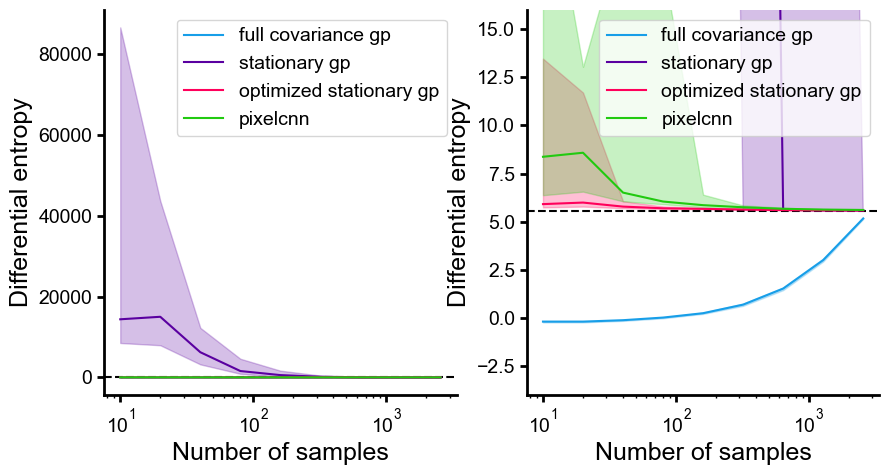

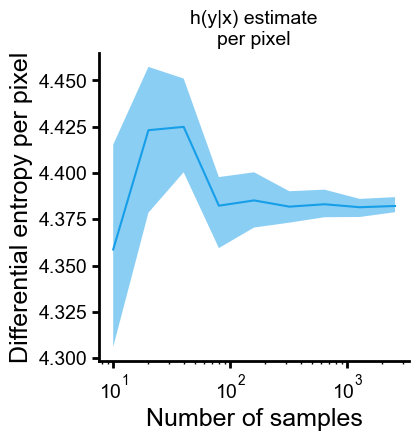

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
ax[0].axhline(h_y_analytic, color='k', linestyle='--')

colors = get_color_cycle()

ax[0].fill_between(num_samples_to_use, full_cov_h_y_estimates_conf_int[:,0], full_cov_h_y_estimates_conf_int[:,1], alpha=0.25, color=colors[0])
ax[0].semilogx(num_samples_to_use, full_cov_h_y_estimates_mean, label='full covariance gp', color=colors[0])
ax[0].fill_between(num_samples_to_use, stationary_h_y_estimates_conf_int[:,0], stationary_h_y_estimates_conf_int[:,1], alpha=0.25, color=colors[1])
ax[0].semilogx(num_samples_to_use, stationary_h_y_estimates_mean, label='stationary gp', color=colors[1])
ax[0].fill_between(num_samples_to_use, stationary_h_y_estimates_optimized_conf_int[:,0], stationary_h_y_estimates_optimized_conf_int[:,1], alpha=0.25, color=colors[2])
ax[0].semilogx(num_samples_to_use, stationary_h_y_estimates_optimized_mean, label='optimized stationary gp', color=colors[2])
ax[0].fill_between(num_samples_to_use, pixelcnn_h_y_estimates_conf_int[:,0], pixelcnn_h_y_estimates_conf_int[:,1], alpha=0.25, color=colors[3])
ax[0].semilogx(num_samples_to_use, pixelcnn_h_y_estimates_mean, label='pixelcnn', color=colors[3])

ax[0].set(xlabel='Number of samples', ylabel='Differential entropy')
ax[0].legend()
clear_spines(ax[0])

# Zoomed in
ax[1].axhline(h_y_analytic, color='k', linestyle='--')

ax[1].fill_between(num_samples_to_use, full_cov_h_y_estimates_conf_int[:,0], full_cov_h_y_estimates_conf_int[:,1], alpha=0.25, color=colors[0])
ax[1].semilogx(num_samples_to_use, full_cov_h_y_estimates_mean, label='full covariance gp', color=colors[0])
ax[1].fill_between(num_samples_to_use, stationary_h_y_estimates_conf_int[:,0], stationary_h_y_estimates_conf_int[:,1], alpha=0.25, color=colors[1])
ax[1].semilogx(num_samples_to_use, stationary_h_y_estimates_mean, label='stationary gp', color=colors[1])
ax[1].fill_between(num_samples_to_use, stationary_h_y_estimates_optimized_conf_int[:,0], stationary_h_y_estimates_optimized_conf_int[:,1], alpha=0.25, color=colors[2])
ax[1].semilogx(num_samples_to_use, stationary_h_y_estimates_optimized_mean, label='optimized stationary gp', color=colors[2])
ax[1].fill_between(num_samples_to_use, pixelcnn_h_y_estimates_conf_int[:,0], pixelcnn_h_y_estimates_conf_int[:,1], alpha=0.25, color=colors[3])
ax[1].semilogx(num_samples_to_use, pixelcnn_h_y_estimates_mean, label='pixelcnn', color=colors[3])

ax[1].set(xlabel='Number of samples', ylabel='Differential entropy')
ax[1].legend()
clear_spines(ax[1])
ax[1].set(ylim=(-4, 16))

fig.savefig('/home/hpinkard_waller/figures/mi_estimation/' + 'entropy_estimation_consistency' + '.pdf', transparent=True)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.fill_between(num_samples_to_use, h_y_given_x_estimates_conf_int[:, 0], h_y_given_x_estimates_conf_int[:, 1], alpha=0.5)
ax.semilogx(num_samples_to_use, h_y_given_x_estimates_mean)
ax.set(xlabel='Number of samples', title='h(y|x) estimate\nper pixel', ylabel='Differential entropy per pixel')
clear_spines(ax)


fig.savefig('/home/hpinkard_waller/figures/mi_estimation/' + 'conditional_entropy_consistency' + '.pdf', transparent=True)